In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

$\textbf{Introduction}$

- We examine data compression tools of the PCA and the Neural Network Autoencoder
- We examine their performance both with training data and out of sample test set data
- One of the key lessons is that for the nonlinear method, it is very important to squash the data
- Otherwise the optimal parameters will likely not converge to the minimum sum of squared errors
- We read in a large spread sheet with Hong Kong and US Swap Option volatilities for various maturieis
- Obivously there are more swap option volatility quotes for the US than for Hong Kong
- We should like to know how they interrelate and influence one another
- Since Hong Kong has a credible fixed exchange rate with the US dollar, any differences would not be due to currency risk
- Significnat differences would relect $\textit{idiosyncratic risk}$.


        Date  HDSV0A2 Curncy  HDSV0A1 Curncy  HDSV0210 Curncy  HDSV101 Curncy  \
0 2005-05-25            30.5            37.5            18.70           18.00   
1 2005-05-26            31.5            37.5            18.80           18.00   
2 2005-05-27            30.5            36.0            18.80           17.90   
3 2005-05-30            31.0            35.5            18.80           17.90   
4 2005-05-31            30.5            35.0            18.85           18.05   

   HDSV015 Curncy  HDSV0110 Curncy  HDSV0C2 Curncy  USSN0C10 Curncy  \
0           23.60            20.00           30.70            83.60   
1           23.60            20.10           30.30            83.60   
2           23.60            20.20           30.60            82.15   
3           23.60            20.10           30.60            82.15   
4           22.55            18.75           28.75            83.30   

   USSN0110 Curncy  ...  USSN036 Curncy  USSN038 Curncy  USSN039 Curncy  \
0          

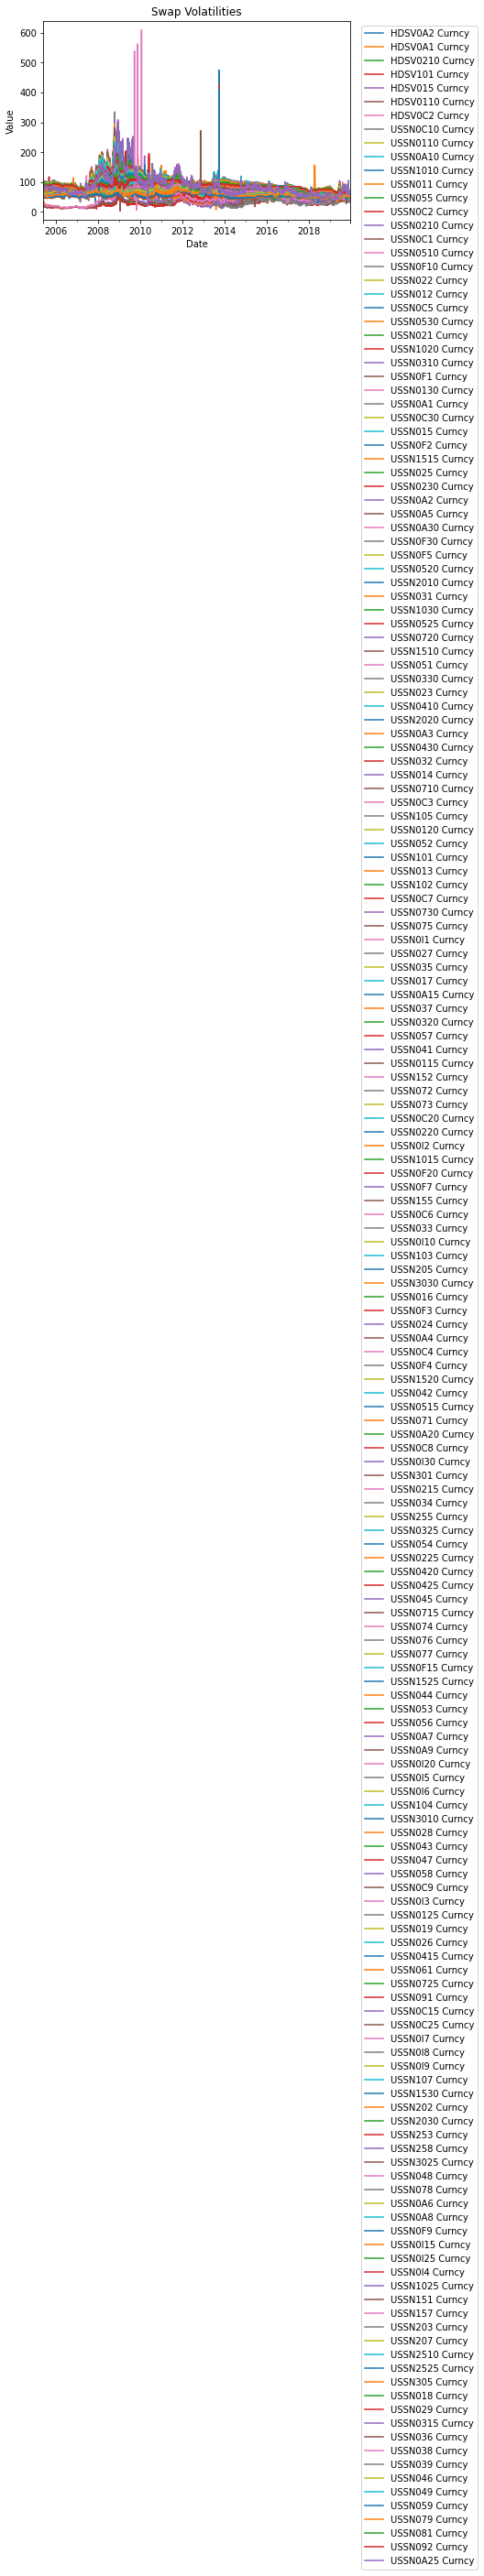

In [2]:
df = pd.read_excel('HKSwap2.xlsx', parse_dates=[0]) 
print(df.head())
#df = pd.read_excel('USInterestRate.xlsx', parse_dates=['Date'])

# Set the index of the DataFrame to the date column
df.set_index('Date', inplace=True)

# Plot the DataFrame using Matplotlib
df.plot()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Swap Volatilities')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
plt.show()

In [3]:
import matplotlib.pyplot as plt

- We normalize the data between zero and one.  
- It does no harm to the linear estimation since we do a linear transformation
- It saves a lot of time and speeds up convergence in nonlinear estimation
- We can also standarize the data or do a normalization in the interval [-1,1]
- You can check if alternative normalization makes any difference
- We use the MinMaxScaler below for (0,1) but you can change it to (-1,1)

 - We will pull out the HK and US data and do a full-sample analysis of the performance of models
 - We will then estimate with the training set data for both and then see how the models perform out-of-sample with test sets
 - We normalize the data between [0,1]
 - There is also the option to standarize the data sets
 - I leave it to you to test for the sensitivity of the alternative "squasher" functions.

In [4]:
X = df.iloc[:, 1:].values
Date = df.iloc[:,0].index
from sklearn.preprocessing import MinMaxScaler
# X_standardized is the standardized matrix
scaler = MinMaxScaler(feature_range=(0, 1))
X= scaler.fit_transform(X)
HK = X[:,:7]
USA = X[:,7:]
HKtrain, HKtest = train_test_split(HK, test_size=0.2, random_state=42)
USAtrain, USAtest = train_test_split(USA, test_size= 0.2, random_state=42)
print(HKtrain.shape)
print(HKtest.shape)

(3038, 7)
(760, 7)


$\textbf{Hong Kong Data}$

(3798, 7)


Text(0.5, 1.0, 'Hong Kong Swap Volatilities')

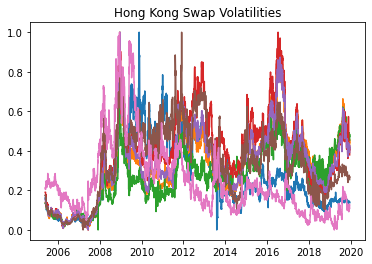

In [5]:
print(HK.shape)
plt.plot(Date,HK) 
plt.title('Hong Kong Swap Volatilities')

Text(0.5, 1.0, 'USA Swap Option Volatilities')

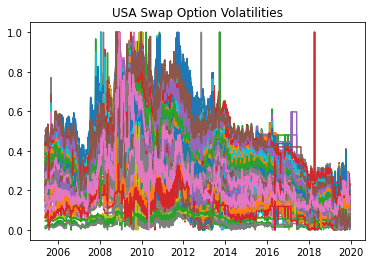

In [6]:
plt.plot(Date, USA)
plt.title('USA Swap Option Volatilities')

- We can see that the standard deviations are practically identical since the data are normalized.
- We import and use the PCA algorithm to examine the effectiveness for the first two principal components
- We do a scatter diagram to see that the two do not have a significant positive or negative correlation

In [7]:
Stats = np.std(HK,0)
StatsUS = np.std(USA,0)
print(np.max(Stats))
print(np.max(StatsUS))



0.20486869440186767
0.2032764279294758


In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
PC = pca.fit_transform(HK)

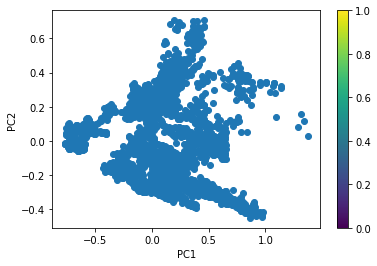

In [9]:
plt.scatter(PC[:,0], PC[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()


Text(0.5, 1.0, 'Principal Components for Hong Kong')

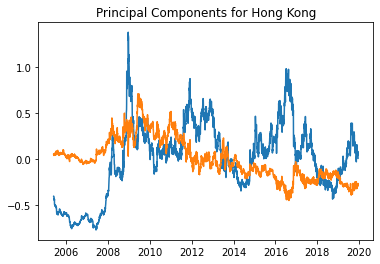

In [10]:
plt.plot(Date,PC)
plt.title('Principal Components for Hong Kong')

In [11]:
HKhat = pca.inverse_transform(PC)


Text(0.5, 1.0, 'Predicted Values for HK')

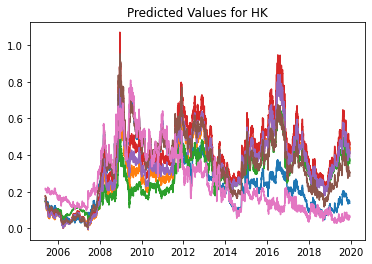

In [12]:
plt.plot(Date, HKhat)
plt.title('Predicted Values for HK')

78.66233725446509


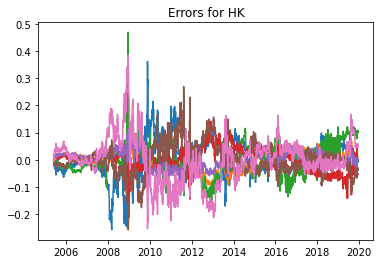

In [13]:
ERROR = HK - HKhat
plt.plot(Date,ERROR)
plt.title('Errors for HK')
SEE = np.sum(ERROR**2,axis=0)
SEE1 = np.sum(SEE)
print(SEE1)

In [14]:
variance_ratio = pca.explained_variance_ratio_
junk = np.var(HKhat,0)
junk1 = np.var(HK,0)
RSQ_PC_HK = junk/junk1
print(RSQ_PC_HK)
print(np.min(RSQ_PC_HK))
# Calculate the total percentage of the variance captured by the first two principal components
total_variance = np.sum(variance_ratio[:2])
percent_total_variance = total_variance * 100

print(f'The first two principal components explain {percent_total_variance:.2f} of the total variance')





[0.85894373 0.96162456 0.84353158 0.95964647 0.97622294 0.91419614
 0.80602972]
0.806029720131084
The first two principal components explain 90.80 of the total variance


 - We now do the out-of-sample statistics
 - We first fit the training set for the two components
 - We then find, after fitting, the transformation for the test data
 - We then see how the fitted PC's explain the out-of-sample data
 - We keep the errors and the root mean squared errors for the seven series

In [15]:
pca1 = PCA(n_components=2)
HK_train = pd.DataFrame(HKtrain)
HK_test  = pd.DataFrame(HKtest)
HK_train_pca = pca1.fit_transform(HK_train)
HK_test_pca = pca1.transform(HK_test)
HK_out = pca1.inverse_transform(HK_test_pca)
HK_ERROR = HK_test - HK_out
HK_ERROR2 = HK_ERROR**2
HK_ERROR2M = HK_ERROR2.mean(axis=0)
HK_RMSQ = HK_ERROR2M**.5
print(HK_RMSQ)


0    0.066872
1    0.034134
2    0.052960
3    0.039204
4    0.027026
5    0.053986
6    0.077972
dtype: float64


-
- Now lets try an autoencoder neural network
- Network structure is [20-10-2-10-20]
- Two layers of encoders and two layers of decoders

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Load data into a NumPy array
# Define the dimensions of the input and latent spaces
input_dim = HK.shape[1]
latent_dim = 1

# Define the encoder
inputs = Input(shape=(input_dim,))
encoded = Dense(100, activation='sigmoid')(inputs)
encoded = Dense(50, activation='sigmoid')(encoded)
encoded = Dense(2, activation='relu')(encoded)
decoded = Dense(50, activation='sigmoid')(encoded)
decoded = Dense(100, activation='sigmoid')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

# Define the autoencoder
autoencoder = Model(inputs, decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(HK, HK, epochs=10000)

# Extract the encoder model for dimensionality reduction
encoder = Model(inputs, encoded)
encoded_HK = encoder.predict(HK)




Epoch 1/10000
119/119 [==============================] - 1s 817us/step - loss: 0.0532
Epoch 2/10000
119/119 [==============================] - 0s 779us/step - loss: 0.0319
Epoch 3/10000
119/119 [==============================] - 0s 771us/step - loss: 0.0226
Epoch 4/10000
119/119 [==============================] - 0s 790us/step - loss: 0.0104
Epoch 5/10000
119/119 [==============================] - 0s 773us/step - loss: 0.0102
Epoch 6/10000
119/119 [==============================] - 0s 775us/step - loss: 0.0099
Epoch 7/10000
119/119 [==============================] - 0s 775us/step - loss: 0.0081
Epoch 8/10000
119/119 [==============================] - 0s 820us/step - loss: 0.0037
Epoch 9/10000
119/119 [==============================] - 0s 793us/step - loss: 0.0031
Epoch 10/10000
119/119 [==============================] - 0s 769us/step - loss: 0.0031
Epoch 11/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0031
Epoch 12/10000
119/119 [============================

119/119 [==============================] - 0s 754us/step - loss: 0.0019
Epoch 96/10000
119/119 [==============================] - 0s 773us/step - loss: 0.0020
Epoch 97/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0019
Epoch 98/10000
119/119 [==============================] - 0s 765us/step - loss: 0.0019
Epoch 99/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0019
Epoch 100/10000
119/119 [==============================] - 0s 756us/step - loss: 0.0019
Epoch 101/10000
119/119 [==============================] - 0s 762us/step - loss: 0.0019
Epoch 102/10000
119/119 [==============================] - 0s 768us/step - loss: 0.0019
Epoch 103/10000
119/119 [==============================] - 0s 751us/step - loss: 0.0019
Epoch 104/10000
119/119 [==============================] - 0s 762us/step - loss: 0.0019
Epoch 105/10000
119/119 [==============================] - 0s 757us/step - loss: 0.0019
Epoch 106/10000
119/119 [===========================

119/119 [==============================] - 0s 771us/step - loss: 0.0015
Epoch 189/10000
119/119 [==============================] - 0s 756us/step - loss: 0.0016
Epoch 190/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0015
Epoch 191/10000
119/119 [==============================] - 0s 773us/step - loss: 0.0015
Epoch 192/10000
119/119 [==============================] - 0s 745us/step - loss: 0.0015
Epoch 193/10000
119/119 [==============================] - 0s 765us/step - loss: 0.0015
Epoch 194/10000
119/119 [==============================] - 0s 760us/step - loss: 0.0015
Epoch 195/10000
119/119 [==============================] - 0s 765us/step - loss: 0.0015
Epoch 196/10000
119/119 [==============================] - 0s 768us/step - loss: 0.0015
Epoch 197/10000
119/119 [==============================] - 0s 765us/step - loss: 0.0015
Epoch 198/10000
119/119 [==============================] - 0s 748us/step - loss: 0.0015
Epoch 199/10000
119/119 [=======================

119/119 [==============================] - 0s 723us/step - loss: 0.0014
Epoch 282/10000
119/119 [==============================] - 0s 813us/step - loss: 0.0014
Epoch 283/10000
119/119 [==============================] - 0s 697us/step - loss: 0.0014
Epoch 284/10000
119/119 [==============================] - 0s 813us/step - loss: 0.0014
Epoch 285/10000
119/119 [==============================] - 0s 696us/step - loss: 0.0014
Epoch 286/10000
119/119 [==============================] - 0s 766us/step - loss: 0.0014
Epoch 287/10000
119/119 [==============================] - 0s 809us/step - loss: 0.0014
Epoch 288/10000
119/119 [==============================] - 0s 748us/step - loss: 0.0014
Epoch 289/10000
119/119 [==============================] - 0s 766us/step - loss: 0.0014
Epoch 290/10000
119/119 [==============================] - 0s 759us/step - loss: 0.0014
Epoch 291/10000
119/119 [==============================] - 0s 793us/step - loss: 0.0014
Epoch 292/10000
119/119 [=======================

119/119 [==============================] - 0s 761us/step - loss: 0.0013
Epoch 375/10000
119/119 [==============================] - 0s 769us/step - loss: 0.0013
Epoch 376/10000
119/119 [==============================] - 0s 744us/step - loss: 0.0014
Epoch 377/10000
119/119 [==============================] - 0s 752us/step - loss: 0.0013
Epoch 378/10000
119/119 [==============================] - 0s 752us/step - loss: 0.0014
Epoch 379/10000
119/119 [==============================] - 0s 759us/step - loss: 0.0013
Epoch 380/10000
119/119 [==============================] - 0s 810us/step - loss: 0.0014
Epoch 381/10000
119/119 [==============================] - 0s 778us/step - loss: 0.0013
Epoch 382/10000
119/119 [==============================] - 0s 759us/step - loss: 0.0013
Epoch 383/10000
119/119 [==============================] - 0s 778us/step - loss: 0.0013
Epoch 384/10000
119/119 [==============================] - 0s 871us/step - loss: 0.0014
Epoch 385/10000
119/119 [=======================

119/119 [==============================] - 0s 719us/step - loss: 0.0013
Epoch 468/10000
119/119 [==============================] - 0s 827us/step - loss: 0.0013
Epoch 469/10000
119/119 [==============================] - 0s 788us/step - loss: 0.0013
Epoch 470/10000
119/119 [==============================] - 0s 823us/step - loss: 0.0013
Epoch 471/10000
119/119 [==============================] - 0s 757us/step - loss: 0.0013
Epoch 472/10000
119/119 [==============================] - 0s 796us/step - loss: 0.0013
Epoch 473/10000
119/119 [==============================] - 0s 730us/step - loss: 0.0013
Epoch 474/10000
119/119 [==============================] - 0s 760us/step - loss: 0.0013
Epoch 475/10000
119/119 [==============================] - 0s 763us/step - loss: 0.0013
Epoch 476/10000
119/119 [==============================] - 0s 764us/step - loss: 0.0013
Epoch 477/10000
119/119 [==============================] - 0s 761us/step - loss: 0.0013
Epoch 478/10000
119/119 [=======================

119/119 [==============================] - 0s 761us/step - loss: 0.0012
Epoch 561/10000
119/119 [==============================] - 0s 761us/step - loss: 0.0012
Epoch 562/10000
119/119 [==============================] - 0s 767us/step - loss: 0.0012
Epoch 563/10000
119/119 [==============================] - 0s 759us/step - loss: 0.0012
Epoch 564/10000
119/119 [==============================] - 0s 793us/step - loss: 0.0012
Epoch 565/10000
119/119 [==============================] - 0s 735us/step - loss: 0.0012
Epoch 566/10000
119/119 [==============================] - 0s 761us/step - loss: 0.0012
Epoch 567/10000
119/119 [==============================] - 0s 822us/step - loss: 0.0012
Epoch 568/10000
119/119 [==============================] - 0s 796us/step - loss: 0.0012
Epoch 569/10000
119/119 [==============================] - 0s 763us/step - loss: 0.0012
Epoch 570/10000
119/119 [==============================] - 0s 807us/step - loss: 0.0012
Epoch 571/10000
119/119 [=======================

119/119 [==============================] - 0s 761us/step - loss: 0.0012
Epoch 654/10000
119/119 [==============================] - 0s 766us/step - loss: 0.0012
Epoch 655/10000
119/119 [==============================] - 0s 760us/step - loss: 0.0012
Epoch 656/10000
119/119 [==============================] - 0s 763us/step - loss: 0.0011
Epoch 657/10000
119/119 [==============================] - 0s 764us/step - loss: 0.0012
Epoch 658/10000
119/119 [==============================] - 0s 762us/step - loss: 0.0012
Epoch 659/10000
119/119 [==============================] - 0s 765us/step - loss: 0.0012
Epoch 660/10000
119/119 [==============================] - 0s 765us/step - loss: 0.0012
Epoch 661/10000
119/119 [==============================] - 0s 762us/step - loss: 0.0012
Epoch 662/10000
119/119 [==============================] - 0s 763us/step - loss: 0.0012
Epoch 663/10000
119/119 [==============================] - 0s 810us/step - loss: 0.0011
Epoch 664/10000
119/119 [=======================

119/119 [==============================] - 0s 801us/step - loss: 0.0011
Epoch 747/10000
119/119 [==============================] - 0s 761us/step - loss: 0.0011
Epoch 748/10000
119/119 [==============================] - 0s 751us/step - loss: 0.0011
Epoch 749/10000
119/119 [==============================] - 0s 754us/step - loss: 0.0011
Epoch 750/10000
119/119 [==============================] - 0s 756us/step - loss: 0.0011
Epoch 751/10000
119/119 [==============================] - 0s 753us/step - loss: 0.0011
Epoch 752/10000
119/119 [==============================] - 0s 776us/step - loss: 0.0011
Epoch 753/10000
119/119 [==============================] - 0s 778us/step - loss: 0.0011
Epoch 754/10000
119/119 [==============================] - 0s 761us/step - loss: 0.0011
Epoch 755/10000
119/119 [==============================] - 0s 763us/step - loss: 0.0011
Epoch 756/10000
119/119 [==============================] - 0s 762us/step - loss: 0.0011
Epoch 757/10000
119/119 [=======================

119/119 [==============================] - 0s 759us/step - loss: 0.0010
Epoch 840/10000
119/119 [==============================] - 0s 765us/step - loss: 0.0011
Epoch 841/10000
119/119 [==============================] - 0s 759us/step - loss: 0.0010
Epoch 842/10000
119/119 [==============================] - 0s 732us/step - loss: 0.0010
Epoch 843/10000
119/119 [==============================] - 0s 777us/step - loss: 0.0010
Epoch 844/10000
119/119 [==============================] - 0s 752us/step - loss: 0.0010
Epoch 845/10000
119/119 [==============================] - 0s 761us/step - loss: 0.0010
Epoch 846/10000
119/119 [==============================] - 0s 744us/step - loss: 0.0011
Epoch 847/10000
119/119 [==============================] - 0s 752us/step - loss: 0.0010
Epoch 848/10000
119/119 [==============================] - 0s 745us/step - loss: 0.0011
Epoch 849/10000
119/119 [==============================] - 0s 752us/step - loss: 0.0011
Epoch 850/10000
119/119 [=======================

119/119 [==============================] - 0s 778us/step - loss: 0.0010
Epoch 933/10000
119/119 [==============================] - 0s 758us/step - loss: 9.9842e-04
Epoch 934/10000
119/119 [==============================] - 0s 752us/step - loss: 0.0010
Epoch 935/10000
119/119 [==============================] - 0s 752us/step - loss: 9.8925e-04
Epoch 936/10000
119/119 [==============================] - 0s 744us/step - loss: 0.0010
Epoch 937/10000
119/119 [==============================] - 0s 752us/step - loss: 0.0010
Epoch 938/10000
119/119 [==============================] - 0s 752us/step - loss: 0.0010
Epoch 939/10000
119/119 [==============================] - 0s 744us/step - loss: 0.0010
Epoch 940/10000
119/119 [==============================] - 0s 752us/step - loss: 0.0010
Epoch 941/10000
119/119 [==============================] - 0s 744us/step - loss: 9.9961e-04
Epoch 942/10000
119/119 [==============================] - 0s 752us/step - loss: 9.9850e-04
Epoch 943/10000
119/119 [=======

119/119 [==============================] - 0s 819us/step - loss: 9.7642e-04
Epoch 1022/10000
119/119 [==============================] - 0s 688us/step - loss: 9.6041e-04
Epoch 1023/10000
119/119 [==============================] - 0s 787us/step - loss: 9.6803e-04
Epoch 1024/10000
119/119 [==============================] - 0s 720us/step - loss: 9.6464e-04
Epoch 1025/10000
119/119 [==============================] - 0s 771us/step - loss: 9.6986e-04
Epoch 1026/10000
119/119 [==============================] - 0s 756us/step - loss: 9.7110e-04
Epoch 1027/10000
119/119 [==============================] - 0s 715us/step - loss: 9.5567e-04
Epoch 1028/10000
119/119 [==============================] - 0s 740us/step - loss: 9.6369e-04
Epoch 1029/10000
119/119 [==============================] - 0s 764us/step - loss: 9.7134e-04
Epoch 1030/10000
119/119 [==============================] - 0s 765us/step - loss: 9.8091e-04
Epoch 1031/10000
119/119 [==============================] - 0s 759us/step - loss: 9.903

119/119 [==============================] - 0s 682us/step - loss: 9.5008e-04
Epoch 1110/10000
119/119 [==============================] - 0s 760us/step - loss: 9.3831e-04
Epoch 1111/10000
119/119 [==============================] - 0s 714us/step - loss: 9.3206e-04
Epoch 1112/10000
119/119 [==============================] - 0s 680us/step - loss: 9.3126e-04
Epoch 1113/10000
119/119 [==============================] - 0s 764us/step - loss: 9.4122e-04
Epoch 1114/10000
119/119 [==============================] - 0s 761us/step - loss: 9.5064e-04
Epoch 1115/10000
119/119 [==============================] - 0s 764us/step - loss: 9.4702e-04
Epoch 1116/10000
119/119 [==============================] - 0s 763us/step - loss: 9.4466e-04
Epoch 1117/10000
119/119 [==============================] - 0s 762us/step - loss: 9.4657e-04
Epoch 1118/10000
119/119 [==============================] - 0s 763us/step - loss: 9.4119e-04
Epoch 1119/10000
119/119 [==============================] - 0s 718us/step - loss: 9.408

119/119 [==============================] - 0s 710us/step - loss: 9.2961e-04
Epoch 1198/10000
119/119 [==============================] - 0s 812us/step - loss: 9.1244e-04
Epoch 1199/10000
119/119 [==============================] - 0s 745us/step - loss: 9.1957e-04
Epoch 1200/10000
119/119 [==============================] - 0s 752us/step - loss: 9.3776e-04
Epoch 1201/10000
119/119 [==============================] - 0s 688us/step - loss: 9.2543e-04
Epoch 1202/10000
119/119 [==============================] - 0s 845us/step - loss: 9.1834e-04
Epoch 1203/10000
119/119 [==============================] - 0s 769us/step - loss: 9.3798e-04
Epoch 1204/10000
119/119 [==============================] - 0s 752us/step - loss: 9.1909e-04
Epoch 1205/10000
119/119 [==============================] - 0s 722us/step - loss: 9.2143e-04
Epoch 1206/10000
119/119 [==============================] - 0s 717us/step - loss: 9.3705e-04
Epoch 1207/10000
119/119 [==============================] - 0s 777us/step - loss: 9.299

119/119 [==============================] - 0s 702us/step - loss: 9.0268e-04
Epoch 1286/10000
119/119 [==============================] - 0s 799us/step - loss: 8.9714e-04
Epoch 1287/10000
119/119 [==============================] - 0s 717us/step - loss: 9.2029e-04
Epoch 1288/10000
119/119 [==============================] - 0s 766us/step - loss: 9.2328e-04
Epoch 1289/10000
119/119 [==============================] - 0s 760us/step - loss: 8.8624e-04
Epoch 1290/10000
119/119 [==============================] - 0s 766us/step - loss: 8.9690e-04
Epoch 1291/10000
119/119 [==============================] - 0s 762us/step - loss: 8.9641e-04
Epoch 1292/10000
119/119 [==============================] - 0s 763us/step - loss: 9.0778e-04
Epoch 1293/10000
119/119 [==============================] - 0s 763us/step - loss: 8.9758e-04
Epoch 1294/10000
119/119 [==============================] - 0s 761us/step - loss: 8.9210e-04
Epoch 1295/10000
119/119 [==============================] - 0s 762us/step - loss: 8.993

119/119 [==============================] - 0s 765us/step - loss: 8.7175e-04
Epoch 1374/10000
119/119 [==============================] - 0s 681us/step - loss: 8.7327e-04
Epoch 1375/10000
119/119 [==============================] - 0s 818us/step - loss: 8.6899e-04
Epoch 1376/10000
119/119 [==============================] - 0s 705us/step - loss: 8.9771e-04
Epoch 1377/10000
119/119 [==============================] - 0s 805us/step - loss: 8.8733e-04
Epoch 1378/10000
119/119 [==============================] - 0s 685us/step - loss: 8.8165e-04
Epoch 1379/10000
119/119 [==============================] - 0s 815us/step - loss: 8.7282e-04
Epoch 1380/10000
119/119 [==============================] - 0s 705us/step - loss: 8.7367e-04
Epoch 1381/10000
119/119 [==============================] - 0s 792us/step - loss: 8.7715e-04
Epoch 1382/10000
119/119 [==============================] - 0s 707us/step - loss: 8.7842e-04
Epoch 1383/10000
119/119 [==============================] - 0s 802us/step - loss: 8.635

119/119 [==============================] - 0s 769us/step - loss: 8.6112e-04
Epoch 1462/10000
119/119 [==============================] - 0s 786us/step - loss: 8.5944e-04
Epoch 1463/10000
119/119 [==============================] - 0s 720us/step - loss: 8.7439e-04
Epoch 1464/10000
119/119 [==============================] - 0s 865us/step - loss: 8.4622e-04
Epoch 1465/10000
119/119 [==============================] - 0s 728us/step - loss: 8.5734e-04
Epoch 1466/10000
119/119 [==============================] - 0s 768us/step - loss: 8.5804e-04
Epoch 1467/10000
119/119 [==============================] - 0s 759us/step - loss: 8.6384e-04
Epoch 1468/10000
119/119 [==============================] - 0s 764us/step - loss: 8.5760e-04
Epoch 1469/10000
119/119 [==============================] - 0s 765us/step - loss: 8.4589e-04
Epoch 1470/10000
119/119 [==============================] - 0s 763us/step - loss: 8.4930e-04
Epoch 1471/10000
119/119 [==============================] - 0s 760us/step - loss: 8.442

119/119 [==============================] - 0s 748us/step - loss: 8.3165e-04
Epoch 1550/10000
119/119 [==============================] - 0s 787us/step - loss: 8.3354e-04
Epoch 1551/10000
119/119 [==============================] - 0s 732us/step - loss: 8.4050e-04
Epoch 1552/10000
119/119 [==============================] - 0s 763us/step - loss: 8.4183e-04
Epoch 1553/10000
119/119 [==============================] - 0s 763us/step - loss: 8.3581e-04
Epoch 1554/10000
119/119 [==============================] - 0s 779us/step - loss: 8.3098e-04
Epoch 1555/10000
119/119 [==============================] - 0s 728us/step - loss: 8.4068e-04
Epoch 1556/10000
119/119 [==============================] - 0s 772us/step - loss: 8.4009e-04
Epoch 1557/10000
119/119 [==============================] - 0s 837us/step - loss: 8.4892e-04
Epoch 1558/10000
119/119 [==============================] - 0s 765us/step - loss: 8.2853e-04
Epoch 1559/10000
119/119 [==============================] - 0s 760us/step - loss: 8.209

119/119 [==============================] - 0s 765us/step - loss: 8.0082e-04
Epoch 1638/10000
119/119 [==============================] - 0s 744us/step - loss: 8.1766e-04
Epoch 1639/10000
119/119 [==============================] - 0s 757us/step - loss: 8.1044e-04
Epoch 1640/10000
119/119 [==============================] - 0s 668us/step - loss: 8.0454e-04
Epoch 1641/10000
119/119 [==============================] - 0s 744us/step - loss: 8.1335e-04
Epoch 1642/10000
119/119 [==============================] - 0s 680us/step - loss: 8.1737e-04
Epoch 1643/10000
119/119 [==============================] - 0s 839us/step - loss: 8.1713e-04
Epoch 1644/10000
119/119 [==============================] - 0s 744us/step - loss: 7.9656e-04
Epoch 1645/10000
119/119 [==============================] - 0s 810us/step - loss: 8.0796e-04
Epoch 1646/10000
119/119 [==============================] - 0s 714us/step - loss: 8.1534e-04
Epoch 1647/10000
119/119 [==============================] - 0s 750us/step - loss: 7.976

119/119 [==============================] - 0s 765us/step - loss: 7.8112e-04
Epoch 1726/10000
119/119 [==============================] - 0s 762us/step - loss: 7.9544e-04
Epoch 1727/10000
119/119 [==============================] - 0s 761us/step - loss: 7.7626e-04
Epoch 1728/10000
119/119 [==============================] - 0s 761us/step - loss: 7.8862e-04
Epoch 1729/10000
119/119 [==============================] - 0s 766us/step - loss: 7.9203e-04
Epoch 1730/10000
119/119 [==============================] - 0s 762us/step - loss: 8.0012e-04
Epoch 1731/10000
119/119 [==============================] - 0s 761us/step - loss: 7.8301e-04
Epoch 1732/10000
119/119 [==============================] - 0s 763us/step - loss: 7.8317e-04
Epoch 1733/10000
119/119 [==============================] - 0s 759us/step - loss: 7.7808e-04
Epoch 1734/10000
119/119 [==============================] - 0s 732us/step - loss: 7.7568e-04
Epoch 1735/10000
119/119 [==============================] - 0s 788us/step - loss: 7.752

119/119 [==============================] - 0s 719us/step - loss: 7.5287e-04
Epoch 1814/10000
119/119 [==============================] - 0s 789us/step - loss: 7.5965e-04
Epoch 1815/10000
119/119 [==============================] - 0s 740us/step - loss: 7.5478e-04
Epoch 1816/10000
119/119 [==============================] - 0s 795us/step - loss: 7.6362e-04
Epoch 1817/10000
119/119 [==============================] - 0s 668us/step - loss: 7.5879e-04
Epoch 1818/10000
119/119 [==============================] - 0s 683us/step - loss: 7.7108e-04
Epoch 1819/10000
119/119 [==============================] - 0s 675us/step - loss: 7.6626e-04
Epoch 1820/10000
119/119 [==============================] - 0s 697us/step - loss: 7.6697e-04
Epoch 1821/10000
119/119 [==============================] - 0s 762us/step - loss: 7.6560e-04
Epoch 1822/10000
119/119 [==============================] - 0s 764us/step - loss: 7.7100e-04
Epoch 1823/10000
119/119 [==============================] - 0s 720us/step - loss: 7.660

119/119 [==============================] - 0s 752us/step - loss: 7.4364e-04
Epoch 1902/10000
119/119 [==============================] - 0s 744us/step - loss: 7.4208e-04
Epoch 1903/10000
119/119 [==============================] - 0s 769us/step - loss: 7.4203e-04
Epoch 1904/10000
119/119 [==============================] - 0s 760us/step - loss: 7.4554e-04
Epoch 1905/10000
119/119 [==============================] - 0s 752us/step - loss: 7.4070e-04
Epoch 1906/10000
119/119 [==============================] - 0s 717us/step - loss: 7.5395e-04
Epoch 1907/10000
119/119 [==============================] - 0s 793us/step - loss: 7.5272e-04
Epoch 1908/10000
119/119 [==============================] - 0s 733us/step - loss: 7.3488e-04
Epoch 1909/10000
119/119 [==============================] - 0s 761us/step - loss: 7.2850e-04
Epoch 1910/10000
119/119 [==============================] - 0s 746us/step - loss: 7.4284e-04
Epoch 1911/10000
119/119 [==============================] - 0s 786us/step - loss: 7.401

119/119 [==============================] - 0s 744us/step - loss: 7.2118e-04
Epoch 1990/10000
119/119 [==============================] - 0s 752us/step - loss: 7.2298e-04
Epoch 1991/10000
119/119 [==============================] - 0s 752us/step - loss: 7.2250e-04
Epoch 1992/10000
119/119 [==============================] - 0s 744us/step - loss: 7.3066e-04
Epoch 1993/10000
119/119 [==============================] - 0s 752us/step - loss: 7.1486e-04
Epoch 1994/10000
119/119 [==============================] - 0s 752us/step - loss: 7.3748e-04
Epoch 1995/10000
119/119 [==============================] - 0s 752us/step - loss: 7.3403e-04
Epoch 1996/10000
119/119 [==============================] - 0s 749us/step - loss: 7.2757e-04
Epoch 1997/10000
119/119 [==============================] - 0s 763us/step - loss: 7.3108e-04
Epoch 1998/10000
119/119 [==============================] - 0s 758us/step - loss: 7.4418e-04
Epoch 1999/10000
119/119 [==============================] - 0s 804us/step - loss: 7.201

119/119 [==============================] - 0s 785us/step - loss: 7.2238e-04
Epoch 2078/10000
119/119 [==============================] - 0s 734us/step - loss: 7.1447e-04
Epoch 2079/10000
119/119 [==============================] - 0s 826us/step - loss: 7.2045e-04
Epoch 2080/10000
119/119 [==============================] - 0s 762us/step - loss: 7.1329e-04
Epoch 2081/10000
119/119 [==============================] - 0s 765us/step - loss: 7.0619e-04
Epoch 2082/10000
119/119 [==============================] - 0s 760us/step - loss: 7.0121e-04
Epoch 2083/10000
119/119 [==============================] - 0s 764us/step - loss: 7.1417e-04
Epoch 2084/10000
119/119 [==============================] - 0s 762us/step - loss: 7.1568e-04
Epoch 2085/10000
119/119 [==============================] - 0s 763us/step - loss: 7.1425e-04
Epoch 2086/10000
119/119 [==============================] - 0s 764us/step - loss: 7.1780e-04
Epoch 2087/10000
119/119 [==============================] - 0s 763us/step - loss: 6.979

119/119 [==============================] - 0s 738us/step - loss: 6.8583e-04
Epoch 2166/10000
119/119 [==============================] - 0s 827us/step - loss: 6.9245e-04
Epoch 2167/10000
119/119 [==============================] - 0s 688us/step - loss: 6.9435e-04
Epoch 2168/10000
119/119 [==============================] - 0s 829us/step - loss: 7.0126e-04
Epoch 2169/10000
119/119 [==============================] - 0s 705us/step - loss: 6.8788e-04
Epoch 2170/10000
119/119 [==============================] - 0s 759us/step - loss: 6.9174e-04
Epoch 2171/10000
119/119 [==============================] - 0s 676us/step - loss: 6.9854e-04
Epoch 2172/10000
119/119 [==============================] - 0s 697us/step - loss: 6.9230e-04
Epoch 2173/10000
119/119 [==============================] - 0s 679us/step - loss: 6.8383e-04
Epoch 2174/10000
119/119 [==============================] - 0s 762us/step - loss: 6.9341e-04
Epoch 2175/10000
119/119 [==============================] - 0s 677us/step - loss: 6.880

119/119 [==============================] - 0s 736us/step - loss: 6.8003e-04
Epoch 2254/10000
119/119 [==============================] - 0s 693us/step - loss: 6.7392e-04
Epoch 2255/10000
119/119 [==============================] - 0s 847us/step - loss: 6.8221e-04
Epoch 2256/10000
119/119 [==============================] - 0s 766us/step - loss: 6.7157e-04
Epoch 2257/10000
119/119 [==============================] - 0s 763us/step - loss: 6.8335e-04
Epoch 2258/10000
119/119 [==============================] - 0s 678us/step - loss: 6.7834e-04
Epoch 2259/10000
119/119 [==============================] - 0s 676us/step - loss: 6.9620e-04
Epoch 2260/10000
119/119 [==============================] - 0s 678us/step - loss: 6.7608e-04
Epoch 2261/10000
119/119 [==============================] - 0s 675us/step - loss: 6.7266e-04
Epoch 2262/10000
119/119 [==============================] - 0s 681us/step - loss: 6.7266e-04
Epoch 2263/10000
119/119 [==============================] - 0s 678us/step - loss: 6.695

119/119 [==============================] - 0s 769us/step - loss: 6.6012e-04
Epoch 2342/10000
119/119 [==============================] - 0s 744us/step - loss: 6.5960e-04
Epoch 2343/10000
119/119 [==============================] - 0s 744us/step - loss: 6.6099e-04
Epoch 2344/10000
119/119 [==============================] - 0s 744us/step - loss: 6.5787e-04
Epoch 2345/10000
119/119 [==============================] - 0s 749us/step - loss: 6.6873e-04
Epoch 2346/10000
119/119 [==============================] - 0s 752us/step - loss: 6.6997e-04
Epoch 2347/10000
119/119 [==============================] - 0s 744us/step - loss: 6.7166e-04
Epoch 2348/10000
119/119 [==============================] - 0s 732us/step - loss: 6.5613e-04
Epoch 2349/10000
119/119 [==============================] - 0s 763us/step - loss: 6.5983e-04
Epoch 2350/10000
119/119 [==============================] - 0s 769us/step - loss: 6.6590e-04
Epoch 2351/10000
119/119 [==============================] - 0s 742us/step - loss: 6.618

119/119 [==============================] - 0s 765us/step - loss: 6.4848e-04
Epoch 2430/10000
119/119 [==============================] - 0s 764us/step - loss: 6.4776e-04
Epoch 2431/10000
119/119 [==============================] - 0s 762us/step - loss: 6.4805e-04
Epoch 2432/10000
119/119 [==============================] - 0s 763us/step - loss: 6.5286e-04
Epoch 2433/10000
119/119 [==============================] - 0s 794us/step - loss: 6.4474e-04
Epoch 2434/10000
119/119 [==============================] - 0s 713us/step - loss: 6.6120e-04
Epoch 2435/10000
119/119 [==============================] - 0s 797us/step - loss: 6.5303e-04
Epoch 2436/10000
119/119 [==============================] - 0s 710us/step - loss: 6.4227e-04
Epoch 2437/10000
119/119 [==============================] - 0s 802us/step - loss: 6.5894e-04
Epoch 2438/10000
119/119 [==============================] - 0s 708us/step - loss: 6.4825e-04
Epoch 2439/10000
119/119 [==============================] - 0s 802us/step - loss: 6.524

119/119 [==============================] - 0s 765us/step - loss: 6.3443e-04
Epoch 2518/10000
119/119 [==============================] - 0s 763us/step - loss: 6.2418e-04
Epoch 2519/10000
119/119 [==============================] - 0s 762us/step - loss: 6.2765e-04
Epoch 2520/10000
119/119 [==============================] - 0s 763us/step - loss: 6.4217e-04
Epoch 2521/10000
119/119 [==============================] - 0s 762us/step - loss: 6.3173e-04
Epoch 2522/10000
119/119 [==============================] - 0s 761us/step - loss: 6.2547e-04
Epoch 2523/10000
119/119 [==============================] - 0s 765us/step - loss: 6.4891e-04
Epoch 2524/10000
119/119 [==============================] - 0s 762us/step - loss: 6.3391e-04
Epoch 2525/10000
119/119 [==============================] - 0s 782us/step - loss: 6.2963e-04
Epoch 2526/10000
119/119 [==============================] - 0s 768us/step - loss: 6.3588e-04
Epoch 2527/10000
119/119 [==============================] - 0s 719us/step - loss: 6.453

119/119 [==============================] - 0s 741us/step - loss: 6.2874e-04
Epoch 2606/10000
119/119 [==============================] - 0s 758us/step - loss: 6.2380e-04
Epoch 2607/10000
119/119 [==============================] - 0s 674us/step - loss: 6.3711e-04
Epoch 2608/10000
119/119 [==============================] - 0s 739us/step - loss: 6.2146e-04
Epoch 2609/10000
119/119 [==============================] - 0s 670us/step - loss: 6.2103e-04
Epoch 2610/10000
119/119 [==============================] - 0s 681us/step - loss: 6.2179e-04
Epoch 2611/10000
119/119 [==============================] - 0s 677us/step - loss: 6.2579e-04
Epoch 2612/10000
119/119 [==============================] - 0s 780us/step - loss: 6.2234e-04
Epoch 2613/10000
119/119 [==============================] - 0s 746us/step - loss: 6.3276e-04
Epoch 2614/10000
119/119 [==============================] - 0s 763us/step - loss: 6.2453e-04
Epoch 2615/10000
119/119 [==============================] - 0s 763us/step - loss: 6.303

119/119 [==============================] - 0s 759us/step - loss: 6.1071e-04
Epoch 2694/10000
119/119 [==============================] - 0s 766us/step - loss: 6.0055e-04
Epoch 2695/10000
119/119 [==============================] - 0s 676us/step - loss: 6.0243e-04
Epoch 2696/10000
119/119 [==============================] - 0s 675us/step - loss: 6.1539e-04
Epoch 2697/10000
119/119 [==============================] - 0s 676us/step - loss: 6.0817e-04
Epoch 2698/10000
119/119 [==============================] - 0s 675us/step - loss: 6.1022e-04
Epoch 2699/10000
119/119 [==============================] - 0s 764us/step - loss: 6.1466e-04
Epoch 2700/10000
119/119 [==============================] - 0s 764us/step - loss: 6.0284e-04
Epoch 2701/10000
119/119 [==============================] - 0s 763us/step - loss: 6.1277e-04
Epoch 2702/10000
119/119 [==============================] - 0s 760us/step - loss: 6.2838e-04
Epoch 2703/10000
119/119 [==============================] - 0s 763us/step - loss: 6.056

119/119 [==============================] - 0s 764us/step - loss: 6.0357e-04
Epoch 2782/10000
119/119 [==============================] - 0s 762us/step - loss: 5.9759e-04
Epoch 2783/10000
119/119 [==============================] - 0s 677us/step - loss: 6.0440e-04
Epoch 2784/10000
119/119 [==============================] - 0s 762us/step - loss: 6.0402e-04
Epoch 2785/10000
119/119 [==============================] - 0s 760us/step - loss: 5.9625e-04
Epoch 2786/10000
119/119 [==============================] - 0s 682us/step - loss: 5.8986e-04
Epoch 2787/10000
119/119 [==============================] - 0s 680us/step - loss: 5.9746e-04
Epoch 2788/10000
119/119 [==============================] - 0s 739us/step - loss: 6.1296e-04
Epoch 2789/10000
119/119 [==============================] - 0s 746us/step - loss: 5.9652e-04
Epoch 2790/10000
119/119 [==============================] - 0s 700us/step - loss: 6.1216e-04
Epoch 2791/10000
119/119 [==============================] - 0s 766us/step - loss: 6.008

119/119 [==============================] - 0s 761us/step - loss: 5.9379e-04
Epoch 2870/10000
119/119 [==============================] - 0s 766us/step - loss: 5.8043e-04
Epoch 2871/10000
119/119 [==============================] - 0s 759us/step - loss: 5.8667e-04
Epoch 2872/10000
119/119 [==============================] - 0s 765us/step - loss: 5.8534e-04
Epoch 2873/10000
119/119 [==============================] - 0s 761us/step - loss: 6.2538e-04
Epoch 2874/10000
119/119 [==============================] - 0s 764us/step - loss: 5.8986e-04
Epoch 2875/10000
119/119 [==============================] - 0s 765us/step - loss: 5.8470e-04
Epoch 2876/10000
119/119 [==============================] - 0s 763us/step - loss: 5.8629e-04
Epoch 2877/10000
119/119 [==============================] - 0s 759us/step - loss: 5.7811e-04
Epoch 2878/10000
119/119 [==============================] - 0s 766us/step - loss: 5.8701e-04
Epoch 2879/10000
119/119 [==============================] - 0s 763us/step - loss: 5.927

119/119 [==============================] - 0s 749us/step - loss: 5.8382e-04
Epoch 2958/10000
119/119 [==============================] - 0s 728us/step - loss: 5.6840e-04
Epoch 2959/10000
119/119 [==============================] - 0s 721us/step - loss: 5.8613e-04
Epoch 2960/10000
119/119 [==============================] - 0s 684us/step - loss: 5.7870e-04
Epoch 2961/10000
119/119 [==============================] - 0s 763us/step - loss: 5.7638e-04
Epoch 2962/10000
119/119 [==============================] - 0s 761us/step - loss: 5.8128e-04
Epoch 2963/10000
119/119 [==============================] - 0s 806us/step - loss: 5.8193e-04
Epoch 2964/10000
119/119 [==============================] - 0s 703us/step - loss: 5.7325e-04
Epoch 2965/10000
119/119 [==============================] - 0s 799us/step - loss: 5.7374e-04
Epoch 2966/10000
119/119 [==============================] - 0s 708us/step - loss: 5.8075e-04
Epoch 2967/10000
119/119 [==============================] - 0s 796us/step - loss: 5.832

119/119 [==============================] - 0s 762us/step - loss: 5.6789e-04
Epoch 3046/10000
119/119 [==============================] - 0s 776us/step - loss: 5.6570e-04
Epoch 3047/10000
119/119 [==============================] - 0s 741us/step - loss: 5.7489e-04
Epoch 3048/10000
119/119 [==============================] - 0s 777us/step - loss: 5.6560e-04
Epoch 3049/10000
119/119 [==============================] - 0s 733us/step - loss: 5.6640e-04
Epoch 3050/10000
119/119 [==============================] - 0s 771us/step - loss: 5.7150e-04
Epoch 3051/10000
119/119 [==============================] - 0s 735us/step - loss: 5.7652e-04
Epoch 3052/10000
119/119 [==============================] - 0s 793us/step - loss: 5.8243e-04
Epoch 3053/10000
119/119 [==============================] - 0s 716us/step - loss: 5.7077e-04
Epoch 3054/10000
119/119 [==============================] - 0s 822us/step - loss: 5.6481e-04
Epoch 3055/10000
119/119 [==============================] - 0s 784us/step - loss: 5.620

119/119 [==============================] - 0s 748us/step - loss: 5.6093e-04
Epoch 3134/10000
119/119 [==============================] - 0s 826us/step - loss: 5.6651e-04
Epoch 3135/10000
119/119 [==============================] - 0s 726us/step - loss: 5.6008e-04
Epoch 3136/10000
119/119 [==============================] - 0s 778us/step - loss: 5.6508e-04
Epoch 3137/10000
119/119 [==============================] - 0s 684us/step - loss: 5.6887e-04
Epoch 3138/10000
119/119 [==============================] - 0s 761us/step - loss: 5.6890e-04
Epoch 3139/10000
119/119 [==============================] - 0s 747us/step - loss: 5.5895e-04
Epoch 3140/10000
119/119 [==============================] - 0s 762us/step - loss: 5.6148e-04
Epoch 3141/10000
119/119 [==============================] - 0s 763us/step - loss: 5.5909e-04
Epoch 3142/10000
119/119 [==============================] - 0s 760us/step - loss: 5.7328e-04
Epoch 3143/10000
119/119 [==============================] - 0s 677us/step - loss: 5.572

119/119 [==============================] - 0s 706us/step - loss: 5.6136e-04
Epoch 3222/10000
119/119 [==============================] - 0s 835us/step - loss: 5.6841e-04
Epoch 3223/10000
119/119 [==============================] - 0s 770us/step - loss: 5.5698e-04
Epoch 3224/10000
119/119 [==============================] - 0s 753us/step - loss: 5.6906e-04
Epoch 3225/10000
119/119 [==============================] - 0s 778us/step - loss: 5.6072e-04
Epoch 3226/10000
119/119 [==============================] - 0s 753us/step - loss: 5.5886e-04
Epoch 3227/10000
119/119 [==============================] - 0s 770us/step - loss: 5.5961e-04
Epoch 3228/10000
119/119 [==============================] - 0s 752us/step - loss: 5.5770e-04
Epoch 3229/10000
119/119 [==============================] - 0s 761us/step - loss: 5.5681e-04
Epoch 3230/10000
119/119 [==============================] - 0s 752us/step - loss: 5.5870e-04
Epoch 3231/10000
119/119 [==============================] - 0s 752us/step - loss: 5.513

119/119 [==============================] - 0s 840us/step - loss: 5.4721e-04
Epoch 3310/10000
119/119 [==============================] - 0s 820us/step - loss: 5.4391e-04
Epoch 3311/10000
119/119 [==============================] - 0s 693us/step - loss: 5.4350e-04
Epoch 3312/10000
119/119 [==============================] - 0s 816us/step - loss: 5.5868e-04
Epoch 3313/10000
119/119 [==============================] - 0s 676us/step - loss: 5.5264e-04
Epoch 3314/10000
119/119 [==============================] - 0s 762us/step - loss: 5.5423e-04
Epoch 3315/10000
119/119 [==============================] - 0s 763us/step - loss: 5.4547e-04
Epoch 3316/10000
119/119 [==============================] - 0s 764us/step - loss: 5.5427e-04
Epoch 3317/10000
119/119 [==============================] - 0s 765us/step - loss: 5.5424e-04
Epoch 3318/10000
119/119 [==============================] - 0s 761us/step - loss: 5.5664e-04
Epoch 3319/10000
119/119 [==============================] - 0s 761us/step - loss: 5.499

119/119 [==============================] - 0s 690us/step - loss: 5.4776e-04
Epoch 3398/10000
119/119 [==============================] - 0s 753us/step - loss: 5.4808e-04
Epoch 3399/10000
119/119 [==============================] - 0s 756us/step - loss: 5.4261e-04
Epoch 3400/10000
119/119 [==============================] - 0s 763us/step - loss: 5.4763e-04
Epoch 3401/10000
119/119 [==============================] - 0s 782us/step - loss: 5.4329e-04
Epoch 3402/10000
119/119 [==============================] - 0s 750us/step - loss: 5.4162e-04
Epoch 3403/10000
119/119 [==============================] - 0s 744us/step - loss: 5.4430e-04
Epoch 3404/10000
119/119 [==============================] - 0s 752us/step - loss: 5.4361e-04
Epoch 3405/10000
119/119 [==============================] - 0s 751us/step - loss: 5.5076e-04
Epoch 3406/10000
119/119 [==============================] - 0s 744us/step - loss: 5.3687e-04
Epoch 3407/10000
119/119 [==============================] - 0s 762us/step - loss: 5.543

119/119 [==============================] - 0s 766us/step - loss: 5.3793e-04
Epoch 3486/10000
119/119 [==============================] - 0s 761us/step - loss: 5.4078e-04
Epoch 3487/10000
119/119 [==============================] - 0s 760us/step - loss: 5.4482e-04
Epoch 3488/10000
119/119 [==============================] - 0s 763us/step - loss: 5.4993e-04
Epoch 3489/10000
119/119 [==============================] - 0s 766us/step - loss: 5.4815e-04
Epoch 3490/10000
119/119 [==============================] - 0s 786us/step - loss: 5.4309e-04
Epoch 3491/10000
119/119 [==============================] - 0s 723us/step - loss: 5.3499e-04
Epoch 3492/10000
119/119 [==============================] - 0s 796us/step - loss: 5.4146e-04
Epoch 3493/10000
119/119 [==============================] - 0s 711us/step - loss: 5.4079e-04
Epoch 3494/10000
119/119 [==============================] - 0s 819us/step - loss: 5.4519e-04
Epoch 3495/10000
119/119 [==============================] - 0s 697us/step - loss: 5.528

119/119 [==============================] - 0s 779us/step - loss: 5.3320e-04
Epoch 3574/10000
119/119 [==============================] - 0s 758us/step - loss: 5.4663e-04
Epoch 3575/10000
119/119 [==============================] - 0s 744us/step - loss: 5.3842e-04
Epoch 3576/10000
119/119 [==============================] - 0s 744us/step - loss: 5.3870e-04
Epoch 3577/10000
119/119 [==============================] - 0s 680us/step - loss: 5.3723e-04
Epoch 3578/10000
119/119 [==============================] - 0s 765us/step - loss: 5.3387e-04
Epoch 3579/10000
119/119 [==============================] - 0s 760us/step - loss: 5.4984e-04
Epoch 3580/10000
119/119 [==============================] - 0s 752us/step - loss: 5.3798e-04
Epoch 3581/10000
119/119 [==============================] - 0s 747us/step - loss: 5.4436e-04
Epoch 3582/10000
119/119 [==============================] - 0s 748us/step - loss: 5.3362e-04
Epoch 3583/10000
119/119 [==============================] - 0s 743us/step - loss: 5.386

119/119 [==============================] - 0s 762us/step - loss: 5.3522e-04
Epoch 3662/10000
119/119 [==============================] - 0s 824us/step - loss: 5.2940e-04
Epoch 3663/10000
119/119 [==============================] - 0s 752us/step - loss: 5.4171e-04
Epoch 3664/10000
119/119 [==============================] - 0s 675us/step - loss: 5.2713e-04
Epoch 3665/10000
119/119 [==============================] - 0s 677us/step - loss: 5.2622e-04
Epoch 3666/10000
119/119 [==============================] - 0s 705us/step - loss: 5.2492e-04
Epoch 3667/10000
119/119 [==============================] - 0s 677us/step - loss: 5.3887e-04
Epoch 3668/10000
119/119 [==============================] - 0s 767us/step - loss: 5.3308e-04
Epoch 3669/10000
119/119 [==============================] - 0s 739us/step - loss: 5.3327e-04
Epoch 3670/10000
119/119 [==============================] - 0s 771us/step - loss: 5.3853e-04
Epoch 3671/10000
119/119 [==============================] - 0s 739us/step - loss: 5.310

119/119 [==============================] - 0s 682us/step - loss: 5.2418e-04
Epoch 3750/10000
119/119 [==============================] - 0s 677us/step - loss: 5.2125e-04
Epoch 3751/10000
119/119 [==============================] - 0s 763us/step - loss: 5.2311e-04
Epoch 3752/10000
119/119 [==============================] - 0s 764us/step - loss: 5.2741e-04
Epoch 3753/10000
119/119 [==============================] - 0s 848us/step - loss: 5.2849e-04
Epoch 3754/10000
119/119 [==============================] - 0s 760us/step - loss: 5.3573e-04
Epoch 3755/10000
119/119 [==============================] - 0s 766us/step - loss: 5.2301e-04
Epoch 3756/10000
119/119 [==============================] - 0s 764us/step - loss: 5.2637e-04
Epoch 3757/10000
119/119 [==============================] - 0s 759us/step - loss: 5.4040e-04
Epoch 3758/10000
119/119 [==============================] - 0s 844us/step - loss: 5.3217e-04
Epoch 3759/10000
119/119 [==============================] - 0s 667us/step - loss: 5.265

119/119 [==============================] - 0s 779us/step - loss: 5.2344e-04
Epoch 3838/10000
119/119 [==============================] - 0s 728us/step - loss: 5.3469e-04
Epoch 3839/10000
119/119 [==============================] - 0s 776us/step - loss: 5.3071e-04
Epoch 3840/10000
119/119 [==============================] - 0s 732us/step - loss: 5.2115e-04
Epoch 3841/10000
119/119 [==============================] - 0s 787us/step - loss: 5.1807e-04
Epoch 3842/10000
119/119 [==============================] - 0s 721us/step - loss: 5.2984e-04
Epoch 3843/10000
119/119 [==============================] - 0s 764us/step - loss: 5.3005e-04
Epoch 3844/10000
119/119 [==============================] - 0s 780us/step - loss: 5.2116e-04
Epoch 3845/10000
119/119 [==============================] - 0s 751us/step - loss: 5.2189e-04
Epoch 3846/10000
119/119 [==============================] - 0s 758us/step - loss: 5.2226e-04
Epoch 3847/10000
119/119 [==============================] - 0s 763us/step - loss: 5.271

119/119 [==============================] - 0s 761us/step - loss: 5.2572e-04
Epoch 3926/10000
119/119 [==============================] - 0s 811us/step - loss: 5.4379e-04
Epoch 3927/10000
119/119 [==============================] - 0s 697us/step - loss: 5.2212e-04
Epoch 3928/10000
119/119 [==============================] - 0s 805us/step - loss: 5.1454e-04
Epoch 3929/10000
119/119 [==============================] - 0s 707us/step - loss: 5.1970e-04
Epoch 3930/10000
119/119 [==============================] - 0s 797us/step - loss: 5.2355e-04
Epoch 3931/10000
119/119 [==============================] - 0s 708us/step - loss: 5.2065e-04
Epoch 3932/10000
119/119 [==============================] - 0s 802us/step - loss: 5.1273e-04
Epoch 3933/10000
119/119 [==============================] - 0s 707us/step - loss: 5.2983e-04
Epoch 3934/10000
119/119 [==============================] - 0s 799us/step - loss: 5.2321e-04
Epoch 3935/10000
119/119 [==============================] - 0s 721us/step - loss: 5.247

119/119 [==============================] - 0s 781us/step - loss: 5.1565e-04
Epoch 4014/10000
119/119 [==============================] - 0s 695us/step - loss: 5.1629e-04
Epoch 4015/10000
119/119 [==============================] - 0s 760us/step - loss: 5.1515e-04
Epoch 4016/10000
119/119 [==============================] - 0s 766us/step - loss: 5.1377e-04
Epoch 4017/10000
119/119 [==============================] - 0s 732us/step - loss: 5.1594e-04
Epoch 4018/10000
119/119 [==============================] - 0s 675us/step - loss: 5.2603e-04
Epoch 4019/10000
119/119 [==============================] - 0s 675us/step - loss: 5.1914e-04
Epoch 4020/10000
119/119 [==============================] - 0s 679us/step - loss: 5.1971e-04
Epoch 4021/10000
119/119 [==============================] - 0s 754us/step - loss: 5.1291e-04
Epoch 4022/10000
119/119 [==============================] - 0s 670us/step - loss: 5.1529e-04
Epoch 4023/10000
119/119 [==============================] - 0s 780us/step - loss: 5.149

119/119 [==============================] - 0s 736us/step - loss: 5.0943e-04
Epoch 4102/10000
119/119 [==============================] - 0s 678us/step - loss: 5.1233e-04
Epoch 4103/10000
119/119 [==============================] - 0s 762us/step - loss: 5.0910e-04
Epoch 4104/10000
119/119 [==============================] - 0s 764us/step - loss: 5.1613e-04
Epoch 4105/10000
119/119 [==============================] - 0s 760us/step - loss: 5.1365e-04
Epoch 4106/10000
119/119 [==============================] - 0s 765us/step - loss: 5.1830e-04
Epoch 4107/10000
119/119 [==============================] - 0s 761us/step - loss: 5.1586e-04
Epoch 4108/10000
119/119 [==============================] - 0s 821us/step - loss: 5.1714e-04
Epoch 4109/10000
119/119 [==============================] - 0s 688us/step - loss: 5.2024e-04
Epoch 4110/10000
119/119 [==============================] - 0s 761us/step - loss: 5.2215e-04
Epoch 4111/10000
119/119 [==============================] - 0s 743us/step - loss: 5.227

119/119 [==============================] - 0s 763us/step - loss: 5.0882e-04
Epoch 4190/10000
119/119 [==============================] - 0s 771us/step - loss: 5.1677e-04
Epoch 4191/10000
119/119 [==============================] - 0s 753us/step - loss: 5.1528e-04
Epoch 4192/10000
119/119 [==============================] - 0s 764us/step - loss: 5.0854e-04
Epoch 4193/10000
119/119 [==============================] - 0s 763us/step - loss: 5.0365e-04
Epoch 4194/10000
119/119 [==============================] - 0s 763us/step - loss: 5.0406e-04
Epoch 4195/10000
119/119 [==============================] - 0s 760us/step - loss: 5.0234e-04
Epoch 4196/10000
119/119 [==============================] - 0s 762us/step - loss: 5.0820e-04
Epoch 4197/10000
119/119 [==============================] - 0s 849us/step - loss: 5.0662e-04
Epoch 4198/10000
119/119 [==============================] - 0s 764us/step - loss: 5.0243e-04
Epoch 4199/10000
119/119 [==============================] - 0s 760us/step - loss: 5.121

119/119 [==============================] - 0s 799us/step - loss: 5.0973e-04
Epoch 4278/10000
119/119 [==============================] - 0s 725us/step - loss: 5.0720e-04
Epoch 4279/10000
119/119 [==============================] - 0s 846us/step - loss: 5.0372e-04
Epoch 4280/10000
119/119 [==============================] - 0s 746us/step - loss: 5.0918e-04
Epoch 4281/10000
119/119 [==============================] - 0s 797us/step - loss: 5.0060e-04
Epoch 4282/10000
119/119 [==============================] - 0s 722us/step - loss: 4.9722e-04
Epoch 4283/10000
119/119 [==============================] - 0s 879us/step - loss: 5.0385e-04
Epoch 4284/10000
119/119 [==============================] - 0s 729us/step - loss: 4.9913e-04
Epoch 4285/10000
119/119 [==============================] - 0s 823us/step - loss: 5.0533e-04
Epoch 4286/10000
119/119 [==============================] - 0s 764us/step - loss: 4.9704e-04
Epoch 4287/10000
119/119 [==============================] - 0s 761us/step - loss: 5.027

119/119 [==============================] - 0s 782us/step - loss: 4.9451e-04
Epoch 4366/10000
119/119 [==============================] - 0s 761us/step - loss: 4.9656e-04
Epoch 4367/10000
119/119 [==============================] - 0s 779us/step - loss: 5.0419e-04
Epoch 4368/10000
119/119 [==============================] - 0s 735us/step - loss: 5.1192e-04
Epoch 4369/10000
119/119 [==============================] - 0s 762us/step - loss: 5.2854e-04
Epoch 4370/10000
119/119 [==============================] - 0s 765us/step - loss: 5.0374e-04
Epoch 4371/10000
119/119 [==============================] - 0s 761us/step - loss: 4.9775e-04
Epoch 4372/10000
119/119 [==============================] - 0s 765us/step - loss: 4.9241e-04
Epoch 4373/10000
119/119 [==============================] - 0s 761us/step - loss: 4.9507e-04
Epoch 4374/10000
119/119 [==============================] - 0s 847us/step - loss: 5.0016e-04
Epoch 4375/10000
119/119 [==============================] - 0s 765us/step - loss: 4.967

119/119 [==============================] - 0s 821us/step - loss: 5.0129e-04
Epoch 4454/10000
119/119 [==============================] - 0s 687us/step - loss: 4.9470e-04
Epoch 4455/10000
119/119 [==============================] - 0s 761us/step - loss: 4.9801e-04
Epoch 4456/10000
119/119 [==============================] - 0s 763us/step - loss: 4.9343e-04
Epoch 4457/10000
119/119 [==============================] - 0s 799us/step - loss: 4.9605e-04
Epoch 4458/10000
119/119 [==============================] - 0s 729us/step - loss: 4.9961e-04
Epoch 4459/10000
119/119 [==============================] - 0s 763us/step - loss: 4.9835e-04
Epoch 4460/10000
119/119 [==============================] - 0s 847us/step - loss: 4.9392e-04
Epoch 4461/10000
119/119 [==============================] - 0s 761us/step - loss: 4.9291e-04
Epoch 4462/10000
119/119 [==============================] - 0s 801us/step - loss: 4.9383e-04
Epoch 4463/10000
119/119 [==============================] - 0s 718us/step - loss: 4.904

119/119 [==============================] - 0s 743us/step - loss: 4.9049e-04
Epoch 4542/10000
119/119 [==============================] - 0s 778us/step - loss: 4.9039e-04
Epoch 4543/10000
119/119 [==============================] - 0s 761us/step - loss: 4.8962e-04
Epoch 4544/10000
119/119 [==============================] - 0s 752us/step - loss: 4.8994e-04
Epoch 4545/10000
119/119 [==============================] - 0s 752us/step - loss: 4.9781e-04
Epoch 4546/10000
119/119 [==============================] - 0s 744us/step - loss: 4.9614e-04
Epoch 4547/10000
119/119 [==============================] - 0s 752us/step - loss: 4.8833e-04
Epoch 4548/10000
119/119 [==============================] - 0s 744us/step - loss: 4.8718e-04
Epoch 4549/10000
119/119 [==============================] - 0s 744us/step - loss: 4.9604e-04
Epoch 4550/10000
119/119 [==============================] - 0s 752us/step - loss: 4.9467e-04
Epoch 4551/10000
119/119 [==============================] - 0s 744us/step - loss: 5.003

119/119 [==============================] - 0s 716us/step - loss: 5.0255e-04
Epoch 4630/10000
119/119 [==============================] - 0s 820us/step - loss: 4.8758e-04
Epoch 4631/10000
119/119 [==============================] - 0s 690us/step - loss: 4.8712e-04
Epoch 4632/10000
119/119 [==============================] - 0s 822us/step - loss: 4.8219e-04
Epoch 4633/10000
119/119 [==============================] - 0s 687us/step - loss: 4.8858e-04
Epoch 4634/10000
119/119 [==============================] - 0s 840us/step - loss: 4.9032e-04
Epoch 4635/10000
119/119 [==============================] - 0s 666us/step - loss: 4.9340e-04
Epoch 4636/10000
119/119 [==============================] - 0s 762us/step - loss: 4.9053e-04
Epoch 4637/10000
119/119 [==============================] - 0s 761us/step - loss: 4.8180e-04
Epoch 4638/10000
119/119 [==============================] - 0s 766us/step - loss: 4.8914e-04
Epoch 4639/10000
119/119 [==============================] - 0s 761us/step - loss: 4.917

119/119 [==============================] - 0s 672us/step - loss: 4.8608e-04
Epoch 4718/10000
119/119 [==============================] - 0s 762us/step - loss: 4.8795e-04
Epoch 4719/10000
119/119 [==============================] - 0s 679us/step - loss: 4.8095e-04
Epoch 4720/10000
119/119 [==============================] - 0s 746us/step - loss: 4.8217e-04
Epoch 4721/10000
119/119 [==============================] - 0s 677us/step - loss: 4.8542e-04
Epoch 4722/10000
119/119 [==============================] - 0s 702us/step - loss: 4.8670e-04
Epoch 4723/10000
119/119 [==============================] - 0s 760us/step - loss: 4.8858e-04
Epoch 4724/10000
119/119 [==============================] - 0s 762us/step - loss: 4.8582e-04
Epoch 4725/10000
119/119 [==============================] - 0s 766us/step - loss: 4.9268e-04
Epoch 4726/10000
119/119 [==============================] - 0s 678us/step - loss: 4.8781e-04
Epoch 4727/10000
119/119 [==============================] - 0s 762us/step - loss: 4.903

119/119 [==============================] - 0s 771us/step - loss: 4.8447e-04
Epoch 4806/10000
119/119 [==============================] - 0s 752us/step - loss: 4.8218e-04
Epoch 4807/10000
119/119 [==============================] - 0s 761us/step - loss: 4.9601e-04
Epoch 4808/10000
119/119 [==============================] - 0s 752us/step - loss: 4.7977e-04
Epoch 4809/10000
119/119 [==============================] - 0s 748us/step - loss: 4.8556e-04
Epoch 4810/10000
119/119 [==============================] - 0s 765us/step - loss: 4.8158e-04
Epoch 4811/10000
119/119 [==============================] - 0s 771us/step - loss: 4.7844e-04
Epoch 4812/10000
119/119 [==============================] - 0s 769us/step - loss: 4.9465e-04
Epoch 4813/10000
119/119 [==============================] - 0s 778us/step - loss: 4.8262e-04
Epoch 4814/10000
119/119 [==============================] - 0s 769us/step - loss: 4.8753e-04
Epoch 4815/10000
119/119 [==============================] - 0s 803us/step - loss: 4.853

119/119 [==============================] - 0s 734us/step - loss: 4.8662e-04
Epoch 4894/10000
119/119 [==============================] - 0s 808us/step - loss: 4.7732e-04
Epoch 4895/10000
119/119 [==============================] - 0s 705us/step - loss: 4.7697e-04
Epoch 4896/10000
119/119 [==============================] - 0s 833us/step - loss: 4.8048e-04
Epoch 4897/10000
119/119 [==============================] - 0s 678us/step - loss: 4.8144e-04
Epoch 4898/10000
119/119 [==============================] - 0s 678us/step - loss: 4.8641e-04
Epoch 4899/10000
119/119 [==============================] - 0s 680us/step - loss: 4.8359e-04
Epoch 4900/10000
119/119 [==============================] - 0s 679us/step - loss: 4.7744e-04
Epoch 4901/10000
119/119 [==============================] - 0s 738us/step - loss: 4.8250e-04
Epoch 4902/10000
119/119 [==============================] - 0s 744us/step - loss: 4.9496e-04
Epoch 4903/10000
119/119 [==============================] - 0s 740us/step - loss: 4.817

119/119 [==============================] - 0s 766us/step - loss: 4.8102e-04
Epoch 4982/10000
119/119 [==============================] - 0s 763us/step - loss: 4.8993e-04
Epoch 4983/10000
119/119 [==============================] - 0s 755us/step - loss: 4.7610e-04
Epoch 4984/10000
119/119 [==============================] - 0s 766us/step - loss: 4.7862e-04
Epoch 4985/10000
119/119 [==============================] - 0s 763us/step - loss: 4.8068e-04
Epoch 4986/10000
119/119 [==============================] - 0s 759us/step - loss: 4.7549e-04
Epoch 4987/10000
119/119 [==============================] - 0s 849us/step - loss: 4.9106e-04
Epoch 4988/10000
119/119 [==============================] - 0s 781us/step - loss: 4.7699e-04
Epoch 4989/10000
119/119 [==============================] - 0s 748us/step - loss: 4.7144e-04
Epoch 4990/10000
119/119 [==============================] - 0s 720us/step - loss: 4.6927e-04
Epoch 4991/10000
119/119 [==============================] - 0s 790us/step - loss: 4.854

119/119 [==============================] - 0s 800us/step - loss: 4.8171e-04
Epoch 5070/10000
119/119 [==============================] - 0s 710us/step - loss: 4.7203e-04
Epoch 5071/10000
119/119 [==============================] - 0s 800us/step - loss: 4.7099e-04
Epoch 5072/10000
119/119 [==============================] - 0s 707us/step - loss: 4.7042e-04
Epoch 5073/10000
119/119 [==============================] - 0s 797us/step - loss: 4.8398e-04
Epoch 5074/10000
119/119 [==============================] - 0s 767us/step - loss: 4.7218e-04
Epoch 5075/10000
119/119 [==============================] - 0s 760us/step - loss: 4.9179e-04
Epoch 5076/10000
119/119 [==============================] - 0s 704us/step - loss: 4.7117e-04
Epoch 5077/10000
119/119 [==============================] - 0s 786us/step - loss: 4.7026e-04
Epoch 5078/10000
119/119 [==============================] - 0s 737us/step - loss: 4.7534e-04
Epoch 5079/10000
119/119 [==============================] - 0s 779us/step - loss: 4.761

119/119 [==============================] - 0s 762us/step - loss: 4.7492e-04
Epoch 5158/10000
119/119 [==============================] - 0s 785us/step - loss: 4.7708e-04
Epoch 5159/10000
119/119 [==============================] - 0s 758us/step - loss: 4.7267e-04
Epoch 5160/10000
119/119 [==============================] - 0s 767us/step - loss: 4.7352e-04
Epoch 5161/10000
119/119 [==============================] - 0s 763us/step - loss: 4.7027e-04
Epoch 5162/10000
119/119 [==============================] - 0s 790us/step - loss: 4.7464e-04
Epoch 5163/10000
119/119 [==============================] - 0s 736us/step - loss: 4.6916e-04
Epoch 5164/10000
119/119 [==============================] - 0s 761us/step - loss: 4.7200e-04
Epoch 5165/10000
119/119 [==============================] - 0s 748us/step - loss: 4.7045e-04
Epoch 5166/10000
119/119 [==============================] - 0s 764us/step - loss: 4.6950e-04
Epoch 5167/10000
119/119 [==============================] - 0s 840us/step - loss: 4.730

119/119 [==============================] - 0s 760us/step - loss: 4.6893e-04
Epoch 5246/10000
119/119 [==============================] - 0s 681us/step - loss: 4.7449e-04
Epoch 5247/10000
119/119 [==============================] - 0s 677us/step - loss: 4.7203e-04
Epoch 5248/10000
119/119 [==============================] - 0s 679us/step - loss: 4.6488e-04
Epoch 5249/10000
119/119 [==============================] - 0s 675us/step - loss: 4.6948e-04
Epoch 5250/10000
119/119 [==============================] - 0s 766us/step - loss: 4.7180e-04
Epoch 5251/10000
119/119 [==============================] - 0s 763us/step - loss: 4.7445e-04
Epoch 5252/10000
119/119 [==============================] - 0s 762us/step - loss: 4.6558e-04
Epoch 5253/10000
119/119 [==============================] - 0s 764us/step - loss: 4.7007e-04
Epoch 5254/10000
119/119 [==============================] - 0s 759us/step - loss: 4.7075e-04
Epoch 5255/10000
119/119 [==============================] - 0s 763us/step - loss: 4.718

119/119 [==============================] - 0s 760us/step - loss: 4.6869e-04
Epoch 5334/10000
119/119 [==============================] - 0s 747us/step - loss: 4.6301e-04
Epoch 5335/10000
119/119 [==============================] - 0s 789us/step - loss: 4.6377e-04
Epoch 5336/10000
119/119 [==============================] - 0s 718us/step - loss: 4.6301e-04
Epoch 5337/10000
119/119 [==============================] - 0s 772us/step - loss: 4.7806e-04
Epoch 5338/10000
119/119 [==============================] - 0s 839us/step - loss: 4.6330e-04
Epoch 5339/10000
119/119 [==============================] - 0s 765us/step - loss: 4.7270e-04
Epoch 5340/10000
119/119 [==============================] - 0s 762us/step - loss: 4.6455e-04
Epoch 5341/10000
119/119 [==============================] - 0s 763us/step - loss: 4.7221e-04
Epoch 5342/10000
119/119 [==============================] - 0s 677us/step - loss: 4.6622e-04
Epoch 5343/10000
119/119 [==============================] - 0s 680us/step - loss: 4.607

119/119 [==============================] - 0s 757us/step - loss: 4.6132e-04
Epoch 5422/10000
119/119 [==============================] - 0s 751us/step - loss: 4.5943e-04
Epoch 5423/10000
119/119 [==============================] - 0s 769us/step - loss: 4.6782e-04
Epoch 5424/10000
119/119 [==============================] - 0s 741us/step - loss: 4.6738e-04
Epoch 5425/10000
119/119 [==============================] - 0s 760us/step - loss: 4.6639e-04
Epoch 5426/10000
119/119 [==============================] - 0s 751us/step - loss: 4.5977e-04
Epoch 5427/10000
119/119 [==============================] - 0s 758us/step - loss: 4.6594e-04
Epoch 5428/10000
119/119 [==============================] - 0s 743us/step - loss: 4.6879e-04
Epoch 5429/10000
119/119 [==============================] - 0s 751us/step - loss: 4.7187e-04
Epoch 5430/10000
119/119 [==============================] - 0s 758us/step - loss: 4.6737e-04
Epoch 5431/10000
119/119 [==============================] - 0s 761us/step - loss: 4.646

119/119 [==============================] - 0s 765us/step - loss: 4.7295e-04
Epoch 5510/10000
119/119 [==============================] - 0s 789us/step - loss: 4.6672e-04
Epoch 5511/10000
119/119 [==============================] - 0s 718us/step - loss: 4.5437e-04
Epoch 5512/10000
119/119 [==============================] - 0s 846us/step - loss: 4.6098e-04
Epoch 5513/10000
119/119 [==============================] - 0s 778us/step - loss: 4.6143e-04
Epoch 5514/10000
119/119 [==============================] - 0s 777us/step - loss: 4.6252e-04
Epoch 5515/10000
119/119 [==============================] - 0s 754us/step - loss: 4.6815e-04
Epoch 5516/10000
119/119 [==============================] - 0s 752us/step - loss: 4.6664e-04
Epoch 5517/10000
119/119 [==============================] - 0s 744us/step - loss: 4.5563e-04
Epoch 5518/10000
119/119 [==============================] - 0s 760us/step - loss: 4.5770e-04
Epoch 5519/10000
119/119 [==============================] - 0s 753us/step - loss: 4.679

119/119 [==============================] - 0s 752us/step - loss: 4.5481e-04
Epoch 5598/10000
119/119 [==============================] - 0s 684us/step - loss: 4.6480e-04
Epoch 5599/10000
119/119 [==============================] - 0s 675us/step - loss: 4.6940e-04
Epoch 5600/10000
119/119 [==============================] - 0s 693us/step - loss: 4.6319e-04
Epoch 5601/10000
119/119 [==============================] - 0s 747us/step - loss: 4.5934e-04
Epoch 5602/10000
119/119 [==============================] - 0s 762us/step - loss: 4.5756e-04
Epoch 5603/10000
119/119 [==============================] - 0s 761us/step - loss: 4.5687e-04
Epoch 5604/10000
119/119 [==============================] - 0s 766us/step - loss: 4.5730e-04
Epoch 5605/10000
119/119 [==============================] - 0s 760us/step - loss: 4.5727e-04
Epoch 5606/10000
119/119 [==============================] - 0s 765us/step - loss: 4.6404e-04
Epoch 5607/10000
119/119 [==============================] - 0s 763us/step - loss: 4.606

119/119 [==============================] - 0s 799us/step - loss: 4.5704e-04
Epoch 5686/10000
119/119 [==============================] - 0s 847us/step - loss: 4.5828e-04
Epoch 5687/10000
119/119 [==============================] - 0s 792us/step - loss: 4.6384e-04
Epoch 5688/10000
119/119 [==============================] - 0s 720us/step - loss: 4.5863e-04
Epoch 5689/10000
119/119 [==============================] - 0s 824us/step - loss: 4.6097e-04
Epoch 5690/10000
119/119 [==============================] - 0s 778us/step - loss: 4.5262e-04
Epoch 5691/10000
119/119 [==============================] - 0s 779us/step - loss: 4.5821e-04
Epoch 5692/10000
119/119 [==============================] - 0s 718us/step - loss: 4.5151e-04
Epoch 5693/10000
119/119 [==============================] - 0s 761us/step - loss: 4.5507e-04
Epoch 5694/10000
119/119 [==============================] - 0s 761us/step - loss: 4.5678e-04
Epoch 5695/10000
119/119 [==============================] - 0s 763us/step - loss: 4.590

119/119 [==============================] - 0s 729us/step - loss: 4.4959e-04
Epoch 5774/10000
119/119 [==============================] - 0s 762us/step - loss: 4.6345e-04
Epoch 5775/10000
119/119 [==============================] - 0s 765us/step - loss: 4.5540e-04
Epoch 5776/10000
119/119 [==============================] - 0s 759us/step - loss: 4.5378e-04
Epoch 5777/10000
119/119 [==============================] - 0s 682us/step - loss: 4.5226e-04
Epoch 5778/10000
119/119 [==============================] - 0s 759us/step - loss: 4.7442e-04
Epoch 5779/10000
119/119 [==============================] - 0s 766us/step - loss: 4.4875e-04
Epoch 5780/10000
119/119 [==============================] - 0s 796us/step - loss: 4.5326e-04
Epoch 5781/10000
119/119 [==============================] - 0s 729us/step - loss: 4.5027e-04
Epoch 5782/10000
119/119 [==============================] - 0s 762us/step - loss: 4.5566e-04
Epoch 5783/10000
119/119 [==============================] - 0s 762us/step - loss: 4.550

119/119 [==============================] - 0s 752us/step - loss: 4.5591e-04
Epoch 5862/10000
119/119 [==============================] - 0s 752us/step - loss: 4.7548e-04
Epoch 5863/10000
119/119 [==============================] - 0s 752us/step - loss: 4.5016e-04
Epoch 5864/10000
119/119 [==============================] - 0s 769us/step - loss: 4.5371e-04
Epoch 5865/10000
119/119 [==============================] - 0s 753us/step - loss: 4.4719e-04
Epoch 5866/10000
119/119 [==============================] - 0s 757us/step - loss: 4.5596e-04
Epoch 5867/10000
119/119 [==============================] - 0s 752us/step - loss: 4.5219e-04
Epoch 5868/10000
119/119 [==============================] - 0s 778us/step - loss: 4.4871e-04
Epoch 5869/10000
119/119 [==============================] - 0s 769us/step - loss: 4.5509e-04
Epoch 5870/10000
119/119 [==============================] - 0s 752us/step - loss: 4.4842e-04
Epoch 5871/10000
119/119 [==============================] - 0s 771us/step - loss: 4.478

119/119 [==============================] - 0s 760us/step - loss: 4.4432e-04
Epoch 5950/10000
119/119 [==============================] - 0s 762us/step - loss: 4.4743e-04
Epoch 5951/10000
119/119 [==============================] - 0s 763us/step - loss: 4.5735e-04
Epoch 5952/10000
119/119 [==============================] - 0s 766us/step - loss: 4.5178e-04
Epoch 5953/10000
119/119 [==============================] - 0s 714us/step - loss: 4.4841e-04
Epoch 5954/10000
119/119 [==============================] - 0s 762us/step - loss: 4.5777e-04
Epoch 5955/10000
119/119 [==============================] - 0s 822us/step - loss: 4.5089e-04
Epoch 5956/10000
119/119 [==============================] - 0s 687us/step - loss: 4.5872e-04
Epoch 5957/10000
119/119 [==============================] - 0s 750us/step - loss: 4.4373e-04
Epoch 5958/10000
119/119 [==============================] - 0s 677us/step - loss: 4.4588e-04
Epoch 5959/10000
119/119 [==============================] - 0s 758us/step - loss: 4.420

119/119 [==============================] - 0s 745us/step - loss: 4.5972e-04
Epoch 6038/10000
119/119 [==============================] - 0s 802us/step - loss: 4.4755e-04
Epoch 6039/10000
119/119 [==============================] - 0s 706us/step - loss: 4.5297e-04
Epoch 6040/10000
119/119 [==============================] - 0s 852us/step - loss: 4.4722e-04
Epoch 6041/10000
119/119 [==============================] - 0s 776us/step - loss: 4.5145e-04
Epoch 6042/10000
119/119 [==============================] - 0s 739us/step - loss: 4.4368e-04
Epoch 6043/10000
119/119 [==============================] - 0s 846us/step - loss: 4.4923e-04
Epoch 6044/10000
119/119 [==============================] - 0s 764us/step - loss: 4.4795e-04
Epoch 6045/10000
119/119 [==============================] - 0s 763us/step - loss: 4.4011e-04
Epoch 6046/10000
119/119 [==============================] - 0s 682us/step - loss: 4.4814e-04
Epoch 6047/10000
119/119 [==============================] - 0s 762us/step - loss: 4.487

119/119 [==============================] - 0s 766us/step - loss: 4.4300e-04
Epoch 6126/10000
119/119 [==============================] - 0s 763us/step - loss: 4.5051e-04
Epoch 6127/10000
119/119 [==============================] - 0s 763us/step - loss: 4.4679e-04
Epoch 6128/10000
119/119 [==============================] - 0s 761us/step - loss: 4.5287e-04
Epoch 6129/10000
119/119 [==============================] - 0s 764us/step - loss: 4.4475e-04
Epoch 6130/10000
119/119 [==============================] - 0s 763us/step - loss: 4.4127e-04
Epoch 6131/10000
119/119 [==============================] - 0s 819us/step - loss: 4.5221e-04
Epoch 6132/10000
119/119 [==============================] - 0s 690us/step - loss: 4.3808e-04
Epoch 6133/10000
119/119 [==============================] - 0s 845us/step - loss: 4.4324e-04
Epoch 6134/10000
119/119 [==============================] - 0s 745us/step - loss: 4.3782e-04
Epoch 6135/10000
119/119 [==============================] - 0s 819us/step - loss: 4.469

119/119 [==============================] - 0s 763us/step - loss: 4.4235e-04
Epoch 6214/10000
119/119 [==============================] - 0s 762us/step - loss: 4.4873e-04
Epoch 6215/10000
119/119 [==============================] - 0s 763us/step - loss: 4.4470e-04
Epoch 6216/10000
119/119 [==============================] - 0s 761us/step - loss: 4.3760e-04
Epoch 6217/10000
119/119 [==============================] - 0s 803us/step - loss: 4.3783e-04
Epoch 6218/10000
119/119 [==============================] - 0s 705us/step - loss: 4.4529e-04
Epoch 6219/10000
119/119 [==============================] - 0s 830us/step - loss: 4.4182e-04
Epoch 6220/10000
119/119 [==============================] - 0s 752us/step - loss: 4.4625e-04
Epoch 6221/10000
119/119 [==============================] - 0s 752us/step - loss: 4.3906e-04
Epoch 6222/10000
119/119 [==============================] - 0s 752us/step - loss: 4.4536e-04
Epoch 6223/10000
119/119 [==============================] - 0s 752us/step - loss: 4.383

119/119 [==============================] - 0s 766us/step - loss: 4.5686e-04
Epoch 6302/10000
119/119 [==============================] - 0s 743us/step - loss: 4.4781e-04
Epoch 6303/10000
119/119 [==============================] - 0s 810us/step - loss: 4.3950e-04
Epoch 6304/10000
119/119 [==============================] - 0s 721us/step - loss: 4.3541e-04
Epoch 6305/10000
119/119 [==============================] - 0s 816us/step - loss: 4.3830e-04
Epoch 6306/10000
119/119 [==============================] - 0s 753us/step - loss: 4.4159e-04
Epoch 6307/10000
119/119 [==============================] - 0s 737us/step - loss: 4.3642e-04
Epoch 6308/10000
119/119 [==============================] - 0s 764us/step - loss: 4.4323e-04
Epoch 6309/10000
119/119 [==============================] - 0s 806us/step - loss: 4.4268e-04
Epoch 6310/10000
119/119 [==============================] - 0s 720us/step - loss: 4.4672e-04
Epoch 6311/10000
119/119 [==============================] - 0s 804us/step - loss: 4.342

119/119 [==============================] - 0s 749us/step - loss: 4.4366e-04
Epoch 6390/10000
119/119 [==============================] - 0s 773us/step - loss: 4.3888e-04
Epoch 6391/10000
119/119 [==============================] - 0s 752us/step - loss: 4.3714e-04
Epoch 6392/10000
119/119 [==============================] - 0s 762us/step - loss: 4.3676e-04
Epoch 6393/10000
119/119 [==============================] - 0s 764us/step - loss: 4.3770e-04
Epoch 6394/10000
119/119 [==============================] - 0s 762us/step - loss: 4.3825e-04
Epoch 6395/10000
119/119 [==============================] - 0s 763us/step - loss: 4.3780e-04
Epoch 6396/10000
119/119 [==============================] - 0s 764us/step - loss: 4.3911e-04
Epoch 6397/10000
119/119 [==============================] - 0s 759us/step - loss: 4.4074e-04
Epoch 6398/10000
119/119 [==============================] - 0s 762us/step - loss: 4.3890e-04
Epoch 6399/10000
119/119 [==============================] - 0s 794us/step - loss: 4.466

119/119 [==============================] - 0s 824us/step - loss: 4.4057e-04
Epoch 6478/10000
119/119 [==============================] - 0s 762us/step - loss: 4.2917e-04
Epoch 6479/10000
119/119 [==============================] - 0s 796us/step - loss: 4.3772e-04
Epoch 6480/10000
119/119 [==============================] - 0s 764us/step - loss: 4.3521e-04
Epoch 6481/10000
119/119 [==============================] - 0s 782us/step - loss: 4.3622e-04
Epoch 6482/10000
119/119 [==============================] - 0s 762us/step - loss: 4.3470e-04
Epoch 6483/10000
119/119 [==============================] - 0s 768us/step - loss: 4.3148e-04
Epoch 6484/10000
119/119 [==============================] - 0s 768us/step - loss: 4.3597e-04
Epoch 6485/10000
119/119 [==============================] - 0s 769us/step - loss: 4.3643e-04
Epoch 6486/10000
119/119 [==============================] - 0s 763us/step - loss: 4.3353e-04
Epoch 6487/10000
119/119 [==============================] - 0s 778us/step - loss: 4.352

119/119 [==============================] - 0s 798us/step - loss: 4.3080e-04
Epoch 6566/10000
119/119 [==============================] - 0s 754us/step - loss: 4.2862e-04
Epoch 6567/10000
119/119 [==============================] - 0s 786us/step - loss: 4.2804e-04
Epoch 6568/10000
119/119 [==============================] - 0s 753us/step - loss: 4.2919e-04
Epoch 6569/10000
119/119 [==============================] - 0s 769us/step - loss: 4.3087e-04
Epoch 6570/10000
119/119 [==============================] - 0s 757us/step - loss: 4.2802e-04
Epoch 6571/10000
119/119 [==============================] - 0s 759us/step - loss: 4.3708e-04
Epoch 6572/10000
119/119 [==============================] - 0s 755us/step - loss: 4.4338e-04
Epoch 6573/10000
119/119 [==============================] - 0s 757us/step - loss: 4.3840e-04
Epoch 6574/10000
119/119 [==============================] - 0s 745us/step - loss: 4.3489e-04
Epoch 6575/10000
119/119 [==============================] - 0s 751us/step - loss: 4.369

119/119 [==============================] - 0s 773us/step - loss: 4.3178e-04
Epoch 6654/10000
119/119 [==============================] - 0s 779us/step - loss: 4.3498e-04
Epoch 6655/10000
119/119 [==============================] - 0s 781us/step - loss: 4.2846e-04
Epoch 6656/10000
119/119 [==============================] - 0s 754us/step - loss: 4.3127e-04
Epoch 6657/10000
119/119 [==============================] - 0s 765us/step - loss: 4.3877e-04
Epoch 6658/10000
119/119 [==============================] - 0s 756us/step - loss: 4.3585e-04
Epoch 6659/10000
119/119 [==============================] - 0s 766us/step - loss: 4.2917e-04
Epoch 6660/10000
119/119 [==============================] - 0s 746us/step - loss: 4.3729e-04
Epoch 6661/10000
119/119 [==============================] - 0s 786us/step - loss: 4.3692e-04
Epoch 6662/10000
119/119 [==============================] - 0s 762us/step - loss: 4.3302e-04
Epoch 6663/10000
119/119 [==============================] - 0s 757us/step - loss: 4.297

119/119 [==============================] - 0s 768us/step - loss: 4.3472e-04
Epoch 6742/10000
119/119 [==============================] - 0s 777us/step - loss: 4.2810e-04
Epoch 6743/10000
119/119 [==============================] - 0s 761us/step - loss: 4.3045e-04
Epoch 6744/10000
119/119 [==============================] - 0s 757us/step - loss: 4.2757e-04
Epoch 6745/10000
119/119 [==============================] - 0s 770us/step - loss: 4.2896e-04
Epoch 6746/10000
119/119 [==============================] - 0s 757us/step - loss: 4.2562e-04
Epoch 6747/10000
119/119 [==============================] - 0s 762us/step - loss: 4.3749e-04
Epoch 6748/10000
119/119 [==============================] - 0s 765us/step - loss: 4.2597e-04
Epoch 6749/10000
119/119 [==============================] - 0s 771us/step - loss: 4.3028e-04
Epoch 6750/10000
119/119 [==============================] - 0s 773us/step - loss: 4.3050e-04
Epoch 6751/10000
119/119 [==============================] - 0s 795us/step - loss: 4.288

119/119 [==============================] - 0s 783us/step - loss: 4.3190e-04
Epoch 6830/10000
119/119 [==============================] - 0s 768us/step - loss: 4.2591e-04
Epoch 6831/10000
119/119 [==============================] - 0s 754us/step - loss: 4.3451e-04
Epoch 6832/10000
119/119 [==============================] - 0s 774us/step - loss: 4.2359e-04
Epoch 6833/10000
119/119 [==============================] - 0s 769us/step - loss: 4.3294e-04
Epoch 6834/10000
119/119 [==============================] - 0s 764us/step - loss: 4.2326e-04
Epoch 6835/10000
119/119 [==============================] - 0s 760us/step - loss: 4.4052e-04
Epoch 6836/10000
119/119 [==============================] - 0s 771us/step - loss: 4.3119e-04
Epoch 6837/10000
119/119 [==============================] - 0s 764us/step - loss: 4.2469e-04
Epoch 6838/10000
119/119 [==============================] - 0s 771us/step - loss: 4.3096e-04
Epoch 6839/10000
119/119 [==============================] - 0s 769us/step - loss: 4.476

119/119 [==============================] - 0s 771us/step - loss: 4.2721e-04
Epoch 6918/10000
119/119 [==============================] - 0s 782us/step - loss: 4.2548e-04
Epoch 6919/10000
119/119 [==============================] - 0s 818us/step - loss: 4.2527e-04
Epoch 6920/10000
119/119 [==============================] - 0s 786us/step - loss: 4.3175e-04
Epoch 6921/10000
119/119 [==============================] - 0s 765us/step - loss: 4.2340e-04
Epoch 6922/10000
119/119 [==============================] - 0s 762us/step - loss: 4.1817e-04
Epoch 6923/10000
119/119 [==============================] - 0s 757us/step - loss: 4.2708e-04
Epoch 6924/10000
119/119 [==============================] - 0s 774us/step - loss: 4.2057e-04
Epoch 6925/10000
119/119 [==============================] - 0s 770us/step - loss: 4.2402e-04
Epoch 6926/10000
119/119 [==============================] - 0s 754us/step - loss: 4.2743e-04
Epoch 6927/10000
119/119 [==============================] - 0s 773us/step - loss: 4.554

119/119 [==============================] - 0s 726us/step - loss: 4.2211e-04
Epoch 7006/10000
119/119 [==============================] - 0s 809us/step - loss: 4.2514e-04
Epoch 7007/10000
119/119 [==============================] - 0s 763us/step - loss: 4.2375e-04
Epoch 7008/10000
119/119 [==============================] - 0s 759us/step - loss: 4.2804e-04
Epoch 7009/10000
119/119 [==============================] - 0s 742us/step - loss: 4.2664e-04
Epoch 7010/10000
119/119 [==============================] - 0s 756us/step - loss: 4.2410e-04
Epoch 7011/10000
119/119 [==============================] - 0s 782us/step - loss: 4.3072e-04
Epoch 7012/10000
119/119 [==============================] - 0s 769us/step - loss: 4.3137e-04
Epoch 7013/10000
119/119 [==============================] - 0s 800us/step - loss: 4.2641e-04
Epoch 7014/10000
119/119 [==============================] - 0s 752us/step - loss: 4.3297e-04
Epoch 7015/10000
119/119 [==============================] - 0s 820us/step - loss: 4.300

119/119 [==============================] - 0s 768us/step - loss: 4.2283e-04
Epoch 7094/10000
119/119 [==============================] - 0s 782us/step - loss: 4.2934e-04
Epoch 7095/10000
119/119 [==============================] - 0s 771us/step - loss: 4.2066e-04
Epoch 7096/10000
119/119 [==============================] - 0s 773us/step - loss: 4.1812e-04
Epoch 7097/10000
119/119 [==============================] - 0s 771us/step - loss: 4.2142e-04
Epoch 7098/10000
119/119 [==============================] - 0s 782us/step - loss: 4.2497e-04
Epoch 7099/10000
119/119 [==============================] - 0s 773us/step - loss: 4.2946e-04
Epoch 7100/10000
119/119 [==============================] - 0s 769us/step - loss: 4.1678e-04
Epoch 7101/10000
119/119 [==============================] - 0s 773us/step - loss: 4.2658e-04
Epoch 7102/10000
119/119 [==============================] - 0s 771us/step - loss: 4.2547e-04
Epoch 7103/10000
119/119 [==============================] - 0s 765us/step - loss: 4.229

119/119 [==============================] - 0s 769us/step - loss: 4.3161e-04
Epoch 7182/10000
119/119 [==============================] - 0s 761us/step - loss: 4.1739e-04
Epoch 7183/10000
119/119 [==============================] - 0s 761us/step - loss: 4.2302e-04
Epoch 7184/10000
119/119 [==============================] - 0s 761us/step - loss: 4.2051e-04
Epoch 7185/10000
119/119 [==============================] - 0s 769us/step - loss: 4.1855e-04
Epoch 7186/10000
119/119 [==============================] - 0s 761us/step - loss: 4.2754e-04
Epoch 7187/10000
119/119 [==============================] - 0s 761us/step - loss: 4.2516e-04
Epoch 7188/10000
119/119 [==============================] - 0s 755us/step - loss: 4.2504e-04
Epoch 7189/10000
119/119 [==============================] - 0s 781us/step - loss: 4.2001e-04
Epoch 7190/10000
119/119 [==============================] - 0s 794us/step - loss: 4.6388e-04
Epoch 7191/10000
119/119 [==============================] - 0s 772us/step - loss: 4.220

119/119 [==============================] - 0s 745us/step - loss: 4.2874e-04
Epoch 7270/10000
119/119 [==============================] - 0s 817us/step - loss: 4.2970e-04
Epoch 7271/10000
119/119 [==============================] - 0s 770us/step - loss: 4.2116e-04
Epoch 7272/10000
119/119 [==============================] - 0s 765us/step - loss: 4.5976e-04
Epoch 7273/10000
119/119 [==============================] - 0s 754us/step - loss: 4.1969e-04
Epoch 7274/10000
119/119 [==============================] - 0s 771us/step - loss: 4.1572e-04
Epoch 7275/10000
119/119 [==============================] - 0s 768us/step - loss: 4.1819e-04
Epoch 7276/10000
119/119 [==============================] - 0s 778us/step - loss: 4.1907e-04
Epoch 7277/10000
119/119 [==============================] - 0s 756us/step - loss: 4.2028e-04
Epoch 7278/10000
119/119 [==============================] - 0s 788us/step - loss: 4.2486e-04
Epoch 7279/10000
119/119 [==============================] - 0s 754us/step - loss: 4.129

119/119 [==============================] - 0s 758us/step - loss: 4.2228e-04
Epoch 7358/10000
119/119 [==============================] - 0s 790us/step - loss: 4.1981e-04
Epoch 7359/10000
119/119 [==============================] - 0s 776us/step - loss: 4.2082e-04
Epoch 7360/10000
119/119 [==============================] - 0s 809us/step - loss: 4.2242e-04
Epoch 7361/10000
119/119 [==============================] - 0s 765us/step - loss: 4.2081e-04
Epoch 7362/10000
119/119 [==============================] - 0s 785us/step - loss: 4.2440e-04
Epoch 7363/10000
119/119 [==============================] - 0s 776us/step - loss: 4.3771e-04
Epoch 7364/10000
119/119 [==============================] - 0s 759us/step - loss: 4.1791e-04
Epoch 7365/10000
119/119 [==============================] - 0s 770us/step - loss: 4.2427e-04
Epoch 7366/10000
119/119 [==============================] - 0s 774us/step - loss: 4.1965e-04
Epoch 7367/10000
119/119 [==============================] - 0s 769us/step - loss: 4.214

119/119 [==============================] - 0s 774us/step - loss: 4.2372e-04
Epoch 7446/10000
119/119 [==============================] - 0s 765us/step - loss: 4.3396e-04
Epoch 7447/10000
119/119 [==============================] - 0s 771us/step - loss: 4.1767e-04
Epoch 7448/10000
119/119 [==============================] - 0s 756us/step - loss: 4.1964e-04
Epoch 7449/10000
119/119 [==============================] - 0s 771us/step - loss: 4.1641e-04
Epoch 7450/10000
119/119 [==============================] - 0s 756us/step - loss: 4.1679e-04
Epoch 7451/10000
119/119 [==============================] - 0s 771us/step - loss: 4.1579e-04
Epoch 7452/10000
119/119 [==============================] - 0s 761us/step - loss: 4.1065e-04
Epoch 7453/10000
119/119 [==============================] - 0s 762us/step - loss: 4.2058e-04
Epoch 7454/10000
119/119 [==============================] - 0s 759us/step - loss: 4.2342e-04
Epoch 7455/10000
119/119 [==============================] - 0s 772us/step - loss: 4.182

119/119 [==============================] - 0s 770us/step - loss: 4.2143e-04
Epoch 7534/10000
119/119 [==============================] - 0s 765us/step - loss: 4.1451e-04
Epoch 7535/10000
119/119 [==============================] - 0s 754us/step - loss: 4.1761e-04
Epoch 7536/10000
119/119 [==============================] - 0s 756us/step - loss: 4.2490e-04
Epoch 7537/10000
119/119 [==============================] - 0s 754us/step - loss: 4.1352e-04
Epoch 7538/10000
119/119 [==============================] - 0s 756us/step - loss: 4.1873e-04
Epoch 7539/10000
119/119 [==============================] - 0s 762us/step - loss: 4.2620e-04
Epoch 7540/10000
119/119 [==============================] - 0s 764us/step - loss: 4.1777e-04
Epoch 7541/10000
119/119 [==============================] - 0s 754us/step - loss: 4.1952e-04
Epoch 7542/10000
119/119 [==============================] - 0s 751us/step - loss: 4.1555e-04
Epoch 7543/10000
119/119 [==============================] - 0s 759us/step - loss: 4.224

119/119 [==============================] - 0s 806us/step - loss: 4.1477e-04
Epoch 7622/10000
119/119 [==============================] - 0s 779us/step - loss: 4.2662e-04
Epoch 7623/10000
119/119 [==============================] - 0s 782us/step - loss: 4.1370e-04
Epoch 7624/10000
119/119 [==============================] - 0s 832us/step - loss: 4.1880e-04
Epoch 7625/10000
119/119 [==============================] - 0s 789us/step - loss: 4.2002e-04
Epoch 7626/10000
119/119 [==============================] - 0s 777us/step - loss: 4.1767e-04
Epoch 7627/10000
119/119 [==============================] - 0s 776us/step - loss: 4.2999e-04
Epoch 7628/10000
119/119 [==============================] - 0s 834us/step - loss: 4.1341e-04
Epoch 7629/10000
119/119 [==============================] - 0s 785us/step - loss: 4.1635e-04
Epoch 7630/10000
119/119 [==============================] - 0s 847us/step - loss: 4.1505e-04
Epoch 7631/10000
119/119 [==============================] - 0s 821us/step - loss: 4.147

119/119 [==============================] - 0s 747us/step - loss: 4.0848e-04
Epoch 7710/10000
119/119 [==============================] - 0s 763us/step - loss: 4.0904e-04
Epoch 7711/10000
119/119 [==============================] - 0s 821us/step - loss: 4.1007e-04
Epoch 7712/10000
119/119 [==============================] - 0s 773us/step - loss: 4.1412e-04
Epoch 7713/10000
119/119 [==============================] - 0s 768us/step - loss: 4.3058e-04
Epoch 7714/10000
119/119 [==============================] - 0s 752us/step - loss: 4.3508e-04
Epoch 7715/10000
119/119 [==============================] - 0s 744us/step - loss: 4.3258e-04
Epoch 7716/10000
119/119 [==============================] - 0s 721us/step - loss: 4.2094e-04
Epoch 7717/10000
119/119 [==============================] - 0s 721us/step - loss: 4.2241e-04
Epoch 7718/10000
119/119 [==============================] - 0s 765us/step - loss: 4.1652e-04
Epoch 7719/10000
119/119 [==============================] - 0s 759us/step - loss: 4.085

119/119 [==============================] - 0s 806us/step - loss: 4.1419e-04
Epoch 7798/10000
119/119 [==============================] - 0s 710us/step - loss: 4.1664e-04
Epoch 7799/10000
119/119 [==============================] - 0s 814us/step - loss: 4.0712e-04
Epoch 7800/10000
119/119 [==============================] - 0s 695us/step - loss: 4.1365e-04
Epoch 7801/10000
119/119 [==============================] - 0s 845us/step - loss: 4.0331e-04
Epoch 7802/10000
119/119 [==============================] - 0s 750us/step - loss: 4.0573e-04
Epoch 7803/10000
119/119 [==============================] - 0s 871us/step - loss: 4.1073e-04
Epoch 7804/10000
119/119 [==============================] - 0s 722us/step - loss: 4.1740e-04
Epoch 7805/10000
119/119 [==============================] - 0s 763us/step - loss: 4.1366e-04
Epoch 7806/10000
119/119 [==============================] - 0s 760us/step - loss: 4.0769e-04
Epoch 7807/10000
119/119 [==============================] - 0s 769us/step - loss: 4.112

119/119 [==============================] - 0s 761us/step - loss: 4.1068e-04
Epoch 7886/10000
119/119 [==============================] - 0s 774us/step - loss: 4.1019e-04
Epoch 7887/10000
119/119 [==============================] - 0s 765us/step - loss: 4.0654e-04
Epoch 7888/10000
119/119 [==============================] - 0s 770us/step - loss: 4.1485e-04
Epoch 7889/10000
119/119 [==============================] - 0s 761us/step - loss: 4.1660e-04
Epoch 7890/10000
119/119 [==============================] - 0s 769us/step - loss: 4.1420e-04
Epoch 7891/10000
119/119 [==============================] - 0s 752us/step - loss: 4.2751e-04
Epoch 7892/10000
119/119 [==============================] - 0s 786us/step - loss: 4.7157e-04
Epoch 7893/10000
119/119 [==============================] - 0s 803us/step - loss: 4.1590e-04
Epoch 7894/10000
119/119 [==============================] - 0s 794us/step - loss: 4.0272e-04
Epoch 7895/10000
119/119 [==============================] - 0s 828us/step - loss: 4.101

119/119 [==============================] - 0s 775us/step - loss: 4.0948e-04
Epoch 7974/10000
119/119 [==============================] - 0s 747us/step - loss: 4.1065e-04
Epoch 7975/10000
119/119 [==============================] - 0s 778us/step - loss: 4.1036e-04
Epoch 7976/10000
119/119 [==============================] - 0s 779us/step - loss: 4.0814e-04
Epoch 7977/10000
119/119 [==============================] - 0s 772us/step - loss: 4.0930e-04
Epoch 7978/10000
119/119 [==============================] - 0s 750us/step - loss: 4.1220e-04
Epoch 7979/10000
119/119 [==============================] - 0s 850us/step - loss: 4.1355e-04
Epoch 7980/10000
119/119 [==============================] - 0s 807us/step - loss: 4.0788e-04
Epoch 7981/10000
119/119 [==============================] - 0s 769us/step - loss: 4.1062e-04
Epoch 7982/10000
119/119 [==============================] - 0s 761us/step - loss: 4.1882e-04
Epoch 7983/10000
119/119 [==============================] - 0s 761us/step - loss: 4.103

119/119 [==============================] - 0s 699us/step - loss: 4.1000e-04
Epoch 8062/10000
119/119 [==============================] - 0s 774us/step - loss: 4.0480e-04
Epoch 8063/10000
119/119 [==============================] - 0s 729us/step - loss: 4.0461e-04
Epoch 8064/10000
119/119 [==============================] - 0s 814us/step - loss: 4.0641e-04
Epoch 8065/10000
119/119 [==============================] - 0s 780us/step - loss: 4.1160e-04
Epoch 8066/10000
119/119 [==============================] - 0s 792us/step - loss: 4.0527e-04
Epoch 8067/10000
119/119 [==============================] - 0s 732us/step - loss: 4.1217e-04
Epoch 8068/10000
119/119 [==============================] - 0s 762us/step - loss: 4.3001e-04
Epoch 8069/10000
119/119 [==============================] - 0s 823us/step - loss: 4.0762e-04
Epoch 8070/10000
119/119 [==============================] - 0s 765us/step - loss: 4.0986e-04
Epoch 8071/10000
119/119 [==============================] - 0s 761us/step - loss: 4.030

119/119 [==============================] - 0s 890us/step - loss: 4.0756e-04
Epoch 8150/10000
119/119 [==============================] - 0s 785us/step - loss: 4.1542e-04
Epoch 8151/10000
119/119 [==============================] - 0s 935us/step - loss: 4.0778e-04
Epoch 8152/10000
119/119 [==============================] - 0s 888us/step - loss: 4.0601e-04
Epoch 8153/10000
119/119 [==============================] - 0s 903us/step - loss: 4.1291e-04
Epoch 8154/10000
119/119 [==============================] - 0s 912us/step - loss: 4.0498e-04
Epoch 8155/10000
119/119 [==============================] - 0s 920us/step - loss: 4.0396e-04
Epoch 8156/10000
119/119 [==============================] - 0s 730us/step - loss: 3.9994e-04
Epoch 8157/10000
119/119 [==============================] - 0s 766us/step - loss: 4.0995e-04
Epoch 8158/10000
119/119 [==============================] - 0s 843us/step - loss: 4.0696e-04
Epoch 8159/10000
119/119 [==============================] - 0s 764us/step - loss: 4.139

119/119 [==============================] - 0s 764us/step - loss: 4.0357e-04
Epoch 8238/10000
119/119 [==============================] - 0s 761us/step - loss: 4.1470e-04
Epoch 8239/10000
119/119 [==============================] - 0s 760us/step - loss: 4.1947e-04
Epoch 8240/10000
119/119 [==============================] - 0s 766us/step - loss: 4.0815e-04
Epoch 8241/10000
119/119 [==============================] - 0s 761us/step - loss: 4.0431e-04
Epoch 8242/10000
119/119 [==============================] - 0s 763us/step - loss: 4.1317e-04
Epoch 8243/10000
119/119 [==============================] - 0s 760us/step - loss: 4.0723e-04
Epoch 8244/10000
119/119 [==============================] - 0s 819us/step - loss: 4.1180e-04
Epoch 8245/10000
119/119 [==============================] - 0s 748us/step - loss: 4.0937e-04
Epoch 8246/10000
119/119 [==============================] - 0s 753us/step - loss: 4.1729e-04
Epoch 8247/10000
119/119 [==============================] - 0s 752us/step - loss: 4.098

119/119 [==============================] - 0s 696us/step - loss: 4.0531e-04
Epoch 8326/10000
119/119 [==============================] - 0s 774us/step - loss: 4.0301e-04
Epoch 8327/10000
119/119 [==============================] - 0s 752us/step - loss: 4.0709e-04
Epoch 8328/10000
119/119 [==============================] - 0s 745us/step - loss: 4.0493e-04
Epoch 8329/10000
119/119 [==============================] - 0s 778us/step - loss: 4.0578e-04
Epoch 8330/10000
119/119 [==============================] - 0s 752us/step - loss: 4.0630e-04
Epoch 8331/10000
119/119 [==============================] - 0s 754us/step - loss: 4.0913e-04
Epoch 8332/10000
119/119 [==============================] - 0s 774us/step - loss: 4.0341e-04
Epoch 8333/10000
119/119 [==============================] - 0s 761us/step - loss: 4.2041e-04
Epoch 8334/10000
119/119 [==============================] - 0s 752us/step - loss: 4.1940e-04
Epoch 8335/10000
119/119 [==============================] - 0s 794us/step - loss: 4.122

119/119 [==============================] - 0s 764us/step - loss: 4.0343e-04
Epoch 8414/10000
119/119 [==============================] - 0s 763us/step - loss: 4.0634e-04
Epoch 8415/10000
119/119 [==============================] - 0s 678us/step - loss: 4.0212e-04
Epoch 8416/10000
119/119 [==============================] - 0s 680us/step - loss: 3.9815e-04
Epoch 8417/10000
119/119 [==============================] - 0s 674us/step - loss: 4.0605e-04
Epoch 8418/10000
119/119 [==============================] - 0s 681us/step - loss: 4.0271e-04
Epoch 8419/10000
119/119 [==============================] - 0s 782us/step - loss: 4.0264e-04
Epoch 8420/10000
119/119 [==============================] - 0s 761us/step - loss: 4.1713e-04
Epoch 8421/10000
119/119 [==============================] - 0s 712us/step - loss: 4.1424e-04
Epoch 8422/10000
119/119 [==============================] - 0s 787us/step - loss: 3.9923e-04
Epoch 8423/10000
119/119 [==============================] - 0s 678us/step - loss: 4.033

119/119 [==============================] - 0s 761us/step - loss: 4.0581e-04
Epoch 8502/10000
119/119 [==============================] - 0s 757us/step - loss: 4.0273e-04
Epoch 8503/10000
119/119 [==============================] - 0s 760us/step - loss: 4.0246e-04
Epoch 8504/10000
119/119 [==============================] - 0s 778us/step - loss: 4.0243e-04
Epoch 8505/10000
119/119 [==============================] - 0s 786us/step - loss: 4.0001e-04
Epoch 8506/10000
119/119 [==============================] - 0s 769us/step - loss: 4.1363e-04
Epoch 8507/10000
119/119 [==============================] - 0s 752us/step - loss: 4.0265e-04
Epoch 8508/10000
119/119 [==============================] - 0s 761us/step - loss: 4.0589e-04
Epoch 8509/10000
119/119 [==============================] - 0s 801us/step - loss: 4.0150e-04
Epoch 8510/10000
119/119 [==============================] - 0s 857us/step - loss: 4.0054e-04
Epoch 8511/10000
119/119 [==============================] - 0s 794us/step - loss: 4.055

119/119 [==============================] - 0s 676us/step - loss: 4.2019e-04
Epoch 8590/10000
119/119 [==============================] - 0s 765us/step - loss: 4.0262e-04
Epoch 8591/10000
119/119 [==============================] - 0s 760us/step - loss: 3.9789e-04
Epoch 8592/10000
119/119 [==============================] - 0s 765us/step - loss: 4.0285e-04
Epoch 8593/10000
119/119 [==============================] - 0s 680us/step - loss: 3.9850e-04
Epoch 8594/10000
119/119 [==============================] - 0s 679us/step - loss: 3.9622e-04
Epoch 8595/10000
119/119 [==============================] - 0s 678us/step - loss: 3.9665e-04
Epoch 8596/10000
119/119 [==============================] - 0s 771us/step - loss: 4.0588e-04
Epoch 8597/10000
119/119 [==============================] - 0s 813us/step - loss: 3.9806e-04
Epoch 8598/10000
119/119 [==============================] - 0s 680us/step - loss: 4.0949e-04
Epoch 8599/10000
119/119 [==============================] - 0s 780us/step - loss: 3.988

119/119 [==============================] - 0s 680us/step - loss: 4.0539e-04
Epoch 8678/10000
119/119 [==============================] - 0s 678us/step - loss: 4.0306e-04
Epoch 8679/10000
119/119 [==============================] - 0s 820us/step - loss: 4.1312e-04
Epoch 8680/10000
119/119 [==============================] - 0s 677us/step - loss: 4.0846e-04
Epoch 8681/10000
119/119 [==============================] - 0s 675us/step - loss: 4.1770e-04
Epoch 8682/10000
119/119 [==============================] - 0s 750us/step - loss: 3.9307e-04
Epoch 8683/10000
119/119 [==============================] - 0s 763us/step - loss: 4.0009e-04
Epoch 8684/10000
119/119 [==============================] - 0s 792us/step - loss: 4.1284e-04
Epoch 8685/10000
119/119 [==============================] - 0s 718us/step - loss: 3.9451e-04
Epoch 8686/10000
119/119 [==============================] - 0s 712us/step - loss: 4.0323e-04
Epoch 8687/10000
119/119 [==============================] - 0s 762us/step - loss: 3.996

119/119 [==============================] - 0s 761us/step - loss: 4.0312e-04
Epoch 8766/10000
119/119 [==============================] - 0s 753us/step - loss: 4.0155e-04
Epoch 8767/10000
119/119 [==============================] - 0s 769us/step - loss: 4.0199e-04
Epoch 8768/10000
119/119 [==============================] - 0s 745us/step - loss: 3.9563e-04
Epoch 8769/10000
119/119 [==============================] - 0s 750us/step - loss: 4.0245e-04
Epoch 8770/10000
119/119 [==============================] - 0s 751us/step - loss: 4.0593e-04
Epoch 8771/10000
119/119 [==============================] - 0s 728us/step - loss: 4.0235e-04
Epoch 8772/10000
119/119 [==============================] - 0s 763us/step - loss: 4.0054e-04
Epoch 8773/10000
119/119 [==============================] - 0s 778us/step - loss: 3.9596e-04
Epoch 8774/10000
119/119 [==============================] - 0s 691us/step - loss: 4.0422e-04
Epoch 8775/10000
119/119 [==============================] - 0s 721us/step - loss: 3.981

119/119 [==============================] - 0s 914us/step - loss: 4.0201e-04
Epoch 8854/10000
119/119 [==============================] - 0s 828us/step - loss: 3.9521e-04
Epoch 8855/10000
119/119 [==============================] - 0s 778us/step - loss: 3.9939e-04
Epoch 8856/10000
119/119 [==============================] - 0s 786us/step - loss: 3.9749e-04
Epoch 8857/10000
119/119 [==============================] - 0s 786us/step - loss: 4.0251e-04
Epoch 8858/10000
119/119 [==============================] - 0s 761us/step - loss: 3.9830e-04
Epoch 8859/10000
119/119 [==============================] - 0s 770us/step - loss: 4.0069e-04
Epoch 8860/10000
119/119 [==============================] - 0s 803us/step - loss: 4.1575e-04
Epoch 8861/10000
119/119 [==============================] - 0s 829us/step - loss: 3.9474e-04
Epoch 8862/10000
119/119 [==============================] - 0s 837us/step - loss: 3.9592e-04
Epoch 8863/10000
119/119 [==============================] - 0s 886us/step - loss: 3.902

119/119 [==============================] - 0s 849us/step - loss: 3.9585e-04
Epoch 8942/10000
119/119 [==============================] - 0s 845us/step - loss: 3.9732e-04
Epoch 8943/10000
119/119 [==============================] - 0s 834us/step - loss: 3.9556e-04
Epoch 8944/10000
119/119 [==============================] - 0s 762us/step - loss: 4.1196e-04
Epoch 8945/10000
119/119 [==============================] - 0s 813us/step - loss: 3.9741e-04
Epoch 8946/10000
119/119 [==============================] - 0s 796us/step - loss: 3.9717e-04
Epoch 8947/10000
119/119 [==============================] - 0s 765us/step - loss: 3.9829e-04
Epoch 8948/10000
119/119 [==============================] - 0s 796us/step - loss: 3.9767e-04
Epoch 8949/10000
119/119 [==============================] - 0s 840us/step - loss: 3.9290e-04
Epoch 8950/10000
119/119 [==============================] - 0s 785us/step - loss: 3.9400e-04
Epoch 8951/10000
119/119 [==============================] - 0s 906us/step - loss: 3.973

119/119 [==============================] - 0s 761us/step - loss: 3.9720e-04
Epoch 9030/10000
119/119 [==============================] - 0s 744us/step - loss: 3.9730e-04
Epoch 9031/10000
119/119 [==============================] - 0s 744us/step - loss: 3.9744e-04
Epoch 9032/10000
119/119 [==============================] - 0s 752us/step - loss: 4.0660e-04
Epoch 9033/10000
119/119 [==============================] - 0s 845us/step - loss: 3.9818e-04
Epoch 9034/10000
119/119 [==============================] - 0s 837us/step - loss: 4.0268e-04
Epoch 9035/10000
119/119 [==============================] - 0s 784us/step - loss: 3.9619e-04
Epoch 9036/10000
119/119 [==============================] - 0s 752us/step - loss: 4.0437e-04
Epoch 9037/10000
119/119 [==============================] - 0s 753us/step - loss: 3.9292e-04
Epoch 9038/10000
119/119 [==============================] - 0s 752us/step - loss: 4.0590e-04
Epoch 9039/10000
119/119 [==============================] - 0s 778us/step - loss: 3.982

119/119 [==============================] - 0s 792us/step - loss: 3.9102e-04
Epoch 9118/10000
119/119 [==============================] - 0s 744us/step - loss: 3.9547e-04
Epoch 9119/10000
119/119 [==============================] - 0s 744us/step - loss: 3.9686e-04
Epoch 9120/10000
119/119 [==============================] - 0s 742us/step - loss: 3.9189e-04
Epoch 9121/10000
119/119 [==============================] - 0s 762us/step - loss: 3.9353e-04
Epoch 9122/10000
119/119 [==============================] - 0s 791us/step - loss: 3.9174e-04
Epoch 9123/10000
119/119 [==============================] - 0s 780us/step - loss: 3.9263e-04
Epoch 9124/10000
119/119 [==============================] - 0s 763us/step - loss: 3.8889e-04
Epoch 9125/10000
119/119 [==============================] - 0s 751us/step - loss: 3.9148e-04
Epoch 9126/10000
119/119 [==============================] - 0s 748us/step - loss: 3.9426e-04
Epoch 9127/10000
119/119 [==============================] - 0s 757us/step - loss: 3.989

119/119 [==============================] - 0s 809us/step - loss: 3.8713e-04
Epoch 9206/10000
119/119 [==============================] - 0s 803us/step - loss: 4.0485e-04
Epoch 9207/10000
119/119 [==============================] - 0s 791us/step - loss: 4.1590e-04
Epoch 9208/10000
119/119 [==============================] - 0s 782us/step - loss: 3.8962e-04
Epoch 9209/10000
119/119 [==============================] - 0s 814us/step - loss: 3.9325e-04
Epoch 9210/10000
119/119 [==============================] - 0s 764us/step - loss: 3.9757e-04
Epoch 9211/10000
119/119 [==============================] - 0s 761us/step - loss: 3.9820e-04
Epoch 9212/10000
119/119 [==============================] - 0s 760us/step - loss: 3.9398e-04
Epoch 9213/10000
119/119 [==============================] - 0s 848us/step - loss: 3.9074e-04
Epoch 9214/10000
119/119 [==============================] - 0s 790us/step - loss: 3.9716e-04
Epoch 9215/10000
119/119 [==============================] - 0s 816us/step - loss: 3.876

119/119 [==============================] - 0s 765us/step - loss: 3.8965e-04
Epoch 9294/10000
119/119 [==============================] - 0s 764us/step - loss: 3.8993e-04
Epoch 9295/10000
119/119 [==============================] - 0s 827us/step - loss: 3.9427e-04
Epoch 9296/10000
119/119 [==============================] - 0s 766us/step - loss: 3.9668e-04
Epoch 9297/10000
119/119 [==============================] - 0s 761us/step - loss: 3.9098e-04
Epoch 9298/10000
119/119 [==============================] - 0s 761us/step - loss: 3.9491e-04
Epoch 9299/10000
119/119 [==============================] - 0s 765us/step - loss: 3.9816e-04
Epoch 9300/10000
119/119 [==============================] - 0s 763us/step - loss: 3.8910e-04
Epoch 9301/10000
119/119 [==============================] - 0s 762us/step - loss: 3.9291e-04
Epoch 9302/10000
119/119 [==============================] - 0s 765us/step - loss: 3.9647e-04
Epoch 9303/10000
119/119 [==============================] - 0s 715us/step - loss: 3.982

119/119 [==============================] - 0s 762us/step - loss: 3.9249e-04
Epoch 9382/10000
119/119 [==============================] - 0s 765us/step - loss: 3.8643e-04
Epoch 9383/10000
119/119 [==============================] - 0s 760us/step - loss: 3.9168e-04
Epoch 9384/10000
119/119 [==============================] - 0s 820us/step - loss: 3.8405e-04
Epoch 9385/10000
119/119 [==============================] - 0s 742us/step - loss: 3.9069e-04
Epoch 9386/10000
119/119 [==============================] - 0s 693us/step - loss: 3.9310e-04
Epoch 9387/10000
119/119 [==============================] - 0s 840us/step - loss: 3.9931e-04
Epoch 9388/10000
119/119 [==============================] - 0s 693us/step - loss: 3.8992e-04
Epoch 9389/10000
119/119 [==============================] - 0s 749us/step - loss: 3.9438e-04
Epoch 9390/10000
119/119 [==============================] - 0s 760us/step - loss: 3.8832e-04
Epoch 9391/10000
119/119 [==============================] - 0s 786us/step - loss: 3.899

119/119 [==============================] - 0s 815us/step - loss: 3.8505e-04
Epoch 9470/10000
119/119 [==============================] - 0s 762us/step - loss: 3.9373e-04
Epoch 9471/10000
119/119 [==============================] - 0s 766us/step - loss: 3.8707e-04
Epoch 9472/10000
119/119 [==============================] - 0s 742us/step - loss: 3.9138e-04
Epoch 9473/10000
119/119 [==============================] - 0s 828us/step - loss: 3.8904e-04
Epoch 9474/10000
119/119 [==============================] - 0s 782us/step - loss: 3.9161e-04
Epoch 9475/10000
119/119 [==============================] - 0s 732us/step - loss: 4.0249e-04
Epoch 9476/10000
119/119 [==============================] - 0s 758us/step - loss: 3.8871e-04
Epoch 9477/10000
119/119 [==============================] - 0s 795us/step - loss: 3.9122e-04
Epoch 9478/10000
119/119 [==============================] - 0s 961us/step - loss: 3.8863e-04
Epoch 9479/10000
119/119 [==============================] - 0s 1ms/step - loss: 3.9386e

119/119 [==============================] - 0s 780us/step - loss: 3.9549e-04
Epoch 9558/10000
119/119 [==============================] - 0s 702us/step - loss: 3.9371e-04
Epoch 9559/10000
119/119 [==============================] - 0s 708us/step - loss: 3.8660e-04
Epoch 9560/10000
119/119 [==============================] - 0s 765us/step - loss: 4.3660e-04
Epoch 9561/10000
119/119 [==============================] - 0s 761us/step - loss: 3.8834e-04
Epoch 9562/10000
119/119 [==============================] - 0s 765us/step - loss: 3.8388e-04
Epoch 9563/10000
119/119 [==============================] - 0s 765us/step - loss: 3.8696e-04
Epoch 9564/10000
119/119 [==============================] - 0s 678us/step - loss: 3.8839e-04
Epoch 9565/10000
119/119 [==============================] - 0s 767us/step - loss: 3.8599e-04
Epoch 9566/10000
119/119 [==============================] - 0s 760us/step - loss: 3.8413e-04
Epoch 9567/10000
119/119 [==============================] - 0s 761us/step - loss: 3.895

119/119 [==============================] - 0s 722us/step - loss: 3.8213e-04
Epoch 9646/10000
119/119 [==============================] - 0s 799us/step - loss: 3.8257e-04
Epoch 9647/10000
119/119 [==============================] - 0s 712us/step - loss: 3.8182e-04
Epoch 9648/10000
119/119 [==============================] - 0s 794us/step - loss: 3.8922e-04
Epoch 9649/10000
119/119 [==============================] - 0s 720us/step - loss: 3.9244e-04
Epoch 9650/10000
119/119 [==============================] - 0s 802us/step - loss: 4.0566e-04
Epoch 9651/10000
119/119 [==============================] - 0s 699us/step - loss: 3.8533e-04
Epoch 9652/10000
119/119 [==============================] - 0s 762us/step - loss: 3.8337e-04
Epoch 9653/10000
119/119 [==============================] - 0s 762us/step - loss: 3.8542e-04
Epoch 9654/10000
119/119 [==============================] - 0s 849us/step - loss: 3.8517e-04
Epoch 9655/10000
119/119 [==============================] - 0s 762us/step - loss: 3.867

119/119 [==============================] - 0s 803us/step - loss: 3.8310e-04
Epoch 9734/10000
119/119 [==============================] - 0s 719us/step - loss: 3.9711e-04
Epoch 9735/10000
119/119 [==============================] - 0s 766us/step - loss: 3.8001e-04
Epoch 9736/10000
119/119 [==============================] - 0s 767us/step - loss: 3.9409e-04
Epoch 9737/10000
119/119 [==============================] - 0s 749us/step - loss: 4.0091e-04
Epoch 9738/10000
119/119 [==============================] - 0s 744us/step - loss: 4.0721e-04
Epoch 9739/10000
119/119 [==============================] - 0s 744us/step - loss: 3.8558e-04
Epoch 9740/10000
119/119 [==============================] - 0s 761us/step - loss: 3.9595e-04
Epoch 9741/10000
119/119 [==============================] - 0s 777us/step - loss: 3.8169e-04
Epoch 9742/10000
119/119 [==============================] - 0s 752us/step - loss: 3.8685e-04
Epoch 9743/10000
119/119 [==============================] - 0s 752us/step - loss: 3.860

119/119 [==============================] - 0s 742us/step - loss: 3.8332e-04
Epoch 9822/10000
119/119 [==============================] - 0s 742us/step - loss: 3.8312e-04
Epoch 9823/10000
119/119 [==============================] - 0s 716us/step - loss: 3.8504e-04
Epoch 9824/10000
119/119 [==============================] - 0s 766us/step - loss: 3.8541e-04
Epoch 9825/10000
119/119 [==============================] - 0s 781us/step - loss: 3.8164e-04
Epoch 9826/10000
119/119 [==============================] - 0s 752us/step - loss: 3.8339e-04
Epoch 9827/10000
119/119 [==============================] - 0s 751us/step - loss: 3.8312e-04
Epoch 9828/10000
119/119 [==============================] - 0s 720us/step - loss: 3.8249e-04
Epoch 9829/10000
119/119 [==============================] - 0s 764us/step - loss: 3.8805e-04
Epoch 9830/10000
119/119 [==============================] - 0s 761us/step - loss: 3.8753e-04
Epoch 9831/10000
119/119 [==============================] - 0s 764us/step - loss: 3.869

119/119 [==============================] - 0s 768us/step - loss: 3.9271e-04
Epoch 9910/10000
119/119 [==============================] - 0s 753us/step - loss: 3.8848e-04
Epoch 9911/10000
119/119 [==============================] - 0s 731us/step - loss: 3.9125e-04
Epoch 9912/10000
119/119 [==============================] - 0s 719us/step - loss: 3.8441e-04
Epoch 9913/10000
119/119 [==============================] - 0s 786us/step - loss: 3.8024e-04
Epoch 9914/10000
119/119 [==============================] - 0s 779us/step - loss: 3.7748e-04
Epoch 9915/10000
119/119 [==============================] - 0s 761us/step - loss: 3.8687e-04
Epoch 9916/10000
119/119 [==============================] - 0s 778us/step - loss: 3.8687e-04
Epoch 9917/10000
119/119 [==============================] - 0s 796us/step - loss: 3.8622e-04
Epoch 9918/10000
119/119 [==============================] - 0s 752us/step - loss: 3.9175e-04
Epoch 9919/10000
119/119 [==============================] - 0s 774us/step - loss: 3.817

119/119 [==============================] - 0s 767us/step - loss: 3.7570e-04
Epoch 9998/10000
119/119 [==============================] - 0s 762us/step - loss: 3.8344e-04
Epoch 9999/10000
119/119 [==============================] - 0s 760us/step - loss: 3.7820e-04
Epoch 10000/10000
119/119 [==============================] - 0s 555us/step


In [27]:

# Extract the encoder model for dimensionality reduction
encoder = Model(inputs, encoded)
encoded_HK = encoder.predict(HK)

119/119 [==============================] - 0s 558us/step


In [28]:
HKhat1 = autoencoder.predict(HK)


119/119 [==============================] - 0s 617us/step


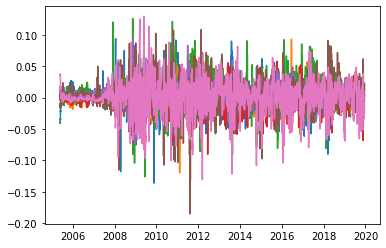

In [29]:
plt.plot(Date, HKhat1-HK)

In [31]:
junk = np.var(HKhat1,axis=0)

junk1 = np.var(HK, axis= 0)

ERROR = HKhat1 -HK
SEE = np.sum(ERROR**2, axis=0)
SEE1 = np.sum(SEE)
print(SEE1)
RSQ_HK_NPC = junk/junk1
print(RSQ_HK_NPC)
print(np.min(RSQ_HK_NPC))

# Format the dates as 'YYYY-MM-DD'


10.054894130812801
[0.99695855 1.02744926 1.00450346 1.00021183 1.01656956 0.98728748
 0.99958351]
0.987287475452827


- We see that the min value of the NPC $R^2$ is .96, almost twice as good at the PC.  

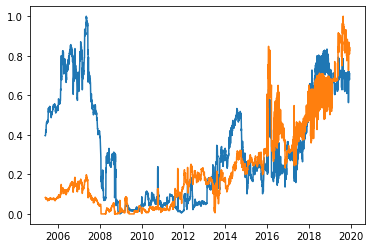

In [33]:
encoded_HK= scaler.fit_transform(encoded_HK)
plt.plot(Date, encoded_HK)

- We plot the difference between the PC and Autoencoded Signals

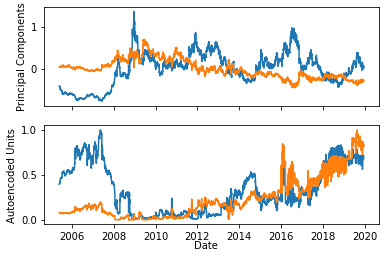

In [34]:

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot the first subplot
ax1.plot(Date, PC)
ax1.set_ylabel('Principal Components')

# Plot the second subplot
ax2.plot(Date, encoded_HK)
ax2.set_ylabel('Autoencoded Units')

# Add a common x-axis label
fig.text(0.5, 0.04, 'Date', ha='center')

# Set the y-axis limits to be the same on both subplots


plt.show()







In [35]:
print(np.std(encoded_HK,0))
print(np.std(PC,0))

[0.26384184 0.23017016]
[0.3942765  0.22138662]


- We see that the standard deviations are lower for the first two principal components of Autoencoder relative the PC.
- We also see the in-sample $R^2$ statistics for the Autoencoder relative to the PC
- Not suprisingly, the NPC always gives better in-sample performance.

In [36]:
print(RSQ_HK_NPC)
print(RSQ_PC_HK)

[0.99695855 1.02744926 1.00450346 1.00021183 1.01656956 0.98728748
 0.99958351]
[0.85894373 0.96162456 0.84353158 0.95964647 0.97622294 0.91419614
 0.80602972]


- Of course, the real proof of the pudding is in out of sample prediction, especially with rolling window regression.


- Let's train the autoencoder with the training set data and see how it performs on the test set data.

In [37]:
# Train the autoencoder
autoencoder.fit(HKtrain, HKtrain, epochs=10000)

# Extract the encoder model for dimensionality reduction
encoder = Model(inputs, encoded)
#encoded_HK = encoder.predict(HK)

Epoch 1/10000
95/95 [==============================] - 0s 817us/step - loss: 3.7705e-04
Epoch 2/10000
95/95 [==============================] - 0s 775us/step - loss: 3.7761e-04
Epoch 3/10000
95/95 [==============================] - 0s 785us/step - loss: 3.7998e-04
Epoch 4/10000
95/95 [==============================] - 0s 775us/step - loss: 3.8023e-04
Epoch 5/10000
95/95 [==============================] - 0s 785us/step - loss: 3.8159e-04
Epoch 6/10000
95/95 [==============================] - 0s 775us/step - loss: 3.8152e-04
Epoch 7/10000
95/95 [==============================] - 0s 775us/step - loss: 3.8105e-04
Epoch 8/10000
95/95 [==============================] - 0s 785us/step - loss: 3.8251e-04
Epoch 9/10000
95/95 [==============================] - 0s 785us/step - loss: 3.8360e-04
Epoch 10/10000
95/95 [==============================] - 0s 775us/step - loss: 3.7996e-04
Epoch 11/10000
95/95 [==============================] - 0s 785us/step - loss: 3.8458e-04
Epoch 12/10000
95/95 [========

95/95 [==============================] - 0s 785us/step - loss: 3.7403e-04
Epoch 94/10000
95/95 [==============================] - 0s 775us/step - loss: 3.7835e-04
Epoch 95/10000
95/95 [==============================] - 0s 764us/step - loss: 3.7478e-04
Epoch 96/10000
95/95 [==============================] - 0s 775us/step - loss: 3.7476e-04
Epoch 97/10000
95/95 [==============================] - 0s 775us/step - loss: 3.7902e-04
Epoch 98/10000
95/95 [==============================] - 0s 764us/step - loss: 3.8101e-04
Epoch 99/10000
95/95 [==============================] - 0s 785us/step - loss: 3.7986e-04
Epoch 100/10000
95/95 [==============================] - 0s 764us/step - loss: 3.7244e-04
Epoch 101/10000
95/95 [==============================] - 0s 775us/step - loss: 3.7987e-04
Epoch 102/10000
95/95 [==============================] - 0s 764us/step - loss: 3.8772e-04
Epoch 103/10000
95/95 [==============================] - 0s 775us/step - loss: 3.8175e-04
Epoch 104/10000
95/95 [=========

95/95 [==============================] - 0s 775us/step - loss: 3.7627e-04
Epoch 185/10000
95/95 [==============================] - 0s 785us/step - loss: 3.7099e-04
Epoch 186/10000
95/95 [==============================] - 0s 785us/step - loss: 3.9587e-04
Epoch 187/10000
95/95 [==============================] - 0s 828us/step - loss: 3.7117e-04
Epoch 188/10000
95/95 [==============================] - 0s 796us/step - loss: 3.7426e-04
Epoch 189/10000
95/95 [==============================] - 0s 785us/step - loss: 3.7842e-04
Epoch 190/10000
95/95 [==============================] - 0s 775us/step - loss: 3.7657e-04
Epoch 191/10000
95/95 [==============================] - 0s 764us/step - loss: 3.8454e-04
Epoch 192/10000
95/95 [==============================] - 0s 764us/step - loss: 3.7170e-04
Epoch 193/10000
95/95 [==============================] - 0s 775us/step - loss: 3.8372e-04
Epoch 194/10000
95/95 [==============================] - 0s 775us/step - loss: 3.7148e-04
Epoch 195/10000
95/95 [===

95/95 [==============================] - 0s 785us/step - loss: 3.8834e-04
Epoch 276/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6824e-04
Epoch 277/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6868e-04
Epoch 278/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6887e-04
Epoch 279/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6763e-04
Epoch 280/10000
95/95 [==============================] - 0s 753us/step - loss: 3.7835e-04
Epoch 281/10000
95/95 [==============================] - 0s 753us/step - loss: 3.8733e-04
Epoch 282/10000
95/95 [==============================] - 0s 764us/step - loss: 3.7694e-04
Epoch 283/10000
95/95 [==============================] - 0s 764us/step - loss: 3.7609e-04
Epoch 284/10000
95/95 [==============================] - 0s 796us/step - loss: 3.6597e-04
Epoch 285/10000
95/95 [==============================] - 0s 934us/step - loss: 3.7388e-04
Epoch 286/10000
95/95 [===

95/95 [==============================] - 0s 784us/step - loss: 3.7354e-04
Epoch 367/10000
95/95 [==============================] - 0s 785us/step - loss: 3.7176e-04
Epoch 368/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6877e-04
Epoch 369/10000
95/95 [==============================] - 0s 775us/step - loss: 3.7350e-04
Epoch 370/10000
95/95 [==============================] - 0s 764us/step - loss: 3.7758e-04
Epoch 371/10000
95/95 [==============================] - 0s 785us/step - loss: 3.7028e-04
Epoch 372/10000
95/95 [==============================] - 0s 764us/step - loss: 3.7395e-04
Epoch 373/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6857e-04
Epoch 374/10000
95/95 [==============================] - 0s 788us/step - loss: 3.6918e-04
Epoch 375/10000
95/95 [==============================] - 0s 797us/step - loss: 3.6762e-04
Epoch 376/10000
95/95 [==============================] - 0s 774us/step - loss: 3.7237e-04
Epoch 377/10000
95/95 [===

95/95 [==============================] - 0s 793us/step - loss: 3.6829e-04
Epoch 458/10000
95/95 [==============================] - 0s 772us/step - loss: 3.6684e-04
Epoch 459/10000
95/95 [==============================] - 0s 825us/step - loss: 3.7391e-04
Epoch 460/10000
95/95 [==============================] - 0s 773us/step - loss: 3.7352e-04
Epoch 461/10000
95/95 [==============================] - 0s 817us/step - loss: 3.6812e-04
Epoch 462/10000
95/95 [==============================] - 0s 785us/step - loss: 3.7589e-04
Epoch 463/10000
95/95 [==============================] - 0s 796us/step - loss: 3.7656e-04
Epoch 464/10000
95/95 [==============================] - 0s 775us/step - loss: 3.6895e-04
Epoch 465/10000
95/95 [==============================] - 0s 785us/step - loss: 3.7141e-04
Epoch 466/10000
95/95 [==============================] - 0s 783us/step - loss: 3.7197e-04
Epoch 467/10000
95/95 [==============================] - 0s 775us/step - loss: 3.7597e-04
Epoch 468/10000
95/95 [===

95/95 [==============================] - 0s 810us/step - loss: 3.7364e-04
Epoch 549/10000
95/95 [==============================] - 0s 775us/step - loss: 3.6350e-04
Epoch 550/10000
95/95 [==============================] - 0s 806us/step - loss: 3.6284e-04
Epoch 551/10000
95/95 [==============================] - 0s 785us/step - loss: 3.6458e-04
Epoch 552/10000
95/95 [==============================] - 0s 796us/step - loss: 3.7254e-04
Epoch 553/10000
95/95 [==============================] - 0s 785us/step - loss: 3.7053e-04
Epoch 554/10000
95/95 [==============================] - 0s 785us/step - loss: 3.7065e-04
Epoch 555/10000
95/95 [==============================] - 0s 785us/step - loss: 3.7197e-04
Epoch 556/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6993e-04
Epoch 557/10000
95/95 [==============================] - 0s 785us/step - loss: 3.7507e-04
Epoch 558/10000
95/95 [==============================] - 0s 775us/step - loss: 3.6668e-04
Epoch 559/10000
95/95 [===

95/95 [==============================] - 0s 796us/step - loss: 3.6374e-04
Epoch 640/10000
95/95 [==============================] - 0s 775us/step - loss: 3.6473e-04
Epoch 641/10000
95/95 [==============================] - 0s 785us/step - loss: 3.6581e-04
Epoch 642/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6823e-04
Epoch 643/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6649e-04
Epoch 644/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6733e-04
Epoch 645/10000
95/95 [==============================] - 0s 775us/step - loss: 3.7396e-04
Epoch 646/10000
95/95 [==============================] - 0s 775us/step - loss: 3.7323e-04
Epoch 647/10000
95/95 [==============================] - 0s 775us/step - loss: 3.6284e-04
Epoch 648/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6267e-04
Epoch 649/10000
95/95 [==============================] - 0s 775us/step - loss: 3.7099e-04
Epoch 650/10000
95/95 [===

95/95 [==============================] - 0s 764us/step - loss: 3.6514e-04
Epoch 731/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6495e-04
Epoch 732/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6680e-04
Epoch 733/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6855e-04
Epoch 734/10000
95/95 [==============================] - 0s 785us/step - loss: 3.7178e-04
Epoch 735/10000
95/95 [==============================] - 0s 785us/step - loss: 3.6560e-04
Epoch 736/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6273e-04
Epoch 737/10000
95/95 [==============================] - 0s 753us/step - loss: 3.7129e-04
Epoch 738/10000
95/95 [==============================] - 0s 775us/step - loss: 3.6467e-04
Epoch 739/10000
95/95 [==============================] - 0s 796us/step - loss: 3.7041e-04
Epoch 740/10000
95/95 [==============================] - 0s 764us/step - loss: 3.7176e-04
Epoch 741/10000
95/95 [===

95/95 [==============================] - 0s 758us/step - loss: 3.7076e-04
Epoch 822/10000
95/95 [==============================] - 0s 766us/step - loss: 3.6900e-04
Epoch 823/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6613e-04
Epoch 824/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6493e-04
Epoch 825/10000
95/95 [==============================] - 0s 775us/step - loss: 3.6879e-04
Epoch 826/10000
95/95 [==============================] - 0s 806us/step - loss: 3.7420e-04
Epoch 827/10000
95/95 [==============================] - 0s 856us/step - loss: 3.5962e-04
Epoch 828/10000
95/95 [==============================] - 0s 770us/step - loss: 3.7051e-04
Epoch 829/10000
95/95 [==============================] - 0s 812us/step - loss: 3.6402e-04
Epoch 830/10000
95/95 [==============================] - 0s 806us/step - loss: 3.6696e-04
Epoch 831/10000
95/95 [==============================] - 0s 785us/step - loss: 3.6337e-04
Epoch 832/10000
95/95 [===

95/95 [==============================] - 0s 784us/step - loss: 3.6499e-04
Epoch 913/10000
95/95 [==============================] - 0s 776us/step - loss: 3.6982e-04
Epoch 914/10000
95/95 [==============================] - 0s 775us/step - loss: 3.6178e-04
Epoch 915/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6645e-04
Epoch 916/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6766e-04
Epoch 917/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6159e-04
Epoch 918/10000
95/95 [==============================] - 0s 764us/step - loss: 3.7654e-04
Epoch 919/10000
95/95 [==============================] - 0s 764us/step - loss: 3.7051e-04
Epoch 920/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6791e-04
Epoch 921/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6651e-04
Epoch 922/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6481e-04
Epoch 923/10000
95/95 [===

95/95 [==============================] - 0s 764us/step - loss: 3.8162e-04
Epoch 1004/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6307e-04
Epoch 1005/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6333e-04
Epoch 1006/10000
95/95 [==============================] - 0s 753us/step - loss: 3.7589e-04
Epoch 1007/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6587e-04
Epoch 1008/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6452e-04
Epoch 1009/10000
95/95 [==============================] - 0s 785us/step - loss: 3.6398e-04
Epoch 1010/10000
95/95 [==============================] - 0s 838us/step - loss: 3.7015e-04
Epoch 1011/10000
95/95 [==============================] - 0s 828us/step - loss: 3.6736e-04
Epoch 1012/10000
95/95 [==============================] - 0s 817us/step - loss: 3.6197e-04
Epoch 1013/10000
95/95 [==============================] - 0s 773us/step - loss: 3.5849e-04
Epoch 1014/10000

95/95 [==============================] - 0s 764us/step - loss: 3.6270e-04
Epoch 1094/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6317e-04
Epoch 1095/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6148e-04
Epoch 1096/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6413e-04
Epoch 1097/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6516e-04
Epoch 1098/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6453e-04
Epoch 1099/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5399e-04
Epoch 1100/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5905e-04
Epoch 1101/10000
95/95 [==============================] - 0s 775us/step - loss: 3.6478e-04
Epoch 1102/10000
95/95 [==============================] - 0s 753us/step - loss: 3.7403e-04
Epoch 1103/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6138e-04
Epoch 1104/10000

95/95 [==============================] - 0s 838us/step - loss: 3.5614e-04
Epoch 1184/10000
95/95 [==============================] - 0s 870us/step - loss: 3.6528e-04
Epoch 1185/10000
95/95 [==============================] - 0s 859us/step - loss: 3.6547e-04
Epoch 1186/10000
95/95 [==============================] - 0s 870us/step - loss: 3.6412e-04
Epoch 1187/10000
95/95 [==============================] - 0s 859us/step - loss: 3.6110e-04
Epoch 1188/10000
95/95 [==============================] - 0s 818us/step - loss: 3.6652e-04
Epoch 1189/10000
95/95 [==============================] - 0s 870us/step - loss: 3.6191e-04
Epoch 1190/10000
95/95 [==============================] - 0s 828us/step - loss: 3.6778e-04
Epoch 1191/10000
95/95 [==============================] - 0s 838us/step - loss: 3.6292e-04
Epoch 1192/10000
95/95 [==============================] - 0s 817us/step - loss: 3.6275e-04
Epoch 1193/10000
95/95 [==============================] - 0s 828us/step - loss: 3.6108e-04
Epoch 1194/10000

95/95 [==============================] - 0s 753us/step - loss: 3.6450e-04
Epoch 1274/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6956e-04
Epoch 1275/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5779e-04
Epoch 1276/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5622e-04
Epoch 1277/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5697e-04
Epoch 1278/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6611e-04
Epoch 1279/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6778e-04
Epoch 1280/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6223e-04
Epoch 1281/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6447e-04
Epoch 1282/10000
95/95 [==============================] - 0s 806us/step - loss: 3.5791e-04
Epoch 1283/10000
95/95 [==============================] - 0s 851us/step - loss: 3.5838e-04
Epoch 1284/10000

95/95 [==============================] - 0s 806us/step - loss: 3.6529e-04
Epoch 1364/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6408e-04
Epoch 1365/10000
95/95 [==============================] - 0s 764us/step - loss: 4.3347e-04
Epoch 1366/10000
95/95 [==============================] - 0s 839us/step - loss: 4.8574e-04
Epoch 1367/10000
95/95 [==============================] - 0s 891us/step - loss: 3.8051e-04
Epoch 1368/10000
95/95 [==============================] - 0s 827us/step - loss: 3.7295e-04
Epoch 1369/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6830e-04
Epoch 1370/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6423e-04
Epoch 1371/10000
95/95 [==============================] - 0s 806us/step - loss: 3.6075e-04
Epoch 1372/10000
95/95 [==============================] - 0s 817us/step - loss: 3.5905e-04
Epoch 1373/10000
95/95 [==============================] - 0s 828us/step - loss: 3.5580e-04
Epoch 1374/10000

95/95 [==============================] - 0s 753us/step - loss: 3.5966e-04
Epoch 1454/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6089e-04
Epoch 1455/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5473e-04
Epoch 1456/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5715e-04
Epoch 1457/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6745e-04
Epoch 1458/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5362e-04
Epoch 1459/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5605e-04
Epoch 1460/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5954e-04
Epoch 1461/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6155e-04
Epoch 1462/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6398e-04
Epoch 1463/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5737e-04
Epoch 1464/10000

95/95 [==============================] - 0s 764us/step - loss: 3.6059e-04
Epoch 1544/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5614e-04
Epoch 1545/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5423e-04
Epoch 1546/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5937e-04
Epoch 1547/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6718e-04
Epoch 1548/10000
95/95 [==============================] - 0s 796us/step - loss: 3.5437e-04
Epoch 1549/10000
95/95 [==============================] - 0s 806us/step - loss: 3.5906e-04
Epoch 1550/10000
95/95 [==============================] - 0s 817us/step - loss: 3.6071e-04
Epoch 1551/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6250e-04
Epoch 1552/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5917e-04
Epoch 1553/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6330e-04
Epoch 1554/10000

95/95 [==============================] - 0s 764us/step - loss: 3.7755e-04
Epoch 1634/10000
95/95 [==============================] - 0s 775us/step - loss: 3.5335e-04
Epoch 1635/10000
95/95 [==============================] - 0s 774us/step - loss: 3.6074e-04
Epoch 1636/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5673e-04
Epoch 1637/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5578e-04
Epoch 1638/10000
95/95 [==============================] - 0s 821us/step - loss: 3.6660e-04
Epoch 1639/10000
95/95 [==============================] - 0s 775us/step - loss: 3.5573e-04
Epoch 1640/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5893e-04
Epoch 1641/10000
95/95 [==============================] - 0s 775us/step - loss: 3.5729e-04
Epoch 1642/10000
95/95 [==============================] - 0s 743us/step - loss: 3.5643e-04
Epoch 1643/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5680e-04
Epoch 1644/10000

95/95 [==============================] - 0s 775us/step - loss: 3.5503e-04
Epoch 1724/10000
95/95 [==============================] - 0s 775us/step - loss: 3.6183e-04
Epoch 1725/10000
95/95 [==============================] - 0s 817us/step - loss: 3.6588e-04
Epoch 1726/10000
95/95 [==============================] - 0s 838us/step - loss: 3.5624e-04
Epoch 1727/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5550e-04
Epoch 1728/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5694e-04
Epoch 1729/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5952e-04
Epoch 1730/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5698e-04
Epoch 1731/10000
95/95 [==============================] - 0s 775us/step - loss: 3.5641e-04
Epoch 1732/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5930e-04
Epoch 1733/10000
95/95 [==============================] - 0s 775us/step - loss: 3.6037e-04
Epoch 1734/10000

95/95 [==============================] - 0s 764us/step - loss: 3.6568e-04
Epoch 1814/10000
95/95 [==============================] - 0s 775us/step - loss: 3.5800e-04
Epoch 1815/10000
95/95 [==============================] - 0s 775us/step - loss: 3.5144e-04
Epoch 1816/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6282e-04
Epoch 1817/10000
95/95 [==============================] - 0s 774us/step - loss: 3.6020e-04
Epoch 1818/10000
95/95 [==============================] - 0s 785us/step - loss: 3.6029e-04
Epoch 1819/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5187e-04
Epoch 1820/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4935e-04
Epoch 1821/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5260e-04
Epoch 1822/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5771e-04
Epoch 1823/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5428e-04
Epoch 1824/10000

95/95 [==============================] - 0s 764us/step - loss: 3.6290e-04
Epoch 1904/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5645e-04
Epoch 1905/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6082e-04
Epoch 1906/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5974e-04
Epoch 1907/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5079e-04
Epoch 1908/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5358e-04
Epoch 1909/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5052e-04
Epoch 1910/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5869e-04
Epoch 1911/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5680e-04
Epoch 1912/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5636e-04
Epoch 1913/10000
95/95 [==============================] - 0s 798us/step - loss: 3.5190e-04
Epoch 1914/10000

95/95 [==============================] - 0s 764us/step - loss: 3.4784e-04
Epoch 1994/10000
95/95 [==============================] - 0s 817us/step - loss: 3.5070e-04
Epoch 1995/10000
95/95 [==============================] - 0s 828us/step - loss: 3.5510e-04
Epoch 1996/10000
95/95 [==============================] - 0s 785us/step - loss: 3.6888e-04
Epoch 1997/10000
95/95 [==============================] - 0s 859us/step - loss: 3.6357e-04
Epoch 1998/10000
95/95 [==============================] - 0s 862us/step - loss: 3.5671e-04
Epoch 1999/10000
95/95 [==============================] - 0s 834us/step - loss: 3.5744e-04
Epoch 2000/10000
95/95 [==============================] - 0s 777us/step - loss: 3.6118e-04
Epoch 2001/10000
95/95 [==============================] - 0s 743us/step - loss: 3.6950e-04
Epoch 2002/10000
95/95 [==============================] - 0s 743us/step - loss: 3.5350e-04
Epoch 2003/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5829e-04
Epoch 2004/10000

95/95 [==============================] - 0s 753us/step - loss: 3.5725e-04
Epoch 2084/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5684e-04
Epoch 2085/10000
95/95 [==============================] - 0s 796us/step - loss: 3.4767e-04
Epoch 2086/10000
95/95 [==============================] - 0s 772us/step - loss: 3.5265e-04
Epoch 2087/10000
95/95 [==============================] - 0s 796us/step - loss: 3.5277e-04
Epoch 2088/10000
95/95 [==============================] - 0s 796us/step - loss: 3.5677e-04
Epoch 2089/10000
95/95 [==============================] - 0s 806us/step - loss: 3.5213e-04
Epoch 2090/10000
95/95 [==============================] - 0s 785us/step - loss: 3.5651e-04
Epoch 2091/10000
95/95 [==============================] - 0s 796us/step - loss: 3.5897e-04
Epoch 2092/10000
95/95 [==============================] - 0s 743us/step - loss: 3.6201e-04
Epoch 2093/10000
95/95 [==============================] - 0s 743us/step - loss: 3.6591e-04
Epoch 2094/10000

95/95 [==============================] - 0s 764us/step - loss: 3.4999e-04
Epoch 2174/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5191e-04
Epoch 2175/10000
95/95 [==============================] - 0s 753us/step - loss: 3.7748e-04
Epoch 2176/10000
95/95 [==============================] - 0s 743us/step - loss: 3.6520e-04
Epoch 2177/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5681e-04
Epoch 2178/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6175e-04
Epoch 2179/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4720e-04
Epoch 2180/10000
95/95 [==============================] - 0s 743us/step - loss: 3.4788e-04
Epoch 2181/10000
95/95 [==============================] - 0s 743us/step - loss: 3.5612e-04
Epoch 2182/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5226e-04
Epoch 2183/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5027e-04
Epoch 2184/10000

95/95 [==============================] - 0s 764us/step - loss: 3.5077e-04
Epoch 2264/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5127e-04
Epoch 2265/10000
95/95 [==============================] - 0s 765us/step - loss: 3.4857e-04
Epoch 2266/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4935e-04
Epoch 2267/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5953e-04
Epoch 2268/10000
95/95 [==============================] - 0s 743us/step - loss: 3.5482e-04
Epoch 2269/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5105e-04
Epoch 2270/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6349e-04
Epoch 2271/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5471e-04
Epoch 2272/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5720e-04
Epoch 2273/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5295e-04
Epoch 2274/10000

95/95 [==============================] - 0s 764us/step - loss: 3.4943e-04
Epoch 2354/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5228e-04
Epoch 2355/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4925e-04
Epoch 2356/10000
95/95 [==============================] - 0s 754us/step - loss: 3.5840e-04
Epoch 2357/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5231e-04
Epoch 2358/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5771e-04
Epoch 2359/10000
95/95 [==============================] - 0s 761us/step - loss: 3.4543e-04
Epoch 2360/10000
95/95 [==============================] - 0s 765us/step - loss: 3.4974e-04
Epoch 2361/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6361e-04
Epoch 2362/10000
95/95 [==============================] - 0s 779us/step - loss: 3.5580e-04
Epoch 2363/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5592e-04
Epoch 2364/10000

95/95 [==============================] - 0s 764us/step - loss: 3.5826e-04
Epoch 2444/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4824e-04
Epoch 2445/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6860e-04
Epoch 2446/10000
95/95 [==============================] - 0s 753us/step - loss: 3.7655e-04
Epoch 2447/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5105e-04
Epoch 2448/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5651e-04
Epoch 2449/10000
95/95 [==============================] - 0s 743us/step - loss: 3.4955e-04
Epoch 2450/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5167e-04
Epoch 2451/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5389e-04
Epoch 2452/10000
95/95 [==============================] - 0s 775us/step - loss: 3.5037e-04
Epoch 2453/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4912e-04
Epoch 2454/10000

95/95 [==============================] - 0s 764us/step - loss: 3.5120e-04
Epoch 2534/10000
95/95 [==============================] - 0s 864us/step - loss: 3.4688e-04
Epoch 2535/10000
95/95 [==============================] - 0s 828us/step - loss: 3.5282e-04
Epoch 2536/10000
95/95 [==============================] - 0s 796us/step - loss: 3.5085e-04
Epoch 2537/10000
95/95 [==============================] - 0s 786us/step - loss: 3.4549e-04
Epoch 2538/10000
95/95 [==============================] - 0s 779us/step - loss: 3.5626e-04
Epoch 2539/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4479e-04
Epoch 2540/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4609e-04
Epoch 2541/10000
95/95 [==============================] - 0s 766us/step - loss: 3.5241e-04
Epoch 2542/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5223e-04
Epoch 2543/10000
95/95 [==============================] - 0s 806us/step - loss: 3.5518e-04
Epoch 2544/10000

95/95 [==============================] - 0s 785us/step - loss: 3.5348e-04
Epoch 2624/10000
95/95 [==============================] - 0s 796us/step - loss: 3.4551e-04
Epoch 2625/10000
95/95 [==============================] - 0s 806us/step - loss: 3.4750e-04
Epoch 2626/10000
95/95 [==============================] - 0s 817us/step - loss: 3.4905e-04
Epoch 2627/10000
95/95 [==============================] - 0s 796us/step - loss: 3.5496e-04
Epoch 2628/10000
95/95 [==============================] - 0s 775us/step - loss: 3.5076e-04
Epoch 2629/10000
95/95 [==============================] - 0s 785us/step - loss: 3.4871e-04
Epoch 2630/10000
95/95 [==============================] - 0s 785us/step - loss: 3.5373e-04
Epoch 2631/10000
95/95 [==============================] - 0s 774us/step - loss: 3.5850e-04
Epoch 2632/10000
95/95 [==============================] - 0s 785us/step - loss: 3.6154e-04
Epoch 2633/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4879e-04
Epoch 2634/10000

95/95 [==============================] - 0s 775us/step - loss: 3.5340e-04
Epoch 2714/10000
95/95 [==============================] - 0s 775us/step - loss: 3.5425e-04
Epoch 2715/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6842e-04
Epoch 2716/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4356e-04
Epoch 2717/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5411e-04
Epoch 2718/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4800e-04
Epoch 2719/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4992e-04
Epoch 2720/10000
95/95 [==============================] - 0s 874us/step - loss: 3.4822e-04
Epoch 2721/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4610e-04
Epoch 2722/10000
95/95 [==============================] - 0s 775us/step - loss: 3.5091e-04
Epoch 2723/10000
95/95 [==============================] - 0s 798us/step - loss: 3.4854e-04
Epoch 2724/10000

95/95 [==============================] - 0s 785us/step - loss: 3.5458e-04
Epoch 2804/10000
95/95 [==============================] - 0s 775us/step - loss: 3.5453e-04
Epoch 2805/10000
95/95 [==============================] - 0s 784us/step - loss: 3.4709e-04
Epoch 2806/10000
95/95 [==============================] - 0s 781us/step - loss: 3.5565e-04
Epoch 2807/10000
95/95 [==============================] - 0s 817us/step - loss: 3.4890e-04
Epoch 2808/10000
95/95 [==============================] - 0s 769us/step - loss: 4.0629e-04
Epoch 2809/10000
95/95 [==============================] - 0s 775us/step - loss: 3.5676e-04
Epoch 2810/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4039e-04
Epoch 2811/10000
95/95 [==============================] - 0s 775us/step - loss: 3.5166e-04
Epoch 2812/10000
95/95 [==============================] - 0s 783us/step - loss: 3.4995e-04
Epoch 2813/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4474e-04
Epoch 2814/10000

95/95 [==============================] - 0s 792us/step - loss: 3.5399e-04
Epoch 2894/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5035e-04
Epoch 2895/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5193e-04
Epoch 2896/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4287e-04
Epoch 2897/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4525e-04
Epoch 2898/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5259e-04
Epoch 2899/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4427e-04
Epoch 2900/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5117e-04
Epoch 2901/10000
95/95 [==============================] - 0s 756us/step - loss: 3.4868e-04
Epoch 2902/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4969e-04
Epoch 2903/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5323e-04
Epoch 2904/10000

95/95 [==============================] - 0s 764us/step - loss: 3.4935e-04
Epoch 2984/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5678e-04
Epoch 2985/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4336e-04
Epoch 2986/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4497e-04
Epoch 2987/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4161e-04
Epoch 2988/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4215e-04
Epoch 2989/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5706e-04
Epoch 2990/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5018e-04
Epoch 2991/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4348e-04
Epoch 2992/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5025e-04
Epoch 2993/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4541e-04
Epoch 2994/10000

95/95 [==============================] - 0s 759us/step - loss: 3.4973e-04
Epoch 3074/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6723e-04
Epoch 3075/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4566e-04
Epoch 3076/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4468e-04
Epoch 3077/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4595e-04
Epoch 3078/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4344e-04
Epoch 3079/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4032e-04
Epoch 3080/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5039e-04
Epoch 3081/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4486e-04
Epoch 3082/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4837e-04
Epoch 3083/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4905e-04
Epoch 3084/10000

95/95 [==============================] - 0s 753us/step - loss: 3.4242e-04
Epoch 3164/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4398e-04
Epoch 3165/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4162e-04
Epoch 3166/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4390e-04
Epoch 3167/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4000e-04
Epoch 3168/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4079e-04
Epoch 3169/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4291e-04
Epoch 3170/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4002e-04
Epoch 3171/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4265e-04
Epoch 3172/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4365e-04
Epoch 3173/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4934e-04
Epoch 3174/10000

95/95 [==============================] - 0s 775us/step - loss: 3.4780e-04
Epoch 3254/10000
95/95 [==============================] - 0s 770us/step - loss: 3.4175e-04
Epoch 3255/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4383e-04
Epoch 3256/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4507e-04
Epoch 3257/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4459e-04
Epoch 3258/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4163e-04
Epoch 3259/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5215e-04
Epoch 3260/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4662e-04
Epoch 3261/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4472e-04
Epoch 3262/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4555e-04
Epoch 3263/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4027e-04
Epoch 3264/10000

95/95 [==============================] - 0s 785us/step - loss: 3.4935e-04
Epoch 3344/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5607e-04
Epoch 3345/10000
95/95 [==============================] - 0s 775us/step - loss: 3.5214e-04
Epoch 3346/10000
95/95 [==============================] - 0s 814us/step - loss: 3.5117e-04
Epoch 3347/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4333e-04
Epoch 3348/10000
95/95 [==============================] - 0s 787us/step - loss: 3.5221e-04
Epoch 3349/10000
95/95 [==============================] - 0s 782us/step - loss: 3.5349e-04
Epoch 3350/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4299e-04
Epoch 3351/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5036e-04
Epoch 3352/10000
95/95 [==============================] - 0s 785us/step - loss: 3.4133e-04
Epoch 3353/10000
95/95 [==============================] - 0s 796us/step - loss: 3.4514e-04
Epoch 3354/10000

95/95 [==============================] - 0s 849us/step - loss: 3.4461e-04
Epoch 3434/10000
95/95 [==============================] - 0s 923us/step - loss: 3.4830e-04
Epoch 3435/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4304e-04
Epoch 3436/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3612e-04
Epoch 3437/10000
95/95 [==============================] - 0s 806us/step - loss: 3.3984e-04
Epoch 3438/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4429e-04
Epoch 3439/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4988e-04
Epoch 3440/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4417e-04
Epoch 3441/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4208e-04
Epoch 3442/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4916e-04
Epoch 3443/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3967e-04
Epoch 3444/10000

95/95 [==============================] - 0s 764us/step - loss: 3.4408e-04
Epoch 3524/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3995e-04
Epoch 3525/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4301e-04
Epoch 3526/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4485e-04
Epoch 3527/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4571e-04
Epoch 3528/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4742e-04
Epoch 3529/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5021e-04
Epoch 3530/10000
95/95 [==============================] - 0s 785us/step - loss: 3.4443e-04
Epoch 3531/10000
95/95 [==============================] - 0s 791us/step - loss: 3.4279e-04
Epoch 3532/10000
95/95 [==============================] - 0s 748us/step - loss: 3.3978e-04
Epoch 3533/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3687e-04
Epoch 3534/10000

95/95 [==============================] - 0s 764us/step - loss: 3.3389e-04
Epoch 3614/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4031e-04
Epoch 3615/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4127e-04
Epoch 3616/10000
95/95 [==============================] - 0s 796us/step - loss: 3.3693e-04
Epoch 3617/10000
95/95 [==============================] - 0s 766us/step - loss: 3.3720e-04
Epoch 3618/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3958e-04
Epoch 3619/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3604e-04
Epoch 3620/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4338e-04
Epoch 3621/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3882e-04
Epoch 3622/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4427e-04
Epoch 3623/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3749e-04
Epoch 3624/10000

95/95 [==============================] - 0s 774us/step - loss: 3.5105e-04
Epoch 3704/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4666e-04
Epoch 3705/10000
95/95 [==============================] - 0s 775us/step - loss: 3.5416e-04
Epoch 3706/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4534e-04
Epoch 3707/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3835e-04
Epoch 3708/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4783e-04
Epoch 3709/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3863e-04
Epoch 3710/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3951e-04
Epoch 3711/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3942e-04
Epoch 3712/10000
95/95 [==============================] - 0s 753us/step - loss: 3.5120e-04
Epoch 3713/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4349e-04
Epoch 3714/10000

95/95 [==============================] - 0s 806us/step - loss: 3.4253e-04
Epoch 3794/10000
95/95 [==============================] - 0s 806us/step - loss: 3.4219e-04
Epoch 3795/10000
95/95 [==============================] - 0s 765us/step - loss: 3.4731e-04
Epoch 3796/10000
95/95 [==============================] - 0s 785us/step - loss: 3.4154e-04
Epoch 3797/10000
95/95 [==============================] - 0s 881us/step - loss: 3.4330e-04
Epoch 3798/10000
95/95 [==============================] - 0s 859us/step - loss: 3.3350e-04
Epoch 3799/10000
95/95 [==============================] - 0s 806us/step - loss: 3.3753e-04
Epoch 3800/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3809e-04
Epoch 3801/10000
95/95 [==============================] - 0s 785us/step - loss: 3.4178e-04
Epoch 3802/10000
95/95 [==============================] - 0s 806us/step - loss: 3.4783e-04
Epoch 3803/10000
95/95 [==============================] - 0s 785us/step - loss: 3.4123e-04
Epoch 3804/10000

95/95 [==============================] - 0s 764us/step - loss: 3.3431e-04
Epoch 3884/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4002e-04
Epoch 3885/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4441e-04
Epoch 3886/10000
95/95 [==============================] - 0s 796us/step - loss: 3.3762e-04
Epoch 3887/10000
95/95 [==============================] - 0s 955us/step - loss: 3.4090e-04
Epoch 3888/10000
95/95 [==============================] - 0s 796us/step - loss: 3.4110e-04
Epoch 3889/10000
95/95 [==============================] - 0s 806us/step - loss: 3.3540e-04
Epoch 3890/10000
95/95 [==============================] - 0s 870us/step - loss: 3.4099e-04
Epoch 3891/10000
95/95 [==============================] - 0s 849us/step - loss: 3.4447e-04
Epoch 3892/10000
95/95 [==============================] - 0s 881us/step - loss: 3.3720e-04
Epoch 3893/10000
95/95 [==============================] - 0s 870us/step - loss: 3.3628e-04
Epoch 3894/10000

95/95 [==============================] - 0s 775us/step - loss: 3.3737e-04
Epoch 3974/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3287e-04
Epoch 3975/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4029e-04
Epoch 3976/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3821e-04
Epoch 3977/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3931e-04
Epoch 3978/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4141e-04
Epoch 3979/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4378e-04
Epoch 3980/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4455e-04
Epoch 3981/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3873e-04
Epoch 3982/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3708e-04
Epoch 3983/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4291e-04
Epoch 3984/10000

95/95 [==============================] - 0s 775us/step - loss: 3.4117e-04
Epoch 4064/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4287e-04
Epoch 4065/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4143e-04
Epoch 4066/10000
95/95 [==============================] - 0s 806us/step - loss: 3.4797e-04
Epoch 4067/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4863e-04
Epoch 4068/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4186e-04
Epoch 4069/10000
95/95 [==============================] - 0s 849us/step - loss: 3.3356e-04
Epoch 4070/10000
95/95 [==============================] - 0s 849us/step - loss: 3.3691e-04
Epoch 4071/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3552e-04
Epoch 4072/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4115e-04
Epoch 4073/10000
95/95 [==============================] - 0s 785us/step - loss: 3.3616e-04
Epoch 4074/10000

95/95 [==============================] - 0s 775us/step - loss: 3.3171e-04
Epoch 4154/10000
95/95 [==============================] - 0s 785us/step - loss: 3.3650e-04
Epoch 4155/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3822e-04
Epoch 4156/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3887e-04
Epoch 4157/10000
95/95 [==============================] - 0s 791us/step - loss: 3.4173e-04
Epoch 4158/10000
95/95 [==============================] - 0s 806us/step - loss: 3.3856e-04
Epoch 4159/10000
95/95 [==============================] - 0s 768us/step - loss: 3.3943e-04
Epoch 4160/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3991e-04
Epoch 4161/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4485e-04
Epoch 4162/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5670e-04
Epoch 4163/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3674e-04
Epoch 4164/10000

95/95 [==============================] - 0s 775us/step - loss: 3.3895e-04
Epoch 4244/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3891e-04
Epoch 4245/10000
95/95 [==============================] - 0s 753us/step - loss: 3.4278e-04
Epoch 4246/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3751e-04
Epoch 4247/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3834e-04
Epoch 4248/10000
95/95 [==============================] - 0s 754us/step - loss: 3.6742e-04
Epoch 4249/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3795e-04
Epoch 4250/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3295e-04
Epoch 4251/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3586e-04
Epoch 4252/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3458e-04
Epoch 4253/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3821e-04
Epoch 4254/10000

95/95 [==============================] - 0s 785us/step - loss: 3.2960e-04
Epoch 4334/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3805e-04
Epoch 4335/10000
95/95 [==============================] - 0s 817us/step - loss: 3.3186e-04
Epoch 4336/10000
95/95 [==============================] - 0s 785us/step - loss: 3.4005e-04
Epoch 4337/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4021e-04
Epoch 4338/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4898e-04
Epoch 4339/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4095e-04
Epoch 4340/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3491e-04
Epoch 4341/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3021e-04
Epoch 4342/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3706e-04
Epoch 4343/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3515e-04
Epoch 4344/10000

95/95 [==============================] - 0s 753us/step - loss: 3.3462e-04
Epoch 4424/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3272e-04
Epoch 4425/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3449e-04
Epoch 4426/10000
95/95 [==============================] - 0s 753us/step - loss: 3.6034e-04
Epoch 4427/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3976e-04
Epoch 4428/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3751e-04
Epoch 4429/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3842e-04
Epoch 4430/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3779e-04
Epoch 4431/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3505e-04
Epoch 4432/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4035e-04
Epoch 4433/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3392e-04
Epoch 4434/10000

95/95 [==============================] - 0s 753us/step - loss: 3.2923e-04
Epoch 4514/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3765e-04
Epoch 4515/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3344e-04
Epoch 4516/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3881e-04
Epoch 4517/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3279e-04
Epoch 4518/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3655e-04
Epoch 4519/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3389e-04
Epoch 4520/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3518e-04
Epoch 4521/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4187e-04
Epoch 4522/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3522e-04
Epoch 4523/10000
95/95 [==============================] - 0s 791us/step - loss: 3.4030e-04
Epoch 4524/10000

95/95 [==============================] - 0s 764us/step - loss: 3.3328e-04
Epoch 4604/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3608e-04
Epoch 4605/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3274e-04
Epoch 4606/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3477e-04
Epoch 4607/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3046e-04
Epoch 4608/10000
95/95 [==============================] - 0s 785us/step - loss: 3.2962e-04
Epoch 4609/10000
95/95 [==============================] - 0s 796us/step - loss: 3.5589e-04
Epoch 4610/10000
95/95 [==============================] - 0s 785us/step - loss: 3.7927e-04
Epoch 4611/10000
95/95 [==============================] - 0s 786us/step - loss: 3.4095e-04
Epoch 4612/10000
95/95 [==============================] - 0s 796us/step - loss: 3.3530e-04
Epoch 4613/10000
95/95 [==============================] - 0s 770us/step - loss: 3.3403e-04
Epoch 4614/10000

95/95 [==============================] - 0s 775us/step - loss: 3.4380e-04
Epoch 4694/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3352e-04
Epoch 4695/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2827e-04
Epoch 4696/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3432e-04
Epoch 4697/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3504e-04
Epoch 4698/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3384e-04
Epoch 4699/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3691e-04
Epoch 4700/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3814e-04
Epoch 4701/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3999e-04
Epoch 4702/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3207e-04
Epoch 4703/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3202e-04
Epoch 4704/10000

95/95 [==============================] - 0s 764us/step - loss: 3.3927e-04
Epoch 4784/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3331e-04
Epoch 4785/10000
95/95 [==============================] - 0s 785us/step - loss: 3.3589e-04
Epoch 4786/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4256e-04
Epoch 4787/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3374e-04
Epoch 4788/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2903e-04
Epoch 4789/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4901e-04
Epoch 4790/10000
95/95 [==============================] - 0s 795us/step - loss: 3.3329e-04
Epoch 4791/10000
95/95 [==============================] - 0s 782us/step - loss: 3.3995e-04
Epoch 4792/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3204e-04
Epoch 4793/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3381e-04
Epoch 4794/10000

95/95 [==============================] - 0s 764us/step - loss: 3.3627e-04
Epoch 4874/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3428e-04
Epoch 4875/10000
95/95 [==============================] - 0s 796us/step - loss: 3.4466e-04
Epoch 4876/10000
95/95 [==============================] - 0s 778us/step - loss: 3.3620e-04
Epoch 4877/10000
95/95 [==============================] - 0s 785us/step - loss: 3.2971e-04
Epoch 4878/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2571e-04
Epoch 4879/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2832e-04
Epoch 4880/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2718e-04
Epoch 4881/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3148e-04
Epoch 4882/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2875e-04
Epoch 4883/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3221e-04
Epoch 4884/10000

95/95 [==============================] - 0s 753us/step - loss: 3.2895e-04
Epoch 4964/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2929e-04
Epoch 4965/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2517e-04
Epoch 4966/10000
95/95 [==============================] - 0s 764us/step - loss: 3.4150e-04
Epoch 4967/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2789e-04
Epoch 4968/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3193e-04
Epoch 4969/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4195e-04
Epoch 4970/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2941e-04
Epoch 4971/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3562e-04
Epoch 4972/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2738e-04
Epoch 4973/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3624e-04
Epoch 4974/10000

95/95 [==============================] - 0s 764us/step - loss: 3.4207e-04
Epoch 5054/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3514e-04
Epoch 5055/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3171e-04
Epoch 5056/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3100e-04
Epoch 5057/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3128e-04
Epoch 5058/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3328e-04
Epoch 5059/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2378e-04
Epoch 5060/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2227e-04
Epoch 5061/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2982e-04
Epoch 5062/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3095e-04
Epoch 5063/10000
95/95 [==============================] - 0s 753us/step - loss: 3.2801e-04
Epoch 5064/10000

95/95 [==============================] - 0s 764us/step - loss: 3.3682e-04
Epoch 5144/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2676e-04
Epoch 5145/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3487e-04
Epoch 5146/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2995e-04
Epoch 5147/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3361e-04
Epoch 5148/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3394e-04
Epoch 5149/10000
95/95 [==============================] - 0s 778us/step - loss: 3.2590e-04
Epoch 5150/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3695e-04
Epoch 5151/10000
95/95 [==============================] - 0s 796us/step - loss: 3.2891e-04
Epoch 5152/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3166e-04
Epoch 5153/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2864e-04
Epoch 5154/10000

95/95 [==============================] - 0s 775us/step - loss: 3.3377e-04
Epoch 5234/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2648e-04
Epoch 5235/10000
95/95 [==============================] - 0s 785us/step - loss: 3.3010e-04
Epoch 5236/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2497e-04
Epoch 5237/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3753e-04
Epoch 5238/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3592e-04
Epoch 5239/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2629e-04
Epoch 5240/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3098e-04
Epoch 5241/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3449e-04
Epoch 5242/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3339e-04
Epoch 5243/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3155e-04
Epoch 5244/10000

95/95 [==============================] - 0s 785us/step - loss: 3.2853e-04
Epoch 5324/10000
95/95 [==============================] - 0s 965us/step - loss: 3.2528e-04
Epoch 5325/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3299e-04
Epoch 5326/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2543e-04
Epoch 5327/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2990e-04
Epoch 5328/10000
95/95 [==============================] - 0s 785us/step - loss: 3.3272e-04
Epoch 5329/10000
95/95 [==============================] - 0s 753us/step - loss: 3.2409e-04
Epoch 5330/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2930e-04
Epoch 5331/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3253e-04
Epoch 5332/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2793e-04
Epoch 5333/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3123e-04
Epoch 5334/10000

95/95 [==============================] - 0s 785us/step - loss: 3.2547e-04
Epoch 5414/10000
95/95 [==============================] - 0s 772us/step - loss: 3.2492e-04
Epoch 5415/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2811e-04
Epoch 5416/10000
95/95 [==============================] - 0s 785us/step - loss: 3.2837e-04
Epoch 5417/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2394e-04
Epoch 5418/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2668e-04
Epoch 5419/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4482e-04
Epoch 5420/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2859e-04
Epoch 5421/10000
95/95 [==============================] - 0s 786us/step - loss: 3.2858e-04
Epoch 5422/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3017e-04
Epoch 5423/10000
95/95 [==============================] - 0s 797us/step - loss: 3.2357e-04
Epoch 5424/10000

95/95 [==============================] - 0s 785us/step - loss: 3.1989e-04
Epoch 5504/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2597e-04
Epoch 5505/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3184e-04
Epoch 5506/10000
95/95 [==============================] - 0s 788us/step - loss: 3.2099e-04
Epoch 5507/10000
95/95 [==============================] - 0s 806us/step - loss: 3.2752e-04
Epoch 5508/10000
95/95 [==============================] - 0s 777us/step - loss: 3.2509e-04
Epoch 5509/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3449e-04
Epoch 5510/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2638e-04
Epoch 5511/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2547e-04
Epoch 5512/10000
95/95 [==============================] - 0s 753us/step - loss: 3.2425e-04
Epoch 5513/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3067e-04
Epoch 5514/10000

95/95 [==============================] - 0s 767us/step - loss: 3.2704e-04
Epoch 5594/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2674e-04
Epoch 5595/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2759e-04
Epoch 5596/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2713e-04
Epoch 5597/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2916e-04
Epoch 5598/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2766e-04
Epoch 5599/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3027e-04
Epoch 5600/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3439e-04
Epoch 5601/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2794e-04
Epoch 5602/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2957e-04
Epoch 5603/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2459e-04
Epoch 5604/10000

95/95 [==============================] - 0s 775us/step - loss: 3.1998e-04
Epoch 5684/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3298e-04
Epoch 5685/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2382e-04
Epoch 5686/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2676e-04
Epoch 5687/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2812e-04
Epoch 5688/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2376e-04
Epoch 5689/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2352e-04
Epoch 5690/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3108e-04
Epoch 5691/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2697e-04
Epoch 5692/10000
95/95 [==============================] - 0s 785us/step - loss: 3.2476e-04
Epoch 5693/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2577e-04
Epoch 5694/10000

95/95 [==============================] - 0s 785us/step - loss: 3.3062e-04
Epoch 5774/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3056e-04
Epoch 5775/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2465e-04
Epoch 5776/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2929e-04
Epoch 5777/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2671e-04
Epoch 5778/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1729e-04
Epoch 5779/10000
95/95 [==============================] - 0s 976us/step - loss: 3.1904e-04
Epoch 5780/10000
95/95 [==============================] - 0s 907us/step - loss: 3.2839e-04
Epoch 5781/10000
95/95 [==============================] - 0s 881us/step - loss: 3.1812e-04
Epoch 5782/10000
95/95 [==============================] - 0s 785us/step - loss: 3.2446e-04
Epoch 5783/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2081e-04
Epoch 5784/10000

95/95 [==============================] - 0s 764us/step - loss: 3.2490e-04
Epoch 5864/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1818e-04
Epoch 5865/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1578e-04
Epoch 5866/10000
95/95 [==============================] - 0s 753us/step - loss: 3.1884e-04
Epoch 5867/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2088e-04
Epoch 5868/10000
95/95 [==============================] - 0s 753us/step - loss: 3.2675e-04
Epoch 5869/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2518e-04
Epoch 5870/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3348e-04
Epoch 5871/10000
95/95 [==============================] - 0s 753us/step - loss: 3.3453e-04
Epoch 5872/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2800e-04
Epoch 5873/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2278e-04
Epoch 5874/10000

95/95 [==============================] - 0s 775us/step - loss: 3.2784e-04
Epoch 5954/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3226e-04
Epoch 5955/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2457e-04
Epoch 5956/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1825e-04
Epoch 5957/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2553e-04
Epoch 5958/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2963e-04
Epoch 5959/10000
95/95 [==============================] - 0s 806us/step - loss: 3.2475e-04
Epoch 5960/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2851e-04
Epoch 5961/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2886e-04
Epoch 5962/10000
95/95 [==============================] - 0s 796us/step - loss: 3.2542e-04
Epoch 5963/10000
95/95 [==============================] - 0s 838us/step - loss: 3.2856e-04
Epoch 5964/10000

95/95 [==============================] - 0s 764us/step - loss: 3.2986e-04
Epoch 6044/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2265e-04
Epoch 6045/10000
95/95 [==============================] - 0s 785us/step - loss: 3.2095e-04
Epoch 6046/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2369e-04
Epoch 6047/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2465e-04
Epoch 6048/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2914e-04
Epoch 6049/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2259e-04
Epoch 6050/10000
95/95 [==============================] - 0s 753us/step - loss: 3.2926e-04
Epoch 6051/10000
95/95 [==============================] - 0s 753us/step - loss: 3.2475e-04
Epoch 6052/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2948e-04
Epoch 6053/10000
95/95 [==============================] - 0s 753us/step - loss: 3.2645e-04
Epoch 6054/10000

95/95 [==============================] - 0s 775us/step - loss: 3.1783e-04
Epoch 6134/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1691e-04
Epoch 6135/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2103e-04
Epoch 6136/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2457e-04
Epoch 6137/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2467e-04
Epoch 6138/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2793e-04
Epoch 6139/10000
95/95 [==============================] - 0s 768us/step - loss: 3.2546e-04
Epoch 6140/10000
95/95 [==============================] - 0s 797us/step - loss: 3.2266e-04
Epoch 6141/10000
95/95 [==============================] - 0s 781us/step - loss: 3.2194e-04
Epoch 6142/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2588e-04
Epoch 6143/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2350e-04
Epoch 6144/10000

95/95 [==============================] - 0s 770us/step - loss: 3.2219e-04
Epoch 6224/10000
95/95 [==============================] - 0s 805us/step - loss: 3.2230e-04
Epoch 6225/10000
95/95 [==============================] - 0s 780us/step - loss: 3.2057e-04
Epoch 6226/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2423e-04
Epoch 6227/10000
95/95 [==============================] - 0s 785us/step - loss: 3.2575e-04
Epoch 6228/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1996e-04
Epoch 6229/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1945e-04
Epoch 6230/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2357e-04
Epoch 6231/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2389e-04
Epoch 6232/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2187e-04
Epoch 6233/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2867e-04
Epoch 6234/10000

95/95 [==============================] - 0s 775us/step - loss: 3.1817e-04
Epoch 6314/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1749e-04
Epoch 6315/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2488e-04
Epoch 6316/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1932e-04
Epoch 6317/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2479e-04
Epoch 6318/10000
95/95 [==============================] - 0s 775us/step - loss: 3.4165e-04
Epoch 6319/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2317e-04
Epoch 6320/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1952e-04
Epoch 6321/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1929e-04
Epoch 6322/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1766e-04
Epoch 6323/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2590e-04
Epoch 6324/10000

95/95 [==============================] - 0s 775us/step - loss: 3.2410e-04
Epoch 6404/10000
95/95 [==============================] - 0s 753us/step - loss: 3.2271e-04
Epoch 6405/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3165e-04
Epoch 6406/10000
95/95 [==============================] - 0s 753us/step - loss: 3.2048e-04
Epoch 6407/10000
95/95 [==============================] - 0s 796us/step - loss: 3.2328e-04
Epoch 6408/10000
95/95 [==============================] - 0s 782us/step - loss: 3.1839e-04
Epoch 6409/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2195e-04
Epoch 6410/10000
95/95 [==============================] - 0s 773us/step - loss: 3.2687e-04
Epoch 6411/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1778e-04
Epoch 6412/10000
95/95 [==============================] - 0s 773us/step - loss: 3.2051e-04
Epoch 6413/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2233e-04
Epoch 6414/10000

95/95 [==============================] - 0s 785us/step - loss: 3.2457e-04
Epoch 6494/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2100e-04
Epoch 6495/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2056e-04
Epoch 6496/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2621e-04
Epoch 6497/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2434e-04
Epoch 6498/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1607e-04
Epoch 6499/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2184e-04
Epoch 6500/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1566e-04
Epoch 6501/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2486e-04
Epoch 6502/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2371e-04
Epoch 6503/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1929e-04
Epoch 6504/10000

95/95 [==============================] - 0s 753us/step - loss: 3.1994e-04
Epoch 6584/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2013e-04
Epoch 6585/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1619e-04
Epoch 6586/10000
95/95 [==============================] - 0s 806us/step - loss: 3.2016e-04
Epoch 6587/10000
95/95 [==============================] - 0s 796us/step - loss: 3.1809e-04
Epoch 6588/10000
95/95 [==============================] - 0s 753us/step - loss: 3.1805e-04
Epoch 6589/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2699e-04
Epoch 6590/10000
95/95 [==============================] - 0s 754us/step - loss: 3.2053e-04
Epoch 6591/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1945e-04
Epoch 6592/10000
95/95 [==============================] - 0s 773us/step - loss: 3.2083e-04
Epoch 6593/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1786e-04
Epoch 6594/10000

95/95 [==============================] - 0s 775us/step - loss: 3.2161e-04
Epoch 6674/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1856e-04
Epoch 6675/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1424e-04
Epoch 6676/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1896e-04
Epoch 6677/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2569e-04
Epoch 6678/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2432e-04
Epoch 6679/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2287e-04
Epoch 6680/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1724e-04
Epoch 6681/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2023e-04
Epoch 6682/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2065e-04
Epoch 6683/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2363e-04
Epoch 6684/10000

95/95 [==============================] - 0s 781us/step - loss: 3.2158e-04
Epoch 6764/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1939e-04
Epoch 6765/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1660e-04
Epoch 6766/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1521e-04
Epoch 6767/10000
95/95 [==============================] - 0s 785us/step - loss: 3.2401e-04
Epoch 6768/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1161e-04
Epoch 6769/10000
95/95 [==============================] - 0s 774us/step - loss: 3.1339e-04
Epoch 6770/10000
95/95 [==============================] - 0s 838us/step - loss: 3.2053e-04
Epoch 6771/10000
95/95 [==============================] - 0s 923us/step - loss: 3.1972e-04
Epoch 6772/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1884e-04
Epoch 6773/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1360e-04
Epoch 6774/10000

95/95 [==============================] - 0s 775us/step - loss: 3.1816e-04
Epoch 6854/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2248e-04
Epoch 6855/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3469e-04
Epoch 6856/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1711e-04
Epoch 6857/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1991e-04
Epoch 6858/10000
95/95 [==============================] - 0s 797us/step - loss: 3.1703e-04
Epoch 6859/10000
95/95 [==============================] - 0s 796us/step - loss: 3.2828e-04
Epoch 6860/10000
95/95 [==============================] - 0s 772us/step - loss: 3.1243e-04
Epoch 6861/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1434e-04
Epoch 6862/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1089e-04
Epoch 6863/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1733e-04
Epoch 6864/10000

95/95 [==============================] - 0s 792us/step - loss: 3.2425e-04
Epoch 6944/10000
95/95 [==============================] - 0s 770us/step - loss: 3.1181e-04
Epoch 6945/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2164e-04
Epoch 6946/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1309e-04
Epoch 6947/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1476e-04
Epoch 6948/10000
95/95 [==============================] - 0s 821us/step - loss: 3.1387e-04
Epoch 6949/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1035e-04
Epoch 6950/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1619e-04
Epoch 6951/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3005e-04
Epoch 6952/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2380e-04
Epoch 6953/10000
95/95 [==============================] - 0s 774us/step - loss: 3.1260e-04
Epoch 6954/10000

95/95 [==============================] - 0s 785us/step - loss: 3.1298e-04
Epoch 7034/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1891e-04
Epoch 7035/10000
95/95 [==============================] - 0s 838us/step - loss: 3.2307e-04
Epoch 7036/10000
95/95 [==============================] - 0s 817us/step - loss: 3.1972e-04
Epoch 7037/10000
95/95 [==============================] - 0s 828us/step - loss: 3.1864e-04
Epoch 7038/10000
95/95 [==============================] - 0s 849us/step - loss: 3.1869e-04
Epoch 7039/10000
95/95 [==============================] - 0s 806us/step - loss: 3.7325e-04
Epoch 7040/10000
95/95 [==============================] - 0s 796us/step - loss: 3.1934e-04
Epoch 7041/10000
95/95 [==============================] - 0s 806us/step - loss: 3.2026e-04
Epoch 7042/10000
95/95 [==============================] - 0s 806us/step - loss: 3.1196e-04
Epoch 7043/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1925e-04
Epoch 7044/10000

95/95 [==============================] - 0s 775us/step - loss: 3.3571e-04
Epoch 7124/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1586e-04
Epoch 7125/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1301e-04
Epoch 7126/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1651e-04
Epoch 7127/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1481e-04
Epoch 7128/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2142e-04
Epoch 7129/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1624e-04
Epoch 7130/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2907e-04
Epoch 7131/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2079e-04
Epoch 7132/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1453e-04
Epoch 7133/10000
95/95 [==============================] - 0s 816us/step - loss: 3.2008e-04
Epoch 7134/10000

95/95 [==============================] - 0s 775us/step - loss: 3.1429e-04
Epoch 7214/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2169e-04
Epoch 7215/10000
95/95 [==============================] - 0s 766us/step - loss: 3.2641e-04
Epoch 7216/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3251e-04
Epoch 7217/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1535e-04
Epoch 7218/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1897e-04
Epoch 7219/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1692e-04
Epoch 7220/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1918e-04
Epoch 7221/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1788e-04
Epoch 7222/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1945e-04
Epoch 7223/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2240e-04
Epoch 7224/10000

95/95 [==============================] - 0s 764us/step - loss: 3.1429e-04
Epoch 7304/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1316e-04
Epoch 7305/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1759e-04
Epoch 7306/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1309e-04
Epoch 7307/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1434e-04
Epoch 7308/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1503e-04
Epoch 7309/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1337e-04
Epoch 7310/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1800e-04
Epoch 7311/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1220e-04
Epoch 7312/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1403e-04
Epoch 7313/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2744e-04
Epoch 7314/10000

95/95 [==============================] - 0s 764us/step - loss: 3.1379e-04
Epoch 7394/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1498e-04
Epoch 7395/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1968e-04
Epoch 7396/10000
95/95 [==============================] - 0s 764us/step - loss: 3.5070e-04
Epoch 7397/10000
95/95 [==============================] - 0s 783us/step - loss: 3.2364e-04
Epoch 7398/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1685e-04
Epoch 7399/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1379e-04
Epoch 7400/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1434e-04
Epoch 7401/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2040e-04
Epoch 7402/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1191e-04
Epoch 7403/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2420e-04
Epoch 7404/10000

95/95 [==============================] - 0s 1ms/step - loss: 3.1012e-04
Epoch 7484/10000
95/95 [==============================] - 0s 1ms/step - loss: 3.1984e-04
Epoch 7485/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1435e-04
Epoch 7486/10000
95/95 [==============================] - 0s 766us/step - loss: 3.1256e-04
Epoch 7487/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1220e-04
Epoch 7488/10000
95/95 [==============================] - 0s 798us/step - loss: 3.2097e-04
Epoch 7489/10000
95/95 [==============================] - 0s 806us/step - loss: 3.2501e-04
Epoch 7490/10000
95/95 [==============================] - 0s 777us/step - loss: 3.1231e-04
Epoch 7491/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1195e-04
Epoch 7492/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1354e-04
Epoch 7493/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1196e-04
Epoch 7494/10000
95/

95/95 [==============================] - 0s 775us/step - loss: 3.1109e-04
Epoch 7574/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1509e-04
Epoch 7575/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1173e-04
Epoch 7576/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1648e-04
Epoch 7577/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1625e-04
Epoch 7578/10000
95/95 [==============================] - 0s 753us/step - loss: 3.2203e-04
Epoch 7579/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2426e-04
Epoch 7580/10000
95/95 [==============================] - 0s 796us/step - loss: 3.1998e-04
Epoch 7581/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1433e-04
Epoch 7582/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1007e-04
Epoch 7583/10000
95/95 [==============================] - 0s 753us/step - loss: 3.2305e-04
Epoch 7584/10000

95/95 [==============================] - 0s 764us/step - loss: 3.1415e-04
Epoch 7664/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0806e-04
Epoch 7665/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0647e-04
Epoch 7666/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1980e-04
Epoch 7667/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1903e-04
Epoch 7668/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1008e-04
Epoch 7669/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1860e-04
Epoch 7670/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1355e-04
Epoch 7671/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1023e-04
Epoch 7672/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1331e-04
Epoch 7673/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1664e-04
Epoch 7674/10000

95/95 [==============================] - 0s 775us/step - loss: 3.1281e-04
Epoch 7754/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1194e-04
Epoch 7755/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1392e-04
Epoch 7756/10000
95/95 [==============================] - 0s 796us/step - loss: 3.1122e-04
Epoch 7757/10000
95/95 [==============================] - 0s 806us/step - loss: 3.1325e-04
Epoch 7758/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0857e-04
Epoch 7759/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1319e-04
Epoch 7760/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1144e-04
Epoch 7761/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1514e-04
Epoch 7762/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1385e-04
Epoch 7763/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1699e-04
Epoch 7764/10000

95/95 [==============================] - 0s 764us/step - loss: 3.1744e-04
Epoch 7844/10000
95/95 [==============================] - 0s 766us/step - loss: 3.1167e-04
Epoch 7845/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2606e-04
Epoch 7846/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1957e-04
Epoch 7847/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0936e-04
Epoch 7848/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1397e-04
Epoch 7849/10000
95/95 [==============================] - 0s 764us/step - loss: 3.3270e-04
Epoch 7850/10000
95/95 [==============================] - 0s 753us/step - loss: 3.1368e-04
Epoch 7851/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1520e-04
Epoch 7852/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2050e-04
Epoch 7853/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1885e-04
Epoch 7854/10000

95/95 [==============================] - 0s 753us/step - loss: 3.1078e-04
Epoch 7934/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1215e-04
Epoch 7935/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1190e-04
Epoch 7936/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1171e-04
Epoch 7937/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1716e-04
Epoch 7938/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1606e-04
Epoch 7939/10000
95/95 [==============================] - 0s 756us/step - loss: 3.1573e-04
Epoch 7940/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1255e-04
Epoch 7941/10000
95/95 [==============================] - 0s 800us/step - loss: 3.0931e-04
Epoch 7942/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1644e-04
Epoch 7943/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1973e-04
Epoch 7944/10000

95/95 [==============================] - 0s 785us/step - loss: 3.1900e-04
Epoch 8024/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2076e-04
Epoch 8025/10000
95/95 [==============================] - 0s 764us/step - loss: 3.6064e-04
Epoch 8026/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1791e-04
Epoch 8027/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0923e-04
Epoch 8028/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0954e-04
Epoch 8029/10000
95/95 [==============================] - 0s 785us/step - loss: 3.0554e-04
Epoch 8030/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1590e-04
Epoch 8031/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1313e-04
Epoch 8032/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1696e-04
Epoch 8033/10000
95/95 [==============================] - 0s 801us/step - loss: 3.1462e-04
Epoch 8034/10000

95/95 [==============================] - 0s 775us/step - loss: 3.1434e-04
Epoch 8114/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1454e-04
Epoch 8115/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1041e-04
Epoch 8116/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1492e-04
Epoch 8117/10000
95/95 [==============================] - 0s 787us/step - loss: 3.1118e-04
Epoch 8118/10000
95/95 [==============================] - 0s 806us/step - loss: 3.2107e-04
Epoch 8119/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0953e-04
Epoch 8120/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1204e-04
Epoch 8121/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1386e-04
Epoch 8122/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1136e-04
Epoch 8123/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0862e-04
Epoch 8124/10000

95/95 [==============================] - 0s 806us/step - loss: 3.1276e-04
Epoch 8204/10000
95/95 [==============================] - 0s 788us/step - loss: 3.1654e-04
Epoch 8205/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1280e-04
Epoch 8206/10000
95/95 [==============================] - 0s 774us/step - loss: 3.0652e-04
Epoch 8207/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0791e-04
Epoch 8208/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1521e-04
Epoch 8209/10000
95/95 [==============================] - 0s 753us/step - loss: 3.1124e-04
Epoch 8210/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1686e-04
Epoch 8211/10000
95/95 [==============================] - 0s 785us/step - loss: 3.0963e-04
Epoch 8212/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1264e-04
Epoch 8213/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0946e-04
Epoch 8214/10000

95/95 [==============================] - 0s 785us/step - loss: 3.2282e-04
Epoch 8294/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2041e-04
Epoch 8295/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0840e-04
Epoch 8296/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0904e-04
Epoch 8297/10000
95/95 [==============================] - 0s 818us/step - loss: 3.1719e-04
Epoch 8298/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1306e-04
Epoch 8299/10000
95/95 [==============================] - 0s 753us/step - loss: 3.0720e-04
Epoch 8300/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1047e-04
Epoch 8301/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0496e-04
Epoch 8302/10000
95/95 [==============================] - 0s 760us/step - loss: 3.0878e-04
Epoch 8303/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1702e-04
Epoch 8304/10000

95/95 [==============================] - 0s 796us/step - loss: 3.1071e-04
Epoch 8384/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0941e-04
Epoch 8385/10000
95/95 [==============================] - 0s 785us/step - loss: 3.0892e-04
Epoch 8386/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0580e-04
Epoch 8387/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1341e-04
Epoch 8388/10000
95/95 [==============================] - 0s 743us/step - loss: 3.0866e-04
Epoch 8389/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0875e-04
Epoch 8390/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0773e-04
Epoch 8391/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1505e-04
Epoch 8392/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1888e-04
Epoch 8393/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1954e-04
Epoch 8394/10000

95/95 [==============================] - 0s 785us/step - loss: 3.0701e-04
Epoch 8474/10000
95/95 [==============================] - 0s 838us/step - loss: 3.1661e-04
Epoch 8475/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1398e-04
Epoch 8476/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0776e-04
Epoch 8477/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1446e-04
Epoch 8478/10000
95/95 [==============================] - 0s 774us/step - loss: 3.0963e-04
Epoch 8479/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0921e-04
Epoch 8480/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1294e-04
Epoch 8481/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1750e-04
Epoch 8482/10000
95/95 [==============================] - 0s 775us/step - loss: 3.3064e-04
Epoch 8483/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1336e-04
Epoch 8484/10000

95/95 [==============================] - 0s 764us/step - loss: 3.1521e-04
Epoch 8564/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1118e-04
Epoch 8565/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0552e-04
Epoch 8566/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1915e-04
Epoch 8567/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1828e-04
Epoch 8568/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0913e-04
Epoch 8569/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0793e-04
Epoch 8570/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0977e-04
Epoch 8571/10000
95/95 [==============================] - 0s 753us/step - loss: 3.1520e-04
Epoch 8572/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1398e-04
Epoch 8573/10000
95/95 [==============================] - 0s 753us/step - loss: 3.1728e-04
Epoch 8574/10000

95/95 [==============================] - 0s 764us/step - loss: 3.2801e-04
Epoch 8654/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0540e-04
Epoch 8655/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0918e-04
Epoch 8656/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0901e-04
Epoch 8657/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0914e-04
Epoch 8658/10000
95/95 [==============================] - 0s 753us/step - loss: 3.2200e-04
Epoch 8659/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1405e-04
Epoch 8660/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0732e-04
Epoch 8661/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1198e-04
Epoch 8662/10000
95/95 [==============================] - 0s 753us/step - loss: 3.1141e-04
Epoch 8663/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1122e-04
Epoch 8664/10000

95/95 [==============================] - 0s 764us/step - loss: 3.0696e-04
Epoch 8744/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0489e-04
Epoch 8745/10000
95/95 [==============================] - 0s 753us/step - loss: 3.1274e-04
Epoch 8746/10000
95/95 [==============================] - 0s 753us/step - loss: 3.0892e-04
Epoch 8747/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0575e-04
Epoch 8748/10000
95/95 [==============================] - 0s 753us/step - loss: 3.0660e-04
Epoch 8749/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1472e-04
Epoch 8750/10000
95/95 [==============================] - 0s 753us/step - loss: 3.1122e-04
Epoch 8751/10000
95/95 [==============================] - 0s 785us/step - loss: 3.0639e-04
Epoch 8752/10000
95/95 [==============================] - 0s 806us/step - loss: 3.1224e-04
Epoch 8753/10000
95/95 [==============================] - 0s 778us/step - loss: 3.0628e-04
Epoch 8754/10000

95/95 [==============================] - 0s 764us/step - loss: 3.0510e-04
Epoch 8834/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1015e-04
Epoch 8835/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1735e-04
Epoch 8836/10000
95/95 [==============================] - 0s 798us/step - loss: 3.0990e-04
Epoch 8837/10000
95/95 [==============================] - 0s 806us/step - loss: 3.0734e-04
Epoch 8838/10000
95/95 [==============================] - 0s 772us/step - loss: 3.0659e-04
Epoch 8839/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0521e-04
Epoch 8840/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1062e-04
Epoch 8841/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0642e-04
Epoch 8842/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0975e-04
Epoch 8843/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0853e-04
Epoch 8844/10000

95/95 [==============================] - 0s 759us/step - loss: 3.1002e-04
Epoch 8924/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1338e-04
Epoch 8925/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0776e-04
Epoch 8926/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0440e-04
Epoch 8927/10000
95/95 [==============================] - 0s 770us/step - loss: 3.0353e-04
Epoch 8928/10000
95/95 [==============================] - 0s 753us/step - loss: 3.0776e-04
Epoch 8929/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0911e-04
Epoch 8930/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0902e-04
Epoch 8931/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1238e-04
Epoch 8932/10000
95/95 [==============================] - 0s 796us/step - loss: 3.1718e-04
Epoch 8933/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1274e-04
Epoch 8934/10000

95/95 [==============================] - 0s 785us/step - loss: 3.1731e-04
Epoch 9014/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0909e-04
Epoch 9015/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0735e-04
Epoch 9016/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1709e-04
Epoch 9017/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1542e-04
Epoch 9018/10000
95/95 [==============================] - 0s 753us/step - loss: 3.2884e-04
Epoch 9019/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0666e-04
Epoch 9020/10000
95/95 [==============================] - 0s 789us/step - loss: 3.0419e-04
Epoch 9021/10000
95/95 [==============================] - 0s 764us/step - loss: 3.2708e-04
Epoch 9022/10000
95/95 [==============================] - 0s 766us/step - loss: 3.1415e-04
Epoch 9023/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0718e-04
Epoch 9024/10000

95/95 [==============================] - 0s 764us/step - loss: 3.0900e-04
Epoch 9104/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0661e-04
Epoch 9105/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1004e-04
Epoch 9106/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0406e-04
Epoch 9107/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1581e-04
Epoch 9108/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0722e-04
Epoch 9109/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0258e-04
Epoch 9110/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0677e-04
Epoch 9111/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0897e-04
Epoch 9112/10000
95/95 [==============================] - 0s 753us/step - loss: 3.1008e-04
Epoch 9113/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1436e-04
Epoch 9114/10000

95/95 [==============================] - 0s 775us/step - loss: 3.2722e-04
Epoch 9194/10000
95/95 [==============================] - 0s 785us/step - loss: 3.0829e-04
Epoch 9195/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0713e-04
Epoch 9196/10000
95/95 [==============================] - 0s 785us/step - loss: 3.0869e-04
Epoch 9197/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1039e-04
Epoch 9198/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0586e-04
Epoch 9199/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0988e-04
Epoch 9200/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1358e-04
Epoch 9201/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0887e-04
Epoch 9202/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1003e-04
Epoch 9203/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1705e-04
Epoch 9204/10000

95/95 [==============================] - 0s 753us/step - loss: 3.0916e-04
Epoch 9284/10000
95/95 [==============================] - 0s 785us/step - loss: 3.0345e-04
Epoch 9285/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0699e-04
Epoch 9286/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0651e-04
Epoch 9287/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0446e-04
Epoch 9288/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2298e-04
Epoch 9289/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0888e-04
Epoch 9290/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0303e-04
Epoch 9291/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1076e-04
Epoch 9292/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1173e-04
Epoch 9293/10000
95/95 [==============================] - 0s 785us/step - loss: 3.0610e-04
Epoch 9294/10000

95/95 [==============================] - 0s 801us/step - loss: 3.0621e-04
Epoch 9374/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0133e-04
Epoch 9375/10000
95/95 [==============================] - 0s 793us/step - loss: 3.0387e-04
Epoch 9376/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0812e-04
Epoch 9377/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2055e-04
Epoch 9378/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0140e-04
Epoch 9379/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0836e-04
Epoch 9380/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0519e-04
Epoch 9381/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0484e-04
Epoch 9382/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0579e-04
Epoch 9383/10000
95/95 [==============================] - 0s 783us/step - loss: 3.1273e-04
Epoch 9384/10000

95/95 [==============================] - 0s 775us/step - loss: 3.1217e-04
Epoch 9464/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0763e-04
Epoch 9465/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0354e-04
Epoch 9466/10000
95/95 [==============================] - 0s 839us/step - loss: 3.0838e-04
Epoch 9467/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0888e-04
Epoch 9468/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0428e-04
Epoch 9469/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0653e-04
Epoch 9470/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1432e-04
Epoch 9471/10000
95/95 [==============================] - 0s 799us/step - loss: 3.2118e-04
Epoch 9472/10000
95/95 [==============================] - 0s 801us/step - loss: 3.0956e-04
Epoch 9473/10000
95/95 [==============================] - 0s 770us/step - loss: 3.1069e-04
Epoch 9474/10000

95/95 [==============================] - 0s 780us/step - loss: 3.0708e-04
Epoch 9554/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0237e-04
Epoch 9555/10000
95/95 [==============================] - 0s 796us/step - loss: 3.0934e-04
Epoch 9556/10000
95/95 [==============================] - 0s 796us/step - loss: 3.1339e-04
Epoch 9557/10000
95/95 [==============================] - 0s 771us/step - loss: 3.0787e-04
Epoch 9558/10000
95/95 [==============================] - 0s 795us/step - loss: 3.1404e-04
Epoch 9559/10000
95/95 [==============================] - 0s 753us/step - loss: 3.0847e-04
Epoch 9560/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0780e-04
Epoch 9561/10000
95/95 [==============================] - 0s 753us/step - loss: 3.0297e-04
Epoch 9562/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0731e-04
Epoch 9563/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0344e-04
Epoch 9564/10000

95/95 [==============================] - 0s 775us/step - loss: 3.0568e-04
Epoch 9644/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0363e-04
Epoch 9645/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0229e-04
Epoch 9646/10000
95/95 [==============================] - 0s 785us/step - loss: 3.0650e-04
Epoch 9647/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0592e-04
Epoch 9648/10000
95/95 [==============================] - 0s 764us/step - loss: 2.9968e-04
Epoch 9649/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0685e-04
Epoch 9650/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1289e-04
Epoch 9651/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0726e-04
Epoch 9652/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0341e-04
Epoch 9653/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1953e-04
Epoch 9654/10000

95/95 [==============================] - 0s 828us/step - loss: 3.0606e-04
Epoch 9734/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0648e-04
Epoch 9735/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0643e-04
Epoch 9736/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0987e-04
Epoch 9737/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1842e-04
Epoch 9738/10000
95/95 [==============================] - 0s 859us/step - loss: 3.0492e-04
Epoch 9739/10000
95/95 [==============================] - 0s 785us/step - loss: 3.0890e-04
Epoch 9740/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0368e-04
Epoch 9741/10000
95/95 [==============================] - 0s 785us/step - loss: 3.0478e-04
Epoch 9742/10000
95/95 [==============================] - 0s 785us/step - loss: 3.0482e-04
Epoch 9743/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0612e-04
Epoch 9744/10000

95/95 [==============================] - 0s 775us/step - loss: 3.2072e-04
Epoch 9824/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2094e-04
Epoch 9825/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0731e-04
Epoch 9826/10000
95/95 [==============================] - 0s 789us/step - loss: 3.0193e-04
Epoch 9827/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0675e-04
Epoch 9828/10000
95/95 [==============================] - 0s 785us/step - loss: 3.0051e-04
Epoch 9829/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0532e-04
Epoch 9830/10000
95/95 [==============================] - 0s 775us/step - loss: 3.2206e-04
Epoch 9831/10000
95/95 [==============================] - 0s 780us/step - loss: 3.0255e-04
Epoch 9832/10000
95/95 [==============================] - 0s 785us/step - loss: 3.1144e-04
Epoch 9833/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0765e-04
Epoch 9834/10000

95/95 [==============================] - 0s 764us/step - loss: 3.0628e-04
Epoch 9914/10000
95/95 [==============================] - 0s 753us/step - loss: 3.0084e-04
Epoch 9915/10000
95/95 [==============================] - 0s 806us/step - loss: 3.0449e-04
Epoch 9916/10000
95/95 [==============================] - 0s 764us/step - loss: 3.1012e-04
Epoch 9917/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0933e-04
Epoch 9918/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1076e-04
Epoch 9919/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0062e-04
Epoch 9920/10000
95/95 [==============================] - 0s 810us/step - loss: 3.0048e-04
Epoch 9921/10000
95/95 [==============================] - 0s 764us/step - loss: 3.0951e-04
Epoch 9922/10000
95/95 [==============================] - 0s 775us/step - loss: 3.1028e-04
Epoch 9923/10000
95/95 [==============================] - 0s 775us/step - loss: 3.0299e-04
Epoch 9924/10000

In [38]:
HKtest_hat = autoencoder.predict(HKtest)
HKerror_out_nl = HKtest - HKtest_hat
HKerror_out_nl_sq = np.mean(HKerror_out_nl**2,axis=0)
HKerror_out_rmsq = np.sqrt(HKerror_out_nl_sq)
print(HKerror_out_rmsq)
print(HK_RMSQ.T)


24/24 [==============================] - 0s 607us/step
[0.0234477  0.01724823 0.02010837 0.01753154 0.01494763 0.02614021
 0.02358761]
0    0.066872
1    0.034134
2    0.052960
3    0.039204
4    0.027026
5    0.053986
6    0.077972
dtype: float64


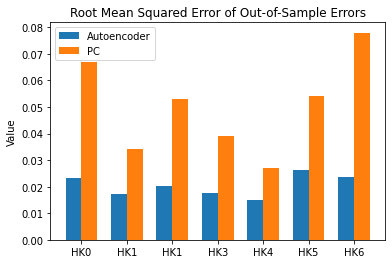

In [39]:
ar_width = 0.50
x = np.arange(7)
y1 = HKerror_out_rmsq
y2 = HK_RMSQ
bar_width = .35
# Plot the bars side by side
fig, ax = plt.subplots()
rects1 = ax.bar(x - bar_width/2, y1, bar_width, label='Autoencoder')
rects2 = ax.bar(x + bar_width/2, y2, bar_width, label='PC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('Root Mean Squared Error of Out-of-Sample Errors')
ax.set_xticks(x)
ax.set_xticklabels(['HK0', 'HK1', 'HK1', 'HK3', 'HK4', 'HK5', 'HK6'])
ax.legend()

plt.show()







- Lets import the Diebold-Mariano statistic to see if the out-of-sample errors are statically differenrt

In [106]:
def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE", power = 2):
    # Routine for checking errors
    def error_check():
        rt = 0
        msg = ""
        # Check if h is an integer
        if (not isinstance(h, int)):
            rt = -1
            msg = "The type of the number of steps ahead (h) is not an integer."
            return (rt,msg)
        # Check the range of h
        if (h < 1):
            rt = -1
            msg = "The number of steps ahead (h) is not large enough."
            return (rt,msg)
        len_act = len(actual_lst)
        len_p1  = len(pred1_lst)
        len_p2  = len(pred2_lst)
        # Check if lengths of actual values and predicted values are equal
        if (len_act != len_p1 or len_p1 != len_p2 or len_act != len_p2):
            rt = -1
            msg = "Lengths of actual_lst, pred1_lst and pred2_lst do not match."
            return (rt,msg)
        # Check range of h
        if (h >= len_act):
            rt = -1
            msg = "The number of steps ahead is too large."
            return (rt,msg)
        # Check if criterion supported
        if (crit != "MSE" and crit != "MAPE" and crit != "MAD" and crit != "poly"):
            rt = -1
            msg = "The criterion is not supported."
            return (rt,msg)  
        # Check if every value of the input lists are numerical values
        from re import compile as re_compile
        comp = re_compile("^\d+?\.\d+?$")  
        def compiled_regex(s):
            """ Returns True is string is a number. """
            if comp.match(s) is None:
                return s.isdigit()
            return True
        for actual, pred1, pred2 in zip(actual_lst, pred1_lst, pred2_lst):
            is_actual_ok = compiled_regex(str(abs(actual)))
            is_pred1_ok = compiled_regex(str(abs(pred1)))
            is_pred2_ok = compiled_regex(str(abs(pred2)))
            if (not (is_actual_ok and is_pred1_ok and is_pred2_ok)):  
                msg = "An element in the actual_lst, pred1_lst or pred2_lst is not numeric."
                rt = -1
                return (rt,msg)
        return (rt,msg)
    
    # Error check
    error_code = error_check()
    # Raise error if cannot pass error check
    if (error_code[0] == -1):
        raise SyntaxError(error_code[1])
        return
    # Import libraries
    from scipy.stats import t
    import collections
    import pandas as pd
    import numpy as np
    
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAD"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs(actual - p1))
            e2_lst.append(abs(actual - p2))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "MAPE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(abs((actual - p1)/actual))
            e2_lst.append(abs((actual - p2)/actual))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)
    elif (crit == "poly"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append(((actual - p1))**(power))
            e2_lst.append(((actual - p2))**(power))
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2)    
    
    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    # Find autocovariance and construct DM test statistics
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
              autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    DM_stat=V_d**(-0.5)*mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

In [129]:
Actual = HK_test
Actual = np.array(Actual)
PC = HK_out
PC = np.array(PC)
AC = HKtest_hat 
AC = np.array(AC)
actual_lst = Actual[:,0]
pred1_lst = PC[:,0]
pred2_lst = AC[:,0]
n_cols = Actual.shape[1];
DMSTAT = np.zeros(7)
DMPVAL = np.zeros(7)
for i in range(n_cols):
    actual_lst = Actual[:,i]
    pred1_lst = PC[:,i]
    pred2_lst = AC[:,i]
    dm_return = dm_test(actual_lst, pred1_lst, pred2_lst, h = 12, crit="MSE", power = 2)
    DMSTAT[i] = dm_return[0]
    DMPVAL[i] = dm_return[1]
    

print(DMPVAL)
    





[9.39920001e-26 1.21810906e-27 9.04930838e-36 5.74413299e-31
 5.70402045e-27 4.16571681e-20 4.02457031e-34]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3798 samples in 0.003s...
[t-SNE] Computed neighbors for 3798 samples in 0.149s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3798
[t-SNE] Computed conditional probabilities for sample 2000 / 3798
[t-SNE] Computed conditional probabilities for sample 3000 / 3798
[t-SNE] Computed conditional probabilities for sample 3798 / 3798
[t-SNE] Mean sigma: 0.038016
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.440292
[t-SNE] KL divergence after 5000 iterations: 0.301768


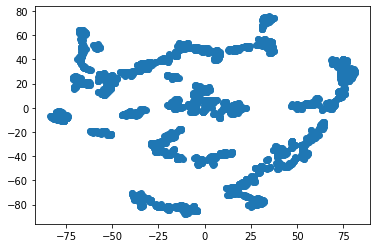

In [22]:
from sklearn.manifold import TSNE
import numpy as np

# Generate some example data

XX = USA

# Initialize and fit the t-SNE model
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=5000)
XX_tsne = tsne.fit_transform(XX)

# Visualize the results
import matplotlib.pyplot as plt
plt.scatter(XX_tsne[:, 0], XX_tsne[:, 1])
plt.show()

Text(0.5, 1.0, 'TSNE Components')

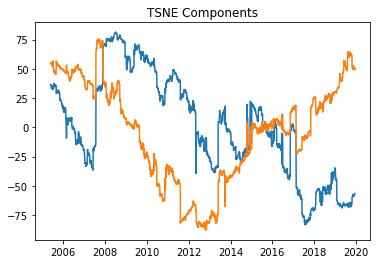

In [25]:
plt.plot(Date, XX_tsne)
plt.title('TSNE Components')

In [28]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def knn_compression(X, k):
    """
    Performs k-nearest neighbor data compression on a large N by K matrix X.

    Parameters:
    X (numpy.ndarray): The N by K matrix to be compressed.
    k (int): The number of nearest neighbors to consider.

    Returns:
    compressed_X (numpy.ndarray): The compressed N by k matrix.
    """

    # Find the k nearest neighbors for each data point
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Compute the mean of the k nearest neighbors for each data point
    compressed_X = np.zeros((X.shape[0], X.shape[1]))
    for i in range(X.shape[0]):
        compressed_X[i,:] = np.mean(X[indices[i,:],:], axis=0)

    # Select the first k columns of the compressed matrix
    compressed_X = compressed_X[:,:k]

    return compressed_X



In [32]:
USA_compressed = knn_compression(USA,4)

In [33]:
print(USA_compressed.shape)


(3798, 4)


Text(0.5, 1.0, 'K-Nearest Neighbor')

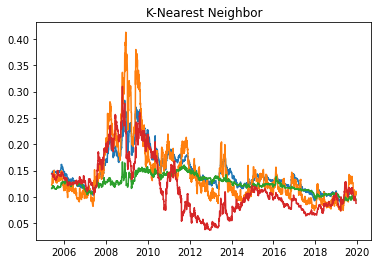

In [35]:
plt.plot(Date, USA_compressed)
plt.title('K-Nearest Neighbor')

In [36]:
import numpy as np

def standardize(X):
    """
    Standardizes a large N by K matrix X.

    Parameters:
    X (numpy.ndarray): The N by K matrix to be standardized.

    Returns:
    X_std (numpy.ndarray): The standardized N by K matrix.
    """

    # Calculate the mean and standard deviation of each column
    col_mean = np.mean(X, axis=0)
    col_std = np.std(X, axis=0)

    # Subtract the mean from each column and divide by the standard deviation
    X_std = (X - col_mean) / col_std

    return X_std


In [37]:
USAstd = standardize(USA)

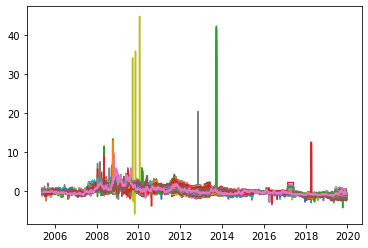

In [39]:
plt.plot(Date, USAstd)

In [44]:
import numpy as np
from sklearn.decomposition import FactorAnalysis

def factor_analysis(X, n_components):
    """
    Performs dynamic factor analysis on a large n by k matrix X.

    Parameters:
    X (numpy.ndarray): The n by k matrix to be analyzed.
    n_components (int): The number of factors to extract.

    Returns:
    transformed_X (numpy.ndarray): The transformed n by n_components matrix.
    """

    # Fit a factor analysis model to the data
    fa = FactorAnalysis(n_components=n_components).fit(X)

    # Transform the data using the factor analysis model
    transformed_X = fa.transform(X)

    return transformed_X


In [45]:
USA_factors = factor_analysis(USAstd,2)

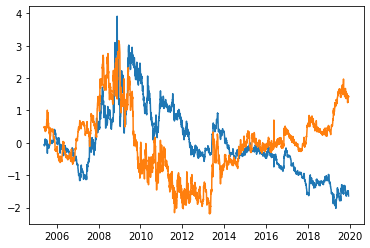

In [42]:
plt.plot(Date, USA_factors)

In [46]:
import numpy as np
from scipy.linalg import eig

def dynamic_factor_analysis(X, n_factors, n_lags):
    """
    Performs dynamic factor analysis on a large n by k matrix X.

    Parameters:
    X (numpy.ndarray): The n by k matrix to be analyzed.
    n_factors (int): The number of factors to extract.
    n_lags (int): The number of time lags to use.

    Returns:
    transformed_X (numpy.ndarray): The transformed n by n_factors matrix.
    """

    # Construct lagged matrix
    n_obs = X.shape[0]
    lagged_X = np.zeros((n_obs - n_lags, n_lags * X.shape[1]))
    for i in range(n_lags):
        lagged_X[:, i*X.shape[1]:(i+1)*X.shape[1]] = X[i:n_obs-n_lags+i, :]

    # Perform eigenvalue decomposition of lagged matrix
    cov = np.cov(lagged_X, rowvar=False)
    eigenvals, eigenvecs = eig(cov)

    # Select the largest eigenvalues and eigenvectors
    indices = np.argsort(eigenvals)[::-1][:n_factors]
    factor_vecs = eigenvecs[:, indices]

    # Compute factor loadings and transform data
    factor_loadings = np.zeros((X.shape[1], n_factors))
    transformed_X = np.zeros((n_obs - n_lags, n_factors))
    for i in range(n_factors):
        factor_loadings[:, i] = np.mean(lagged_X.dot(factor_vecs[:, i]), axis=0)
        transformed_X[:, i] = X[n_lags:, :].dot(factor_loadings[:, i])

    return transformed_X


In [47]:
USA_dfn = dynamic_factor_analysis(USAstd,2,1)

In [48]:
print(USA_dfn.shape)

(3797, 2)


In [49]:
print(Date.shape)

(3798,)


In [50]:
Date1 = Date[1:]

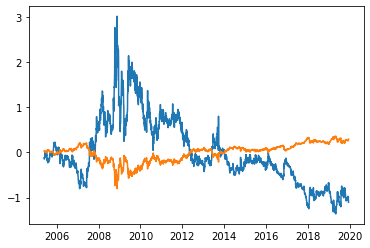

In [52]:
plt.plot(Date1, USA_dfn)